# Medical Data: Data Profile


## Imports


In [1]:
# ensure that notebook can access custom functions by adding them
# to the path
import sys

# adds everything in the parent directory to the path
sys.path.insert(0, '../')

In [2]:
# ensure notebook has most up-to-date version of custom functions
# autoreload all libraries/modules
%load_ext autoreload
%autoreload 2

In [3]:
# import data-centric libraries
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype


# scipy zscore function for standardization shapiro to check for
# normality
from scipy.stats import (zscore, shapiro)

# IterativeImputer to do Multiple imputations by Chained Equations
from fancyimpute import IterativeImputer

In [4]:
# plotting & graphing imports
import matplotlib.pyplot as plt
import seaborn as sns

# plotting libraries for evaluating missingness
import missingno as msno

In [5]:
# string linkage imports
from thefuzz import fuzz, process
import recordlinkage

Custom Functions

- `check_for_categorical` checks the number of distinct values (using
  `value_counts`) and returns a list of categories that fall under a
  given threshold. It's useful for quickly locating binary or categorical
  variables that have a smaller number of distinct values. The results
  are saved as `.txt` file reports.


In [6]:
from src.generate_report import check_for_categorical

### Data Import & Initial Data Integrity Checks


In [7]:
path = "../data/medical_raw_data.csv"

medical = pd.read_csv(path)

In [8]:
medical.shape

(10000, 53)

### Observe a small sample of data to confirm import.

As there are 53 columns, transposing the sample will make the column
names easier to read.


In [9]:
display(medical.sample(5).T)

,6304,5437,888,5107,2468
Unnamed: 0,6305,5438,889,5108,2469
CaseOrder,6305,5438,889,5108,2469
Customer_id,O880048,X179332,V972210,L67565,D956582
Interaction,53daafe6-0f1d-4feb-b24c-881902ed4044,fe790d1e-04ed-45da-8b26-8684870e52ee,ed826b81-df0a-49d1-b818-83980da57203,024ce910-277f-446b-b05d-2046c5153312,bbb71438-4187-468c-b115-dd54c2ab4fef
UID,622866be46fd8dfd34e6b240650c20b8,7f82896f0f05bda3b0a609a5a18b877d,2a15e713f0ec03aef29057a7583778f7,37171ed43fe3c6da6249ee8766c8c259,5159ac4b28e93323b5d862389f646ea7
City,Gilbert,Rockville,La Ward,Santa Ana,Kingsport
State,AZ,MD,TX,CA,TN
County,Maricopa,Montgomery,Jackson,Orange,Sullivan
Zip,85233,20851,77970,92701,37665
Lat,33.35209,39.07844,28.84469,33.74823,36.57878


## Duplicate rows


The code below demonstrates that are no duplicated rows.


In [10]:
# Return a sum of duplicated rows
medical.duplicated().sum()

0

## Detect Missing Values & Data Types

The code in the cells below confirms that these columns contain null
values:

| Category     | Nulls |
| ------------ | ----- |
| Children     | 2588  |
| Age          | 2414  |
| Income       | 2464  |
| Soft_drink   | 2467  |
| Overweight   | 982   |
| Anxiety      | 984   |
| Initial_days | 1056  |


In [11]:
# Return number of non-null entries
# and the data type at import
medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          10000 non-null  int64  
 1   CaseOrder           10000 non-null  int64  
 2   Customer_id         10000 non-null  object 
 3   Interaction         10000 non-null  object 
 4   UID                 10000 non-null  object 
 5   City                10000 non-null  object 
 6   State               10000 non-null  object 
 7   County              10000 non-null  object 
 8   Zip                 10000 non-null  int64  
 9   Lat                 10000 non-null  float64
 10  Lng                 10000 non-null  float64
 11  Population          10000 non-null  int64  
 12  Area                10000 non-null  object 
 13  Timezone            10000 non-null  object 
 14  Job                 10000 non-null  object 
 15  Children            7412 non-null   float64
 16  Age  

In [12]:
# Columns containing null values
contains_nulls_bool = medical.isna().sum() > 0
# index names of these columns
incomplete_cols = (
    medical.isna()
           .sum()[contains_nulls_bool]
           .index)

display(
    "Null Counts",
    medical.isna().sum()[contains_nulls_bool],
    incomplete_cols)

'Null Counts'

Children        2588
Age             2414
Income          2464
Soft_drink      2467
Overweight       982
Anxiety          984
Initial_days    1056
dtype: int64

Index(['Children', 'Age', 'Income', 'Soft_drink', 'Overweight', 'Anxiety',
       'Initial_days'],
      dtype='object')

In [13]:
complete_cols = list(
    set(medical.columns).difference(incomplete_cols))


# confirm that complete_cols & incomplete_cols
# sum to total number of columns
print(
    len(complete_cols) + len(incomplete_cols),
    medical.shape[1])

53 53


### Separate categorical and quantitative categories

Create two lists

Ignore duplicate index columns, unique identifier columns, and
location columns.


In [14]:
categorical_cols = [
    'Area', 'Timezone', 'Job', 'Education', 'Employment', 'Marital',
    'Gender', 'ReAdmis', 'Soft_drink', 'Initial_admin', 'HighBlood',
    'Stroke', 'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes',
    'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis',
    'Reflux_esophagitis', 'Asthma',
    'Item1', 'Item2', 'Item3', 'Item4',
    'Item5', 'Item6', 'Item7', 'Item8']

quantitative_cols = [
    'Population', 'Children', 'Age', 'Income', 'VitD_levels',
    'Doc_visits', 'Full_meals_eaten', 'VitD_supp', 'Initial_days',
    'TotalCharge', 'Additional_charges']

### Column Lists With and Without Null Values

Create lists of columns:

- quantitative columns containing null values
- categorical columns containing null values
- quantitative columns with complete values
- categorical columns with complete values


In [15]:
quantitative_contains_nulls = list(
    set(incomplete_cols).difference(categorical_cols))

categorical_contains_nulls = list(
    set(incomplete_cols).difference(quantitative_cols))

quantitative_complete = list(
    set(quantitative_cols).difference(quantitative_contains_nulls)
)

categorical_complete = list(
    set(categorical_cols).difference(categorical_contains_nulls)
)


print(
    f"Quantitative containing nulls:\n\t{quantitative_contains_nulls}",
    f"Categorical containing nulls:\n\t{categorical_contains_nulls}",
    f"Quantitative complete:\n\t{quantitative_complete}",
    f"Categorical complete:\n\t{categorical_complete}",
    sep="\n"
)

Quantitative containing nulls:
	['Children', 'Age', 'Initial_days', 'Income']
Categorical containing nulls:
	['Overweight', 'Anxiety', 'Soft_drink']
Quantitative complete:
	['Population', 'TotalCharge', 'Additional_charges', 'Full_meals_eaten', 'VitD_levels', 'Doc_visits', 'VitD_supp']
Categorical complete:
	['HighBlood', 'Arthritis', 'Stroke', 'Item4', 'Hyperlipidemia', 'Job', 'Item1', 'Item6', 'Education', 'Area', 'Marital', 'Item5', 'BackPain', 'Diabetes', 'Item2', 'Asthma', 'Complication_risk', 'ReAdmis', 'Item7', 'Gender', 'Reflux_esophagitis', 'Allergic_rhinitis', 'Employment', 'Initial_admin', 'Item3', 'Timezone', 'Item8']


## Missingness

Missing Completely at Random (MCAR).

The plots below find no relationships between features with missing
observations and one another. There also seems to be no relationships
between features with missing observations and features containing all
observations. It's likely that missing values are "missing completely at
random (MCAR)"


### Visualize missingness via `missingno`


<Axes: >

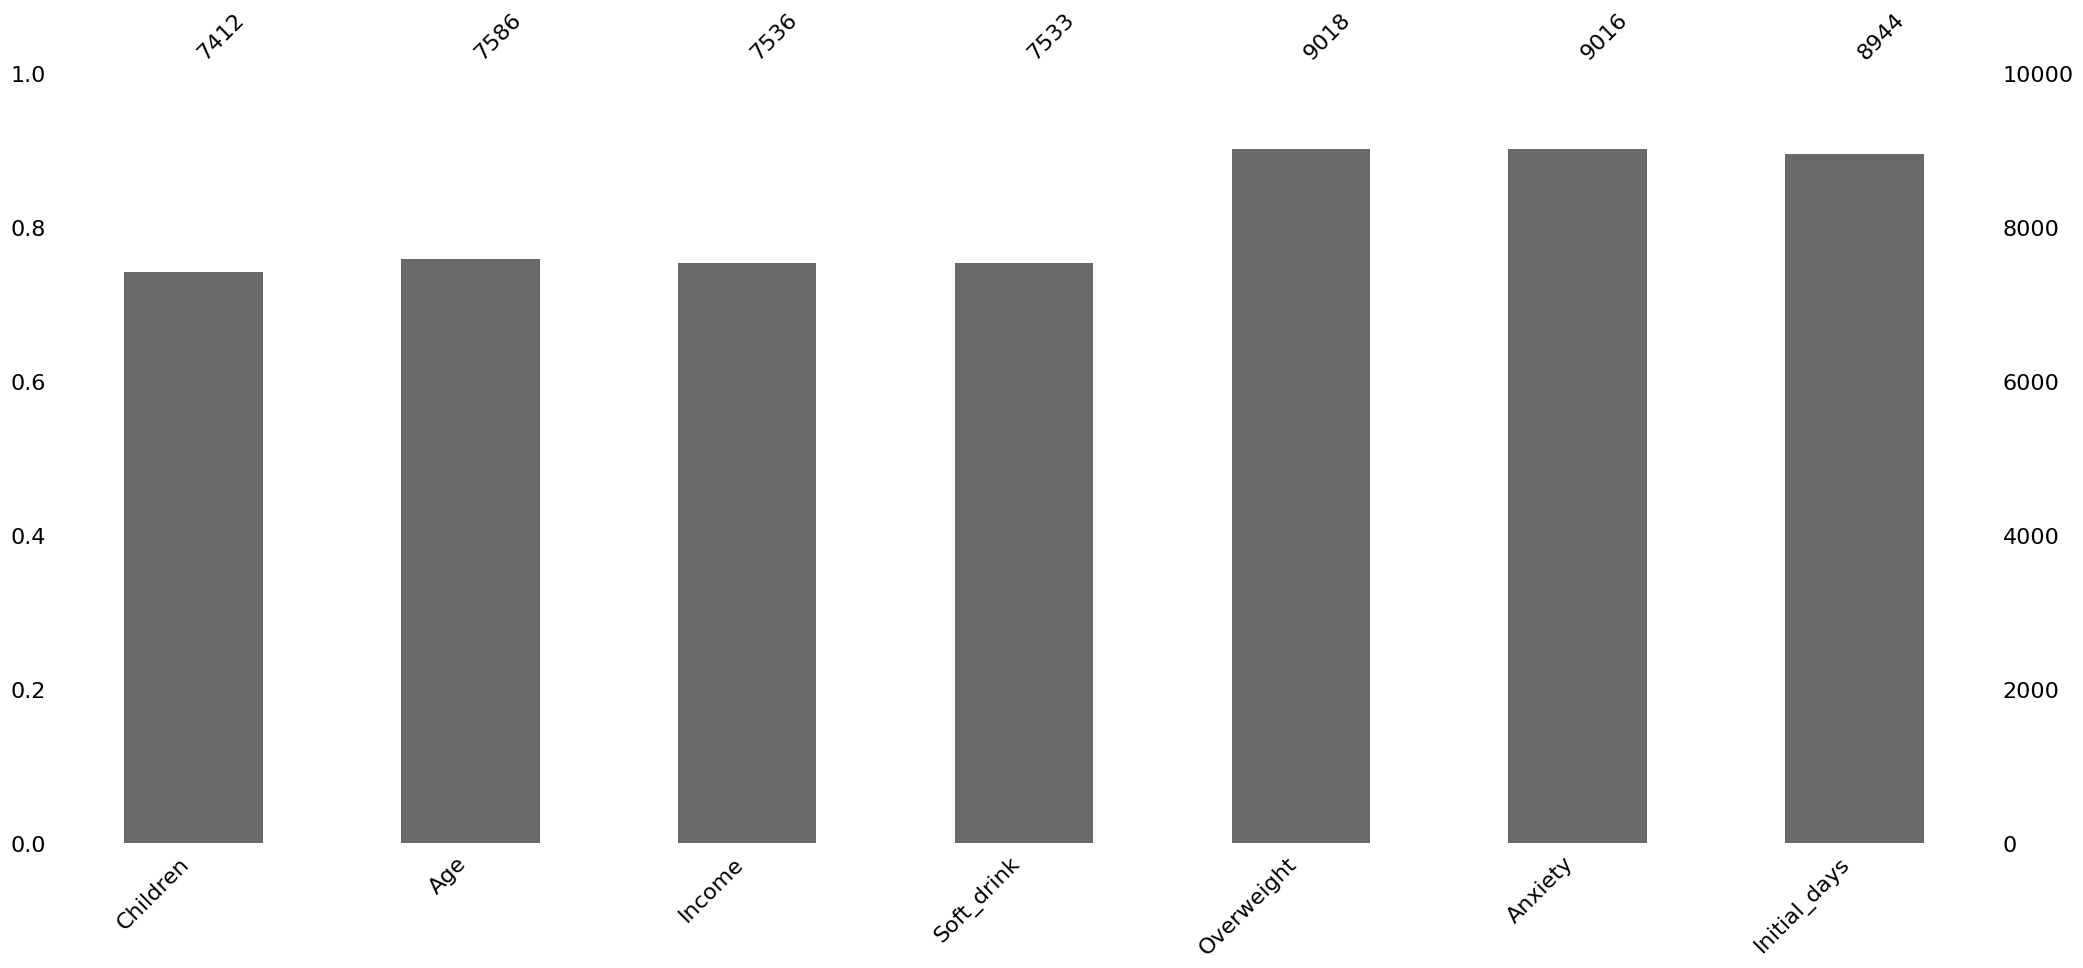

In [16]:
msno.bar(medical[incomplete_cols])

#### Check missing categories against one another

There doesn't seem to be any noteworthy correlation between features
containing missing values. This suggests that missingness cannot be
described as "missing not at random (MNAR)"

This suggests that each category is missing completely at random (MCAR)


<Axes: >

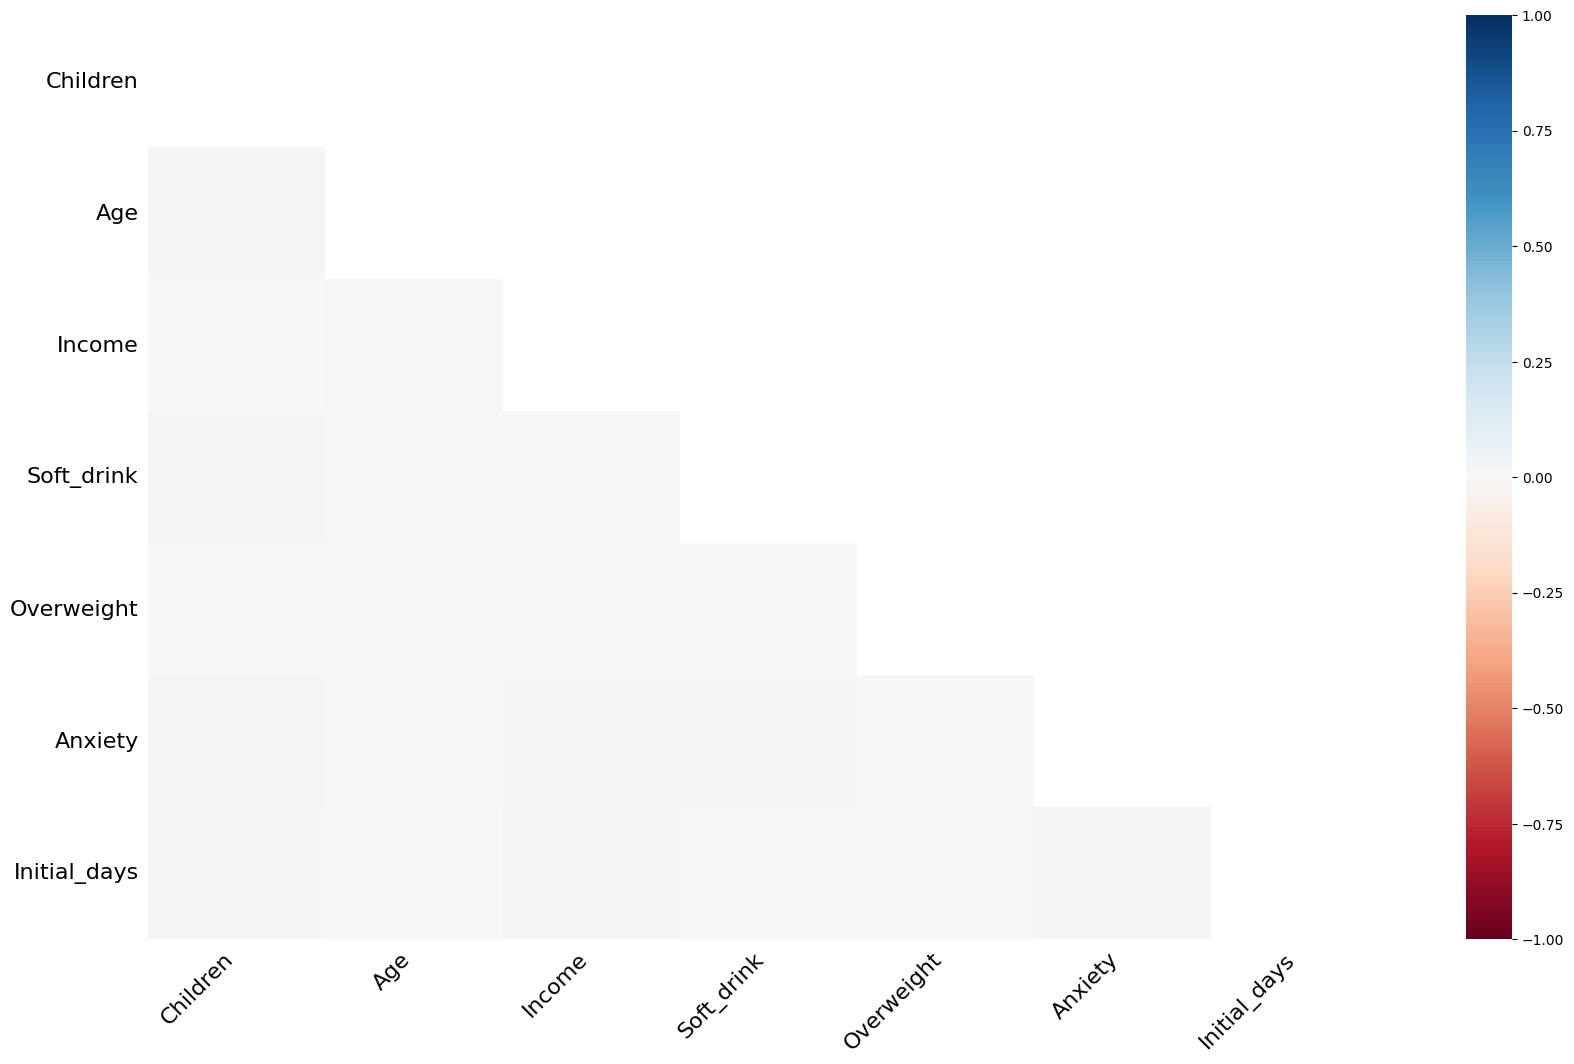

In [17]:
# Incomplete columns do not demonstrate
# any strong correlations with one another.
msno.heatmap(medical)

Resource

- [Is the data missing at random?](https://campus.datacamp.com/courses/dealing-with-missing-data-in-python/does-missingness-have-a-pattern?ex=1)


Matrix Plots

Matrix plots show no indication of pattern when sorted by individual missing categories. Missingness for features is not likely related to other missing features (i.e. the values are not likely "Missing not at Random (MNAR)" ).


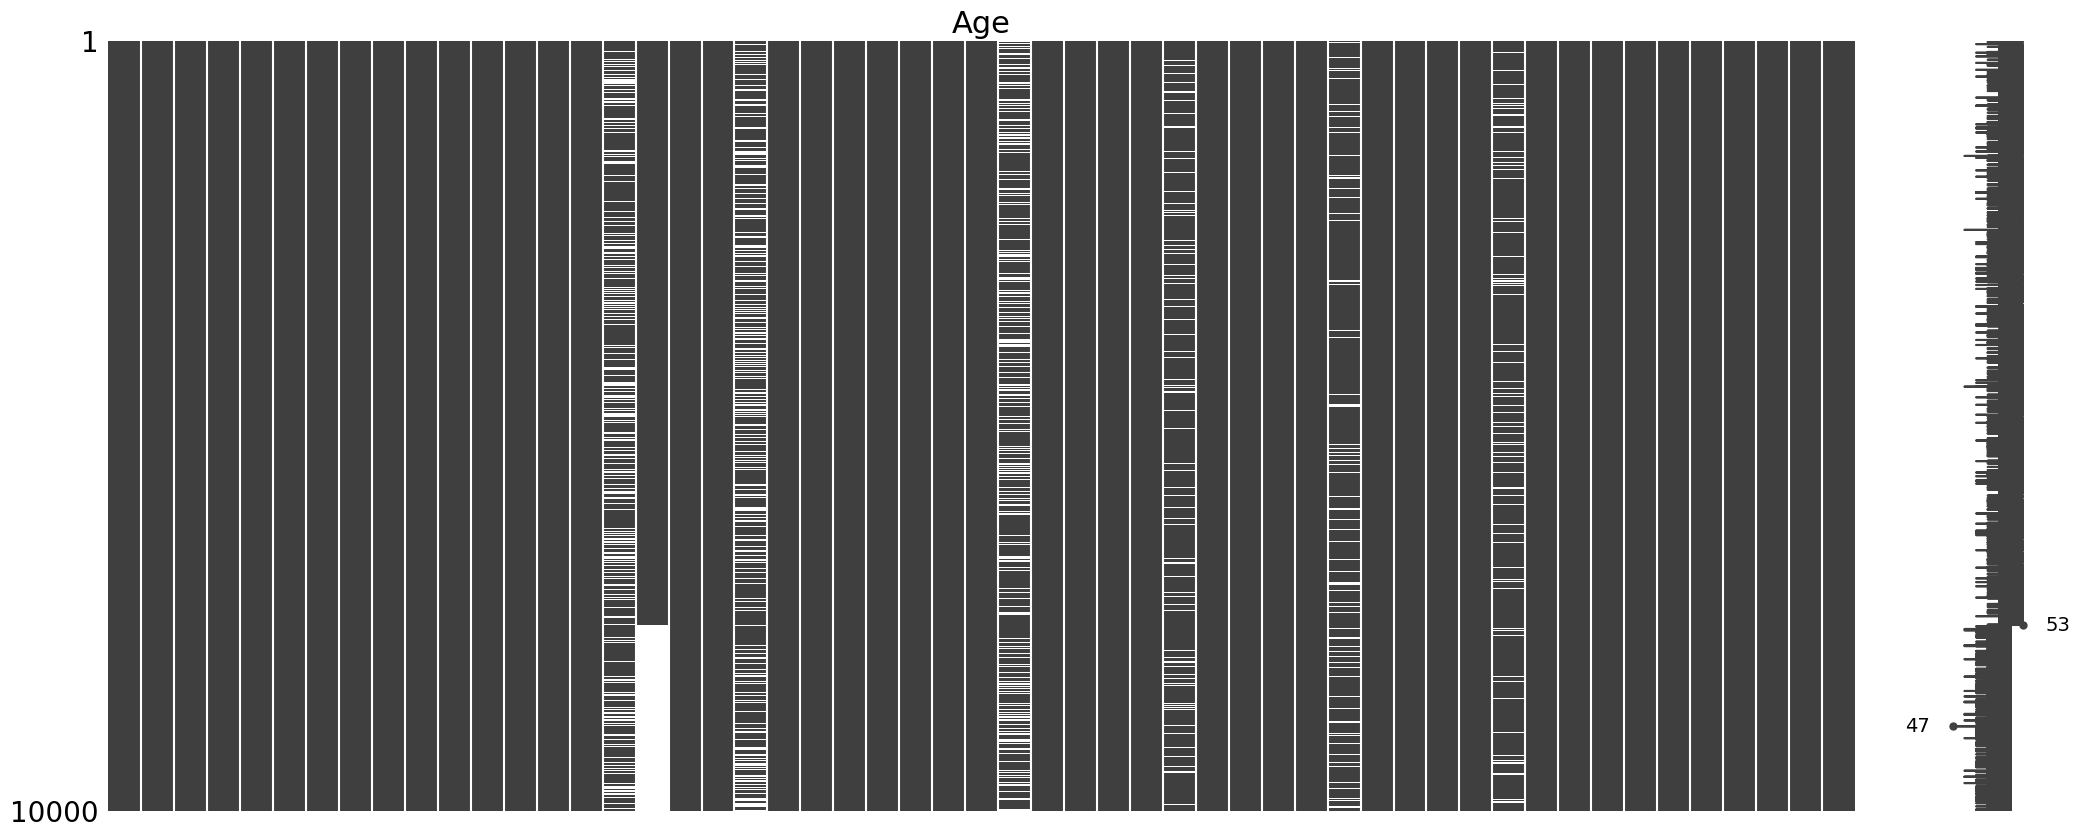

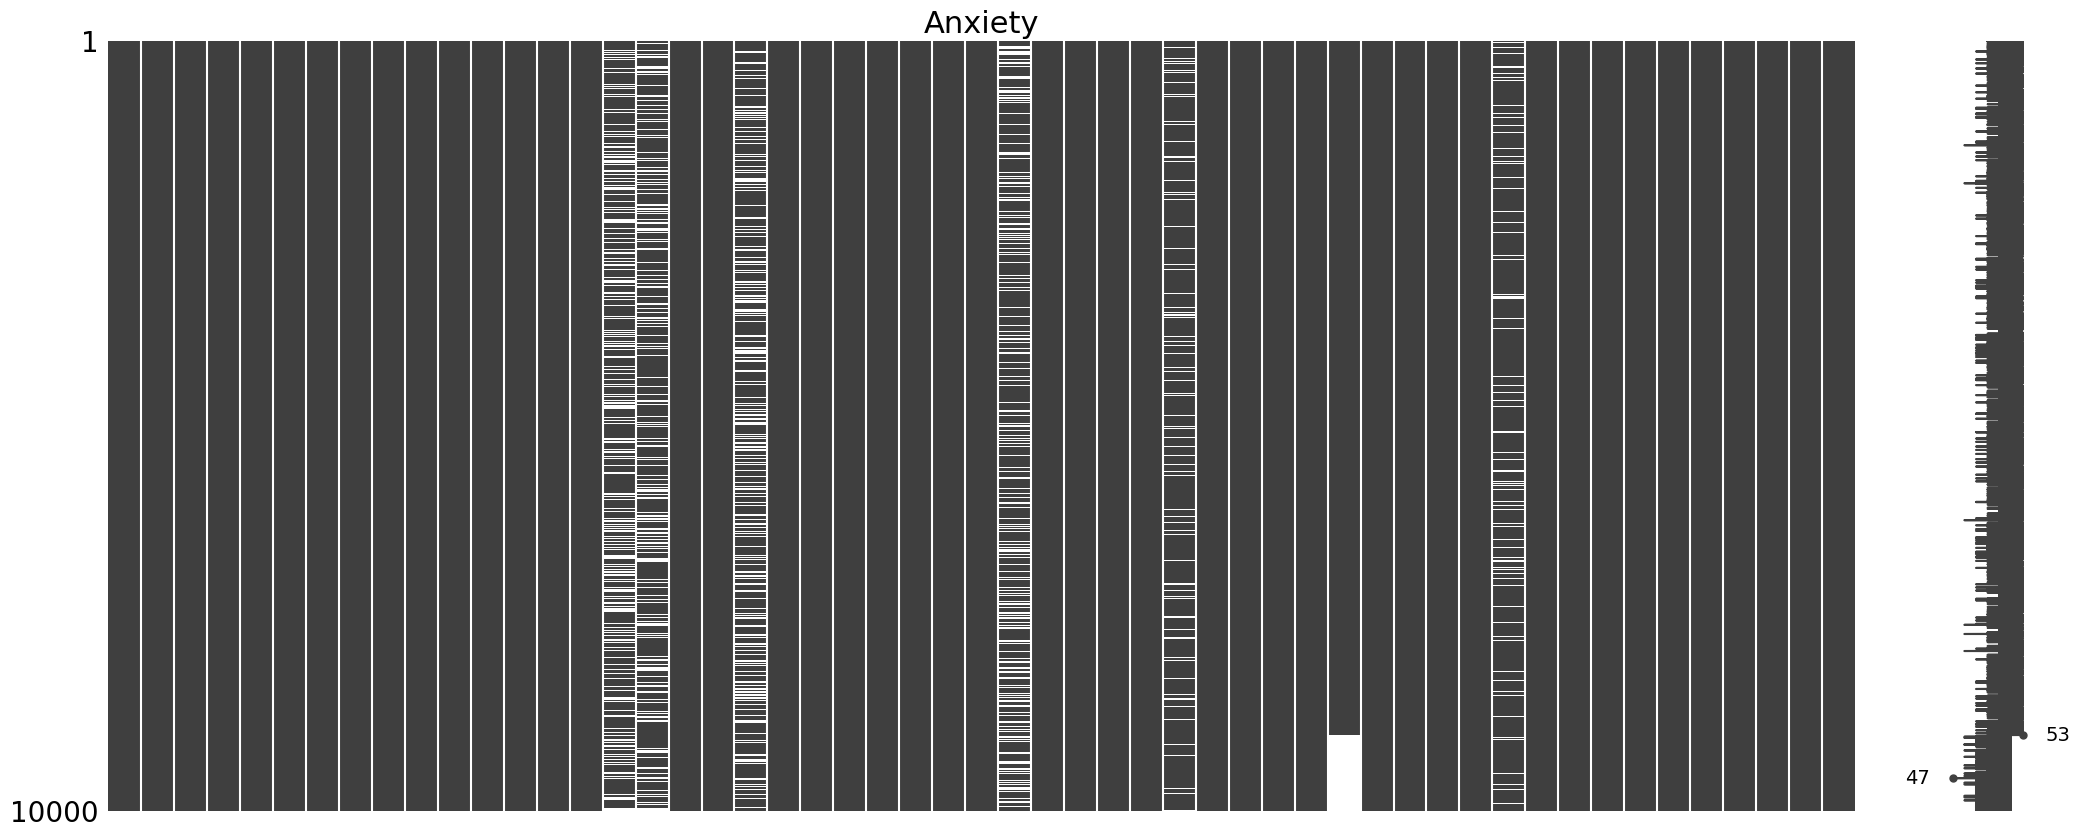

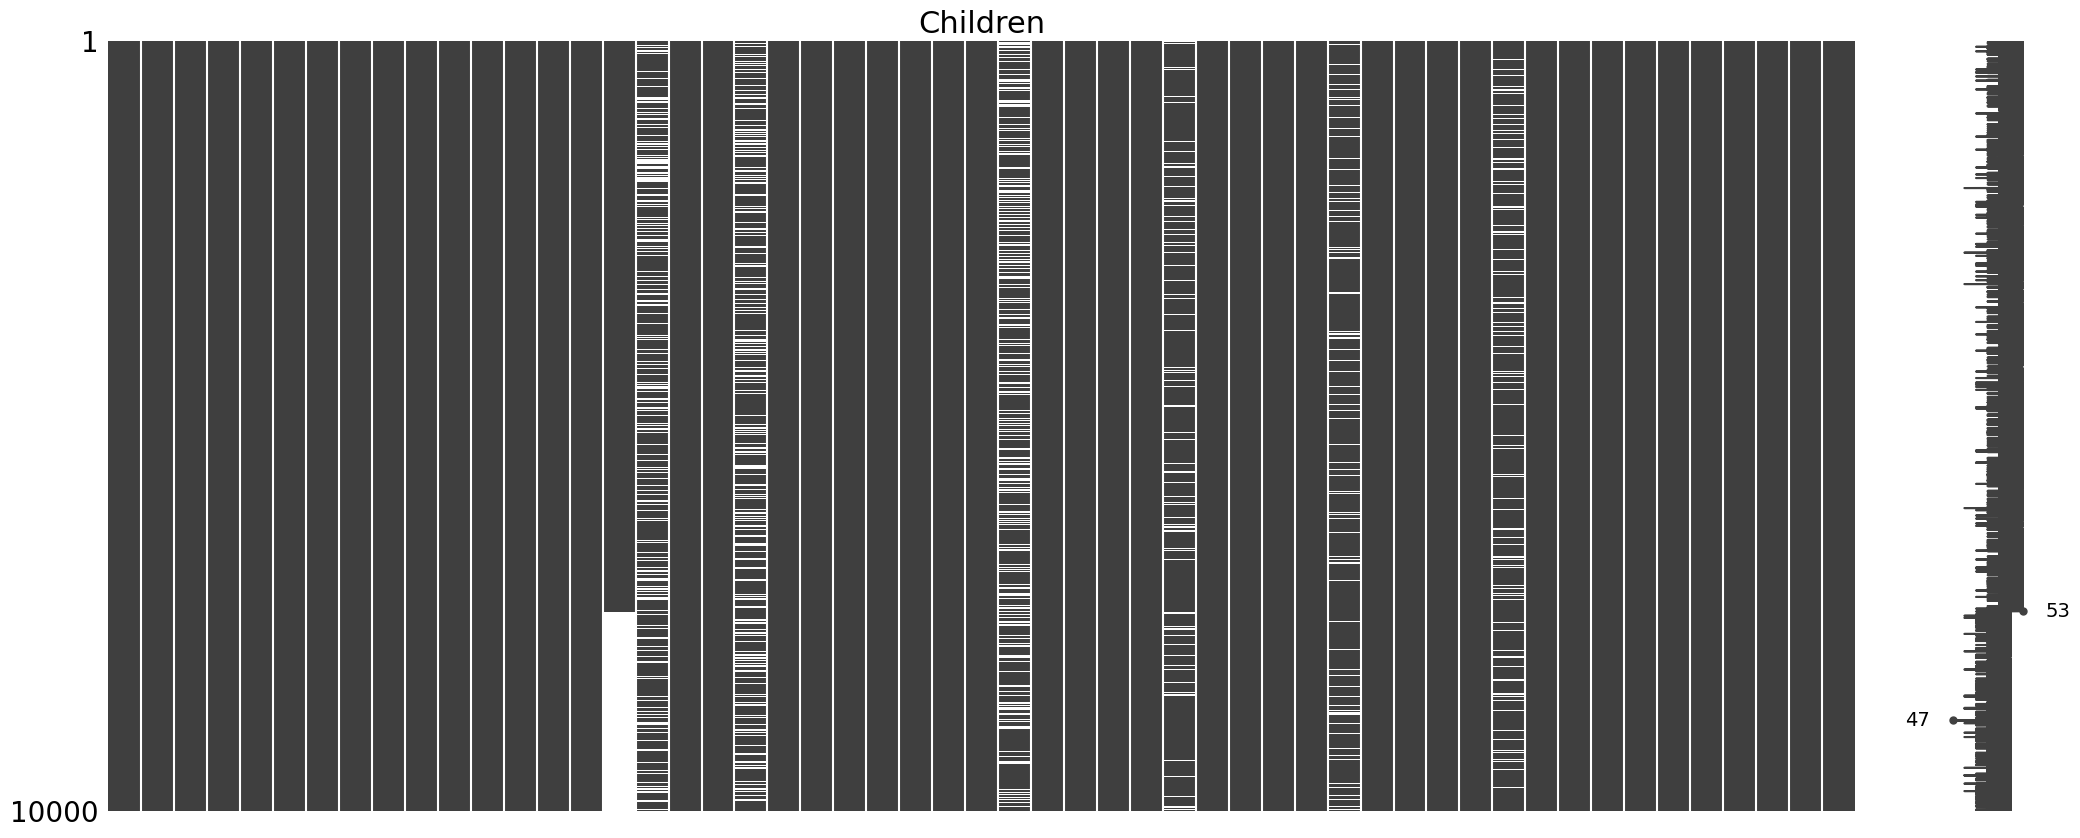

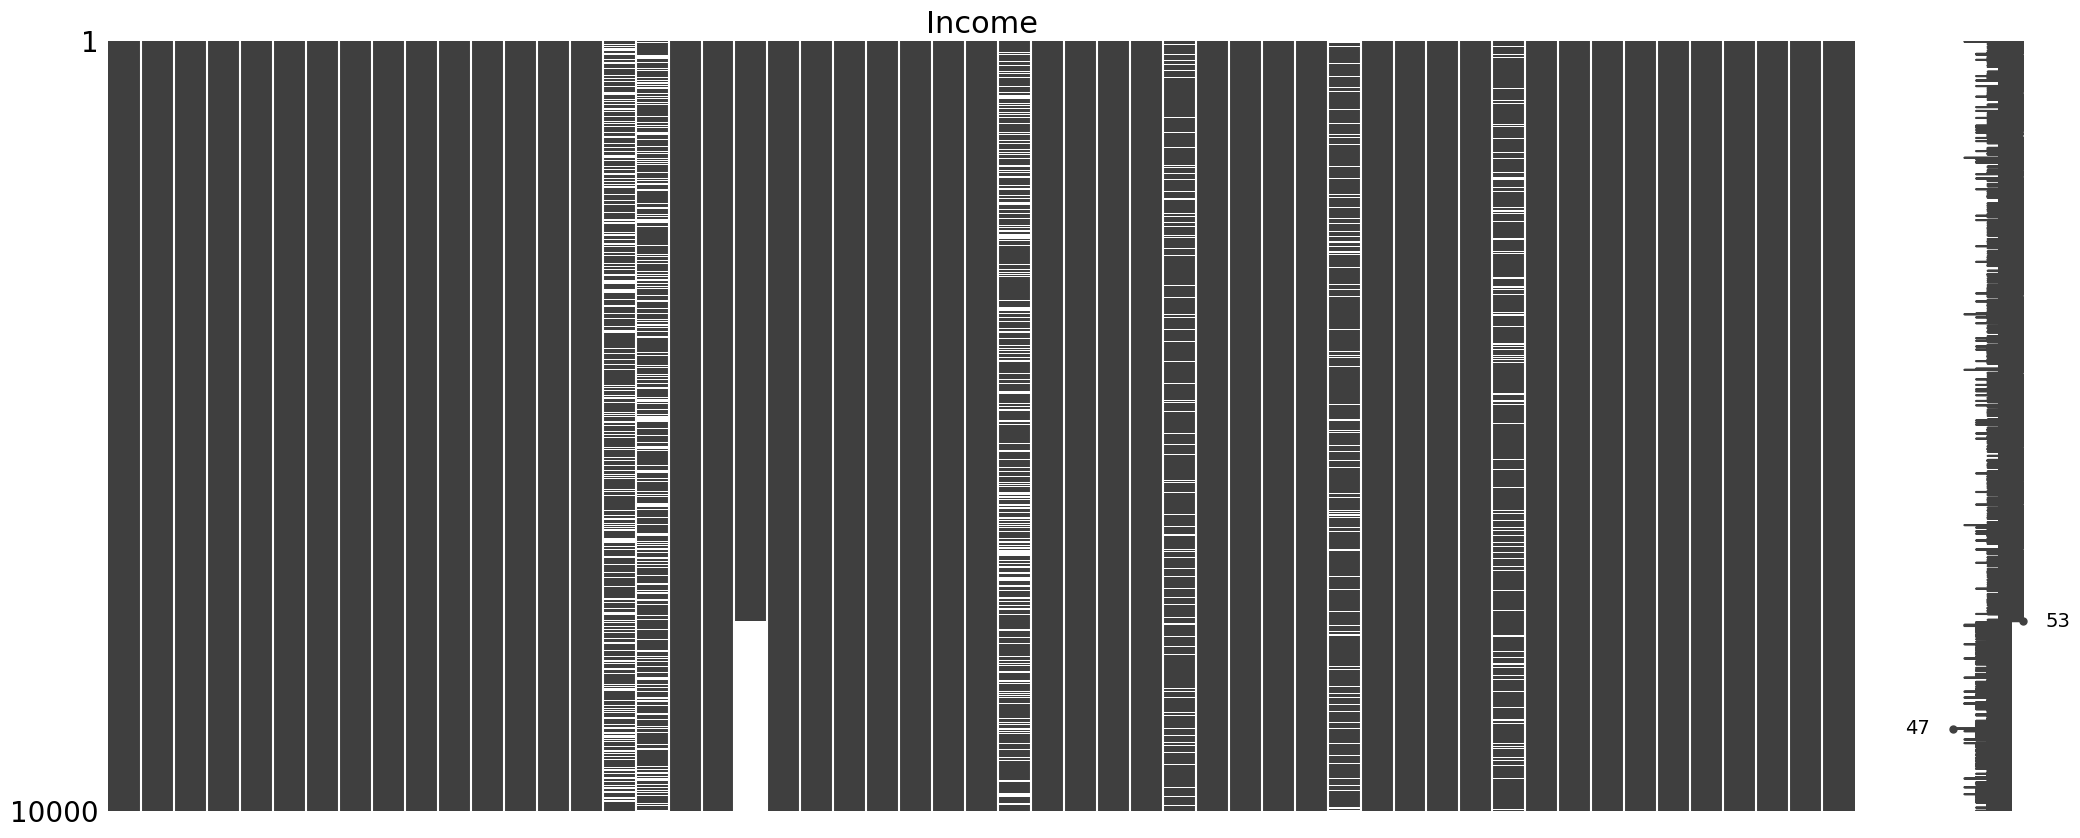

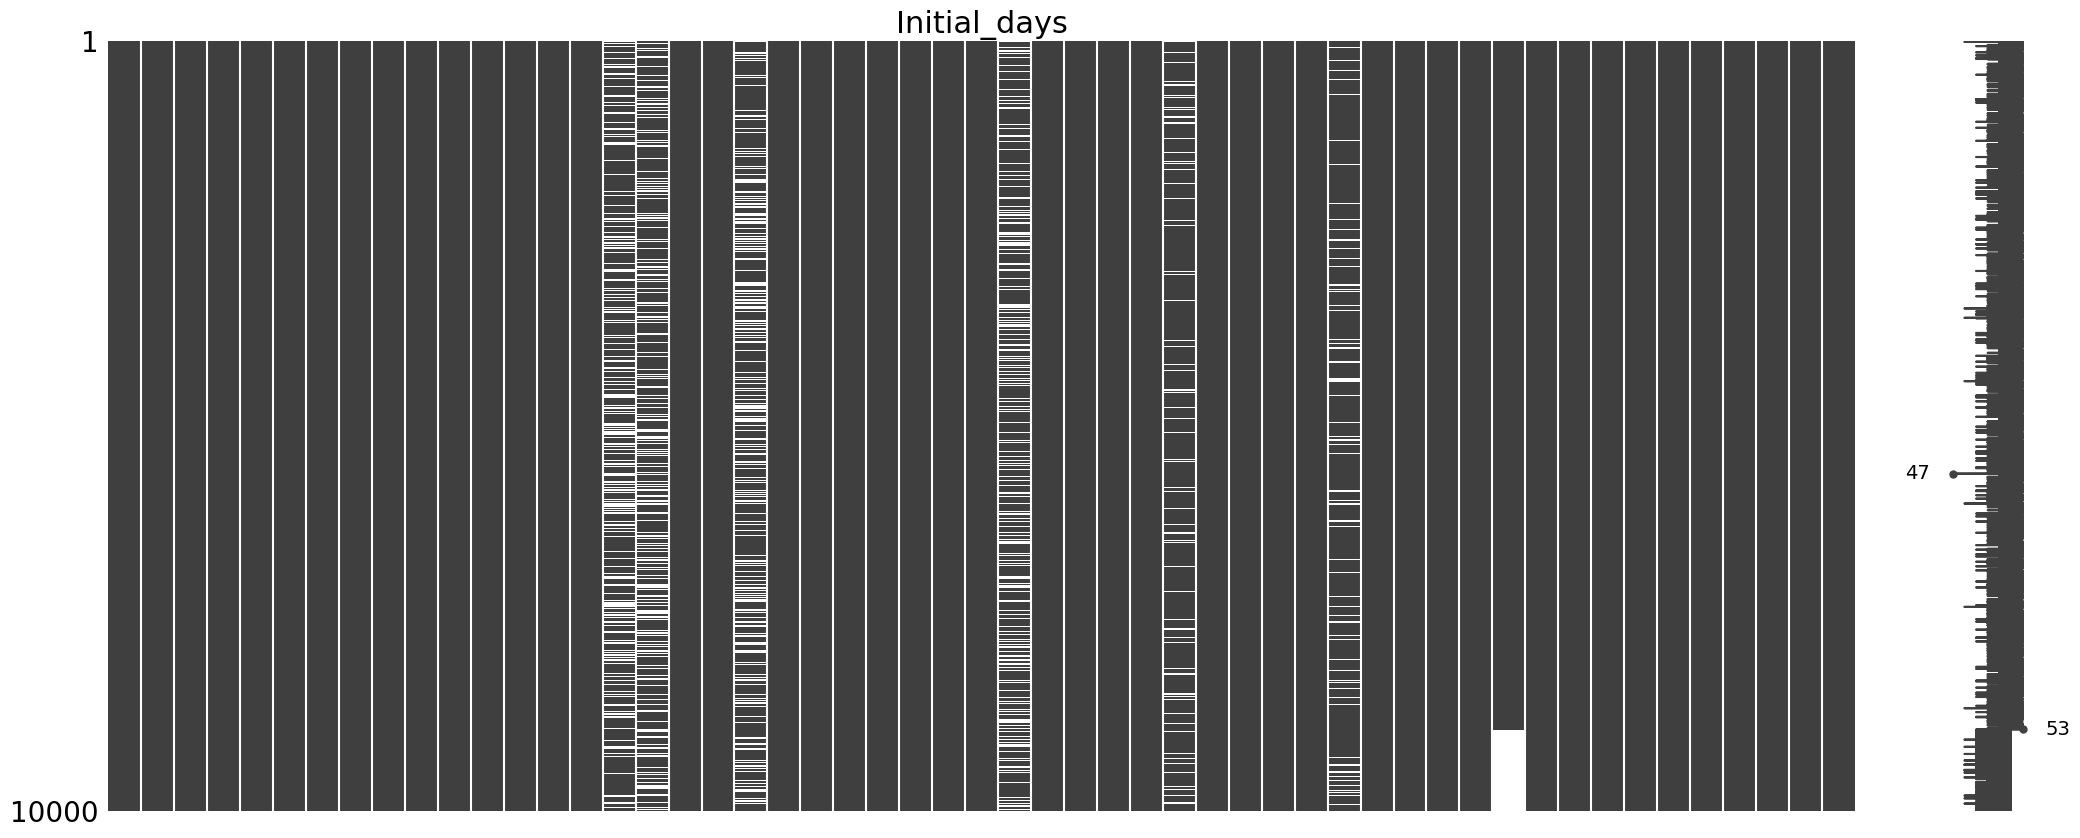

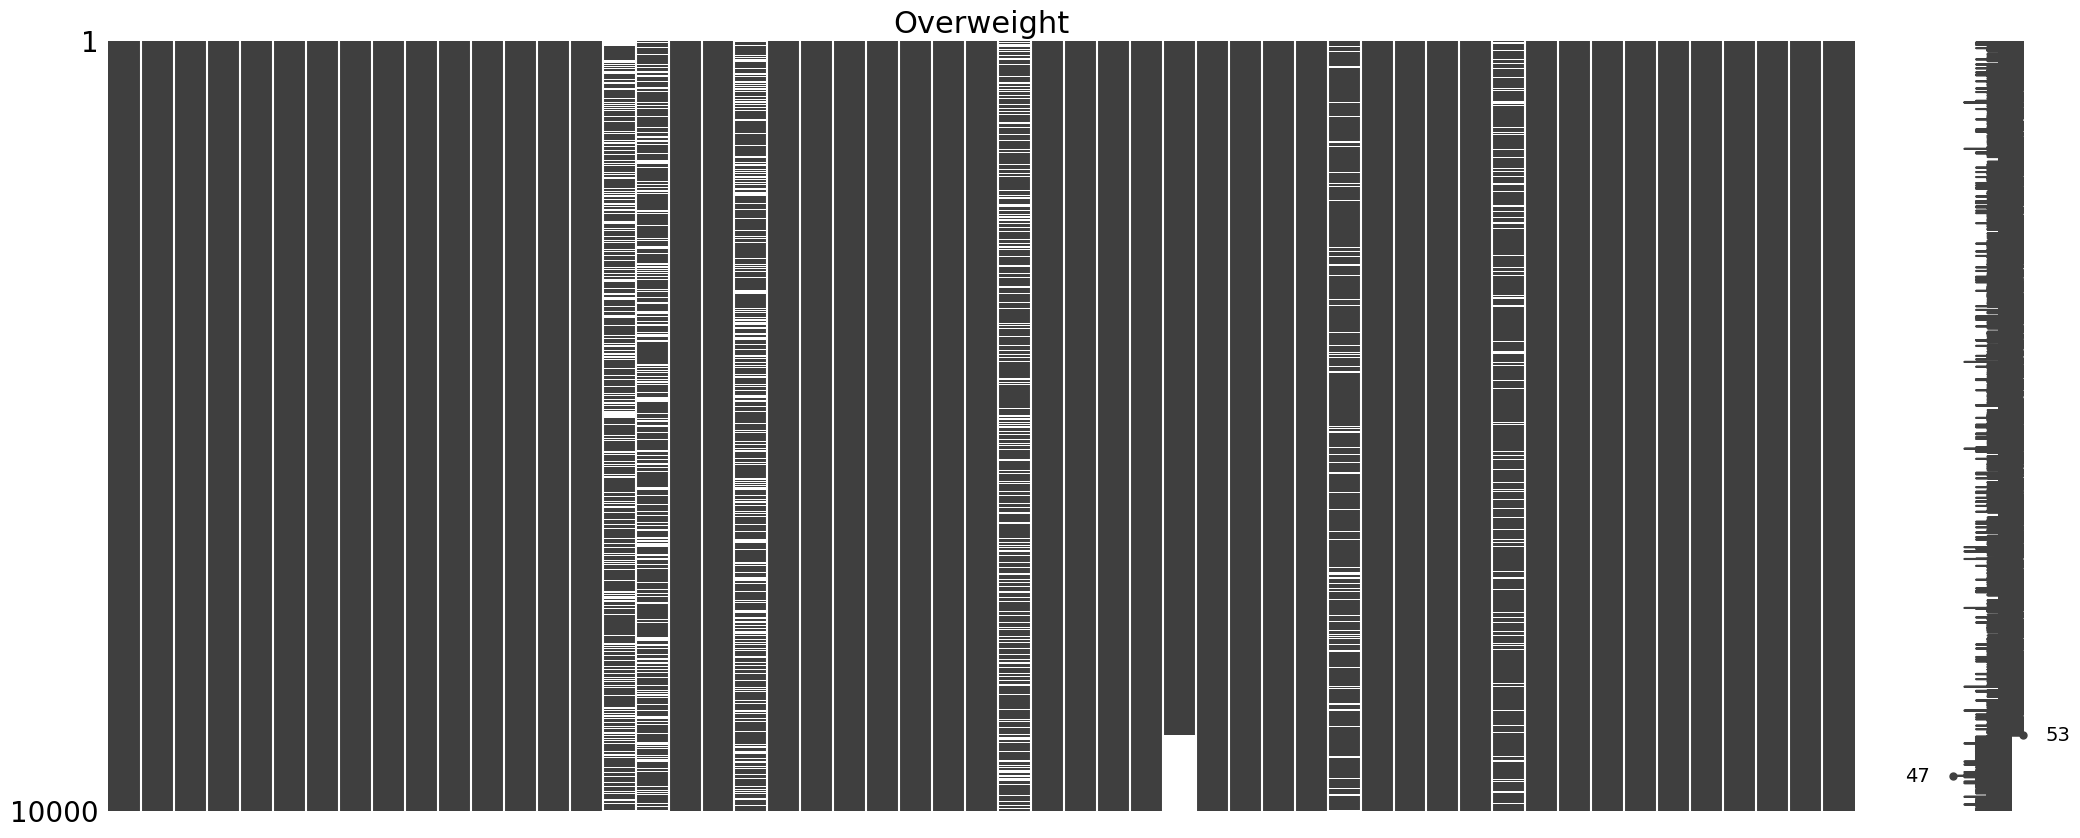

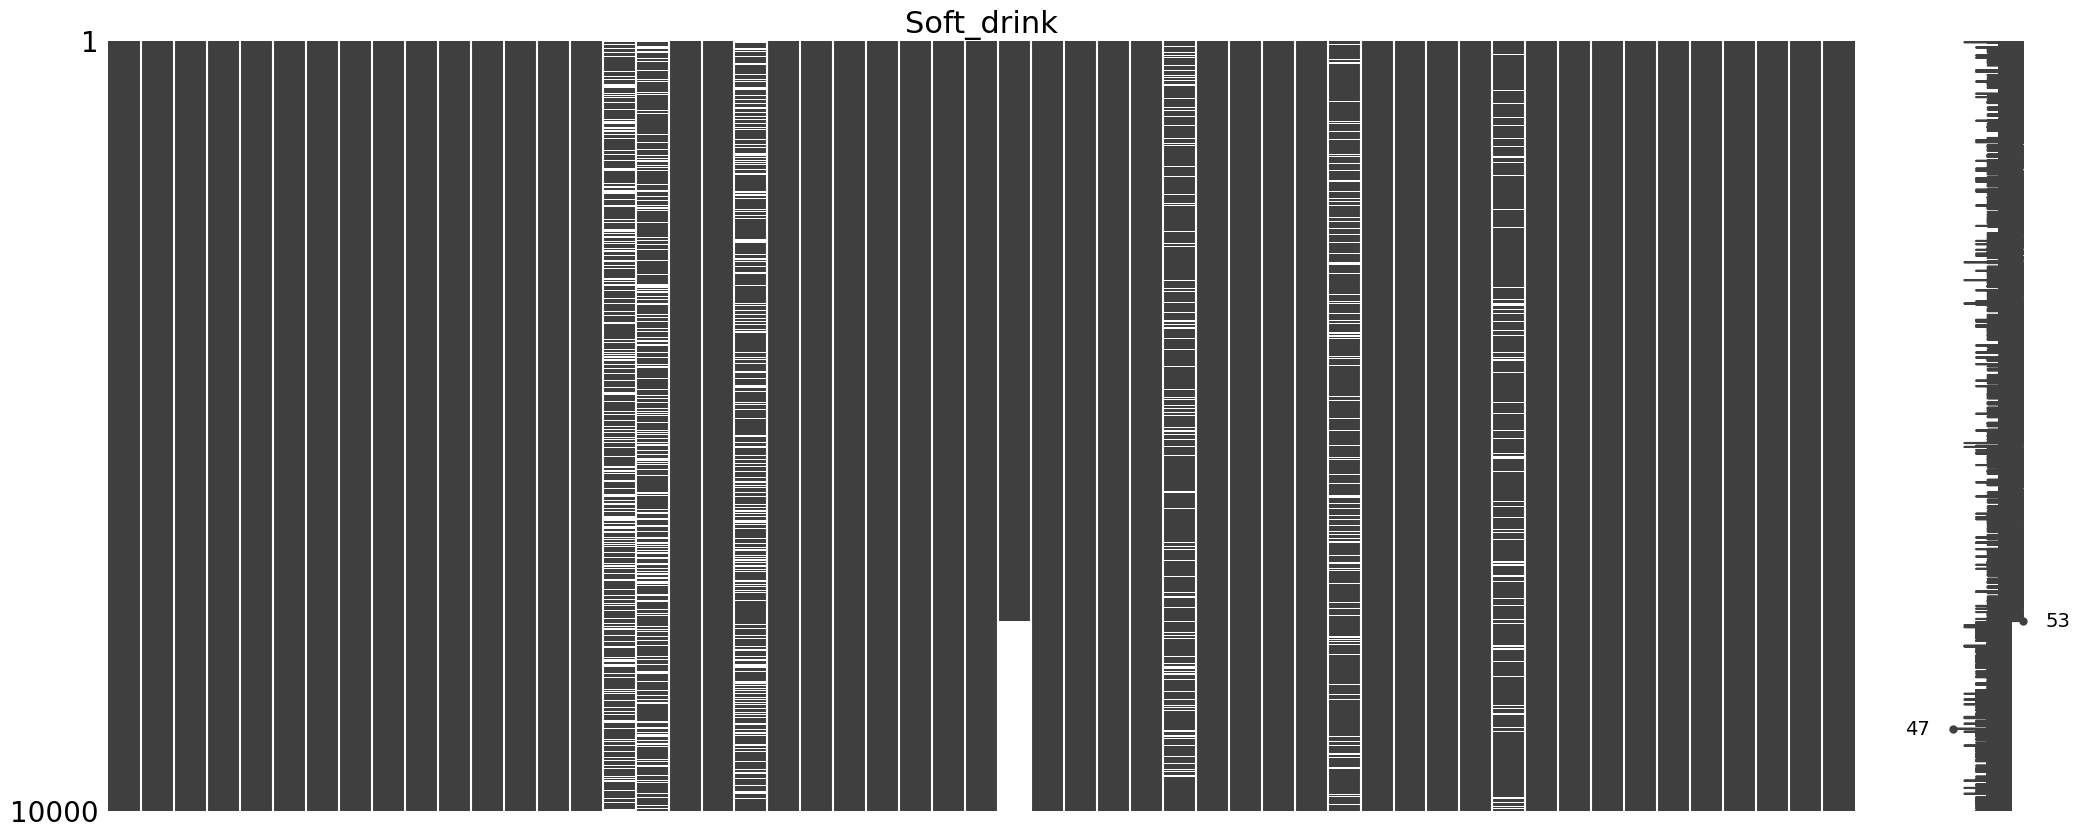

In [18]:
for col in sorted(incomplete_cols):

    msno.matrix(medical.sort_values(col)).set_title(col, size=22)

Checking Missing Values against present values

The plots below show no obvious relationships between categories with
complete data and categories with missing data. This suggests that the
categories with missing data are not "Missing at Random (MAR)"


/Users/cshawnkeech/anaconda3/envs/wgu_env/lib/python3.12/site-packages/missingno/missingno.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


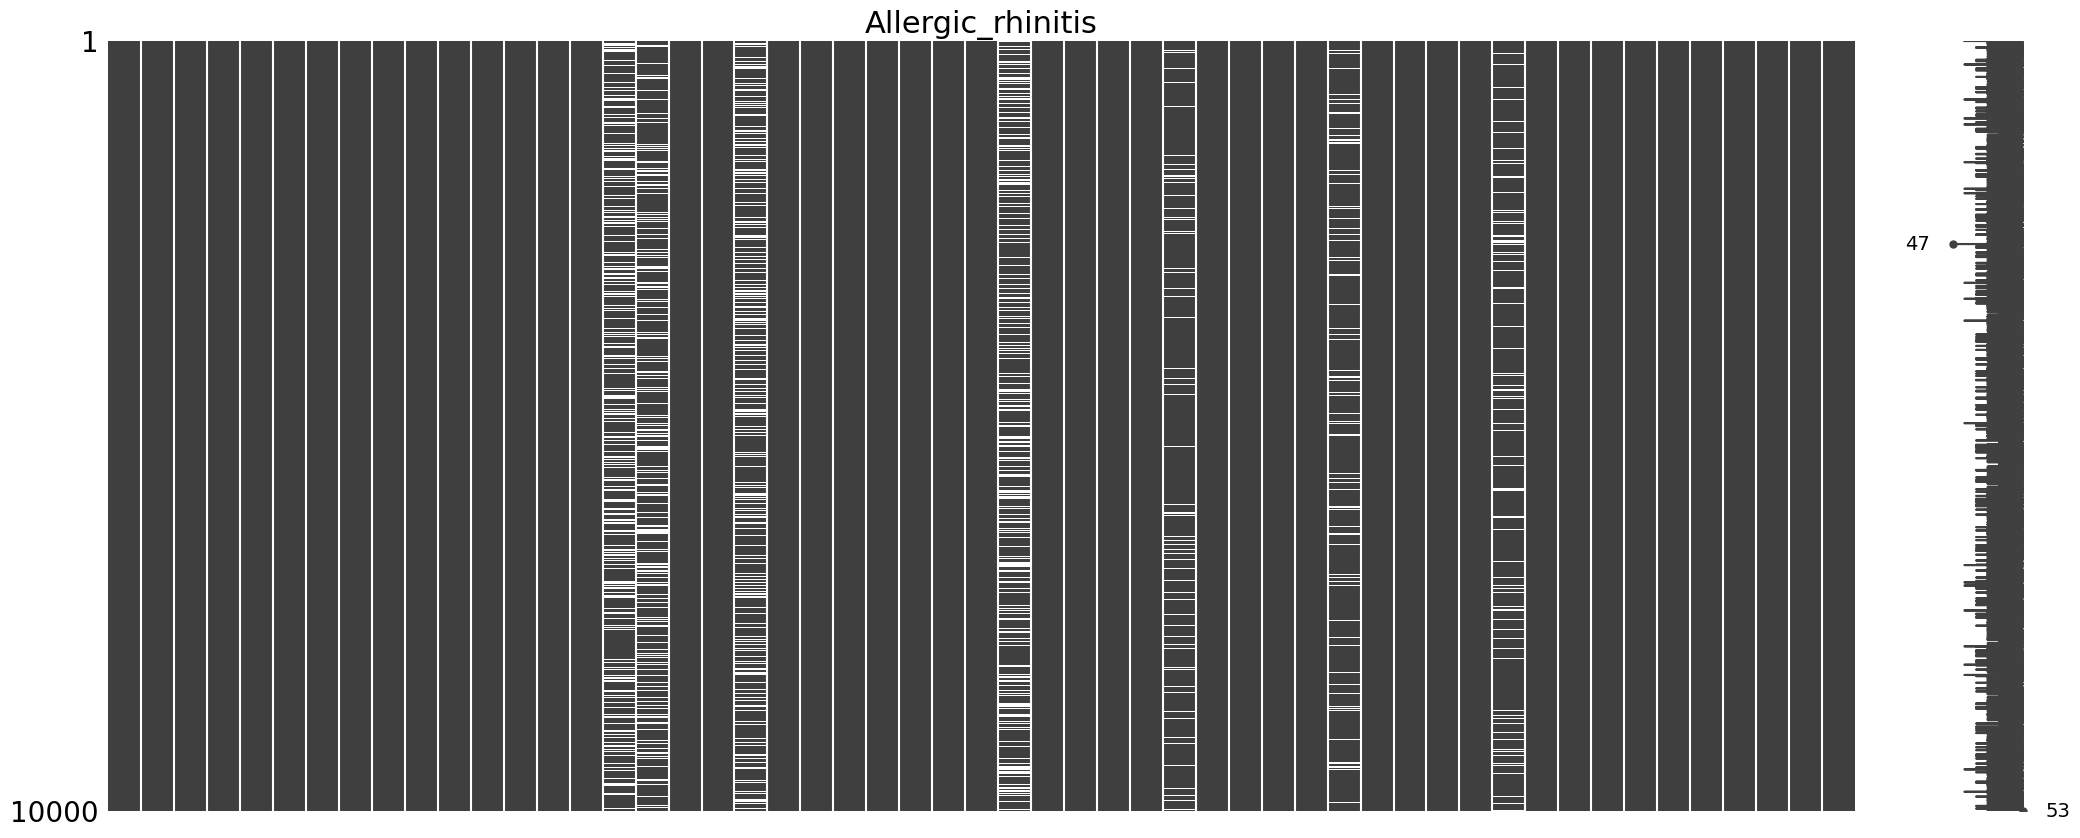

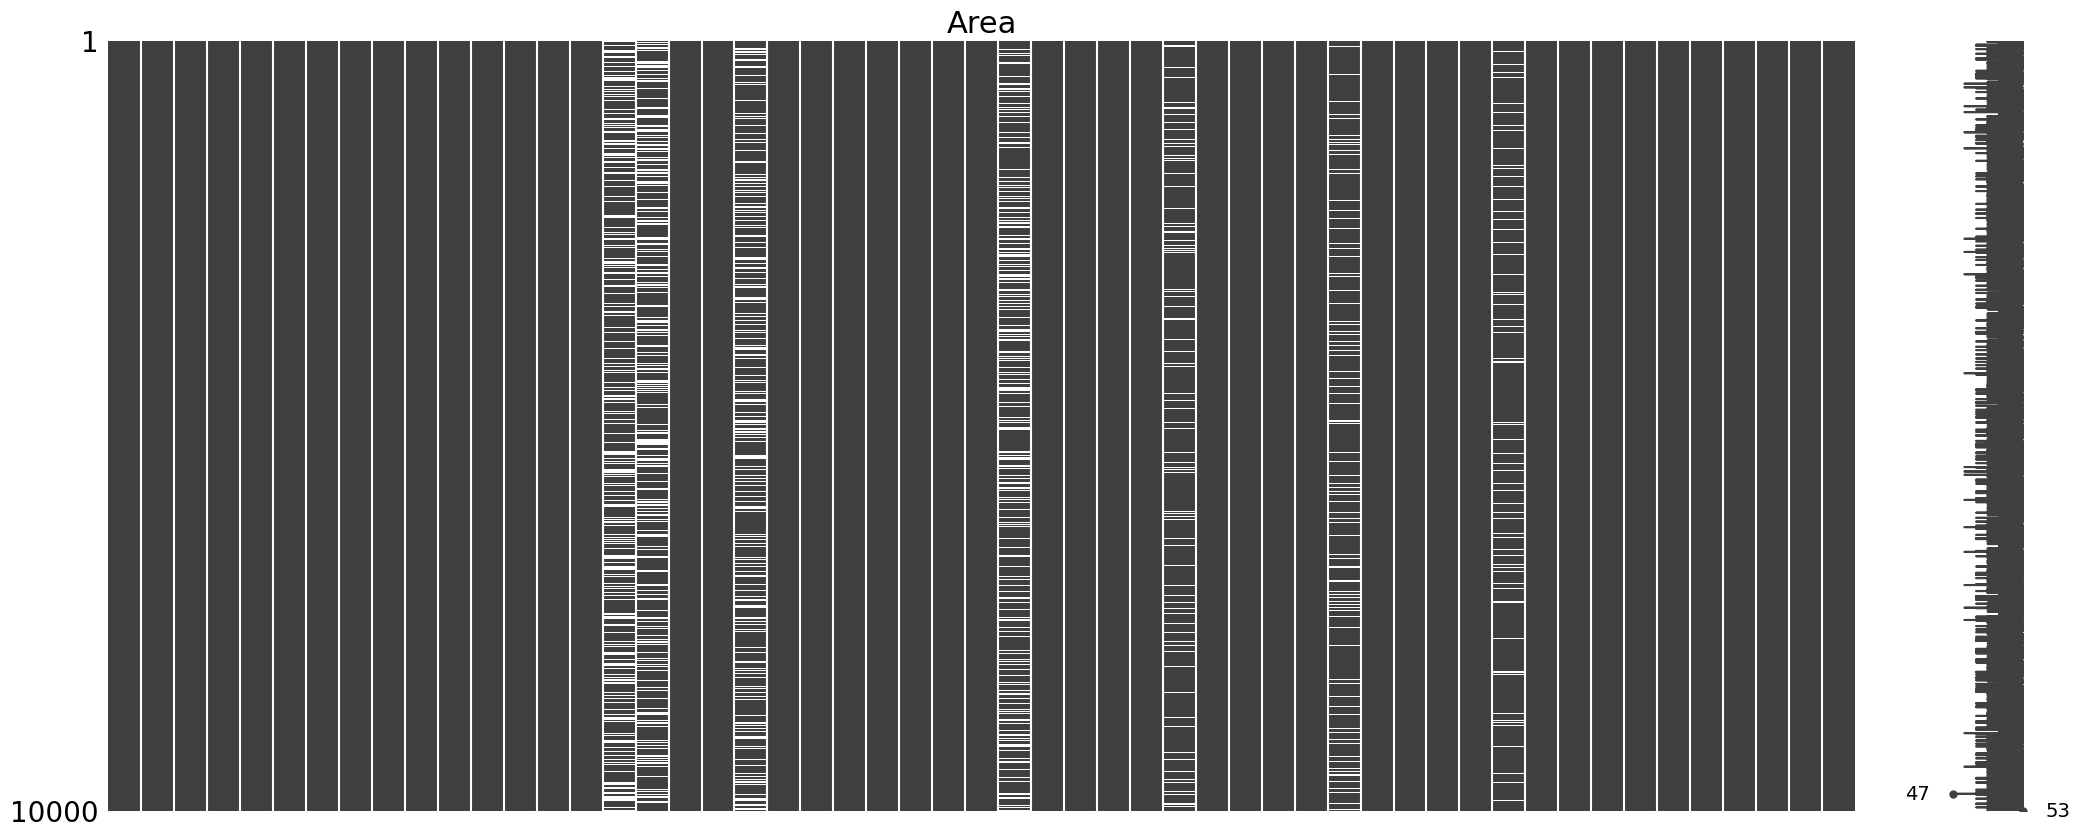

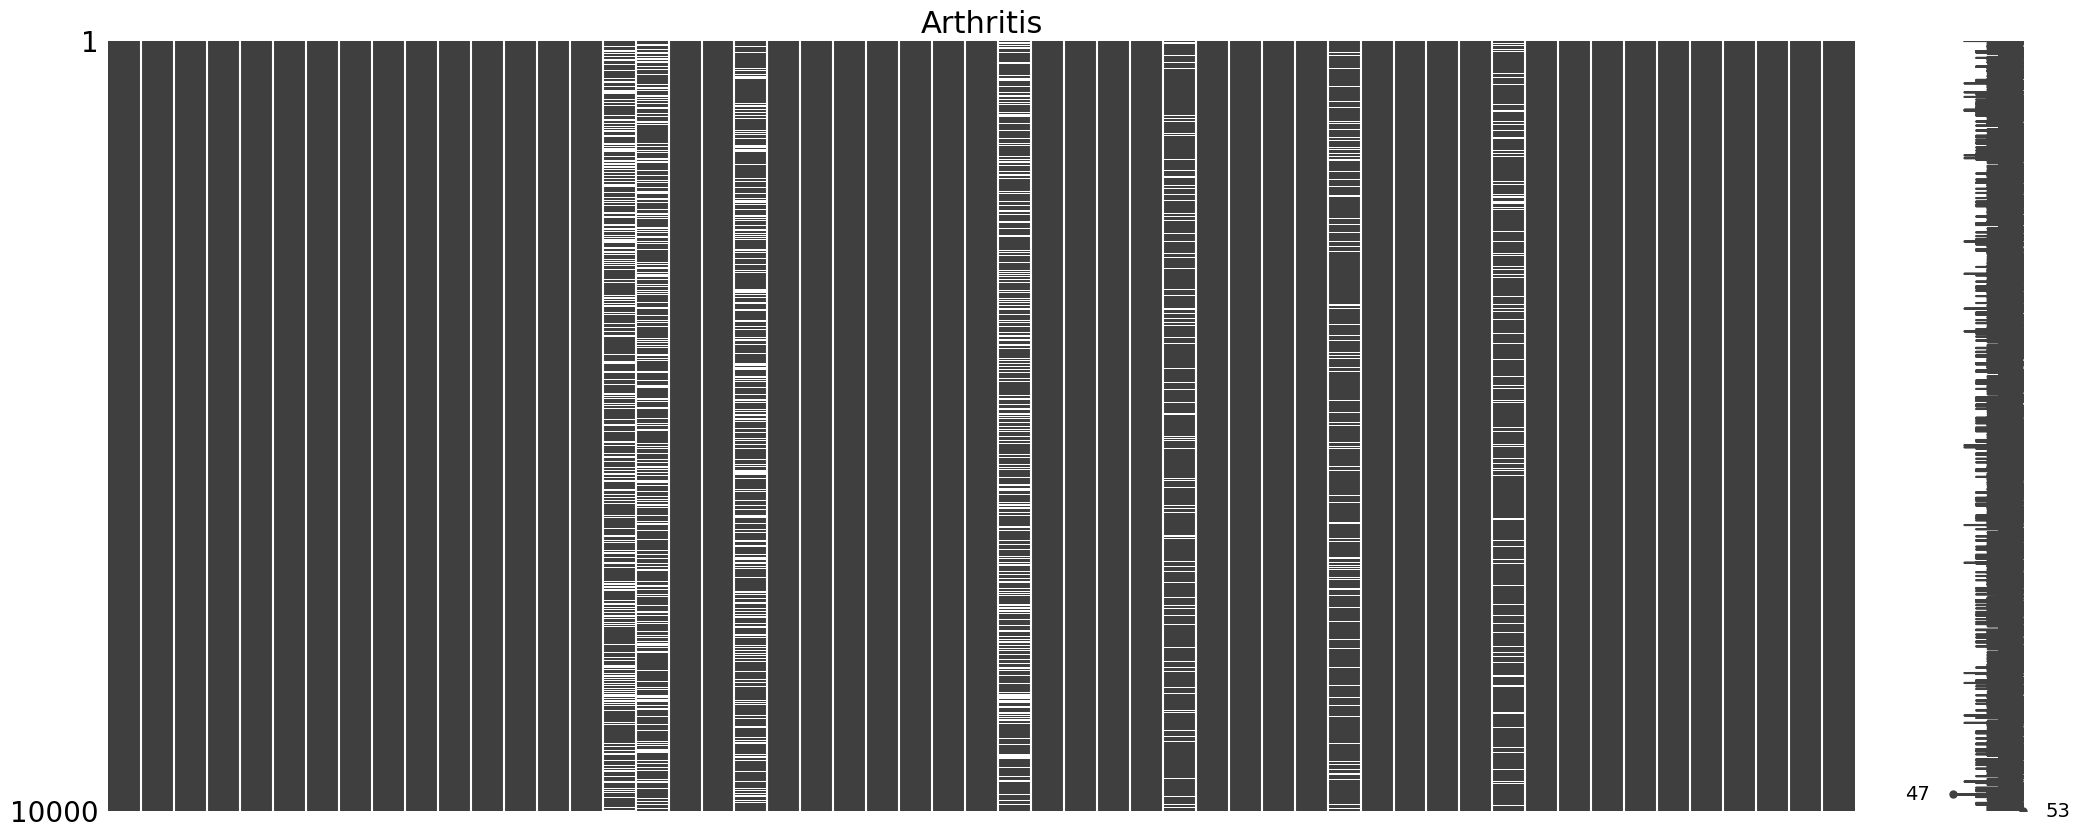

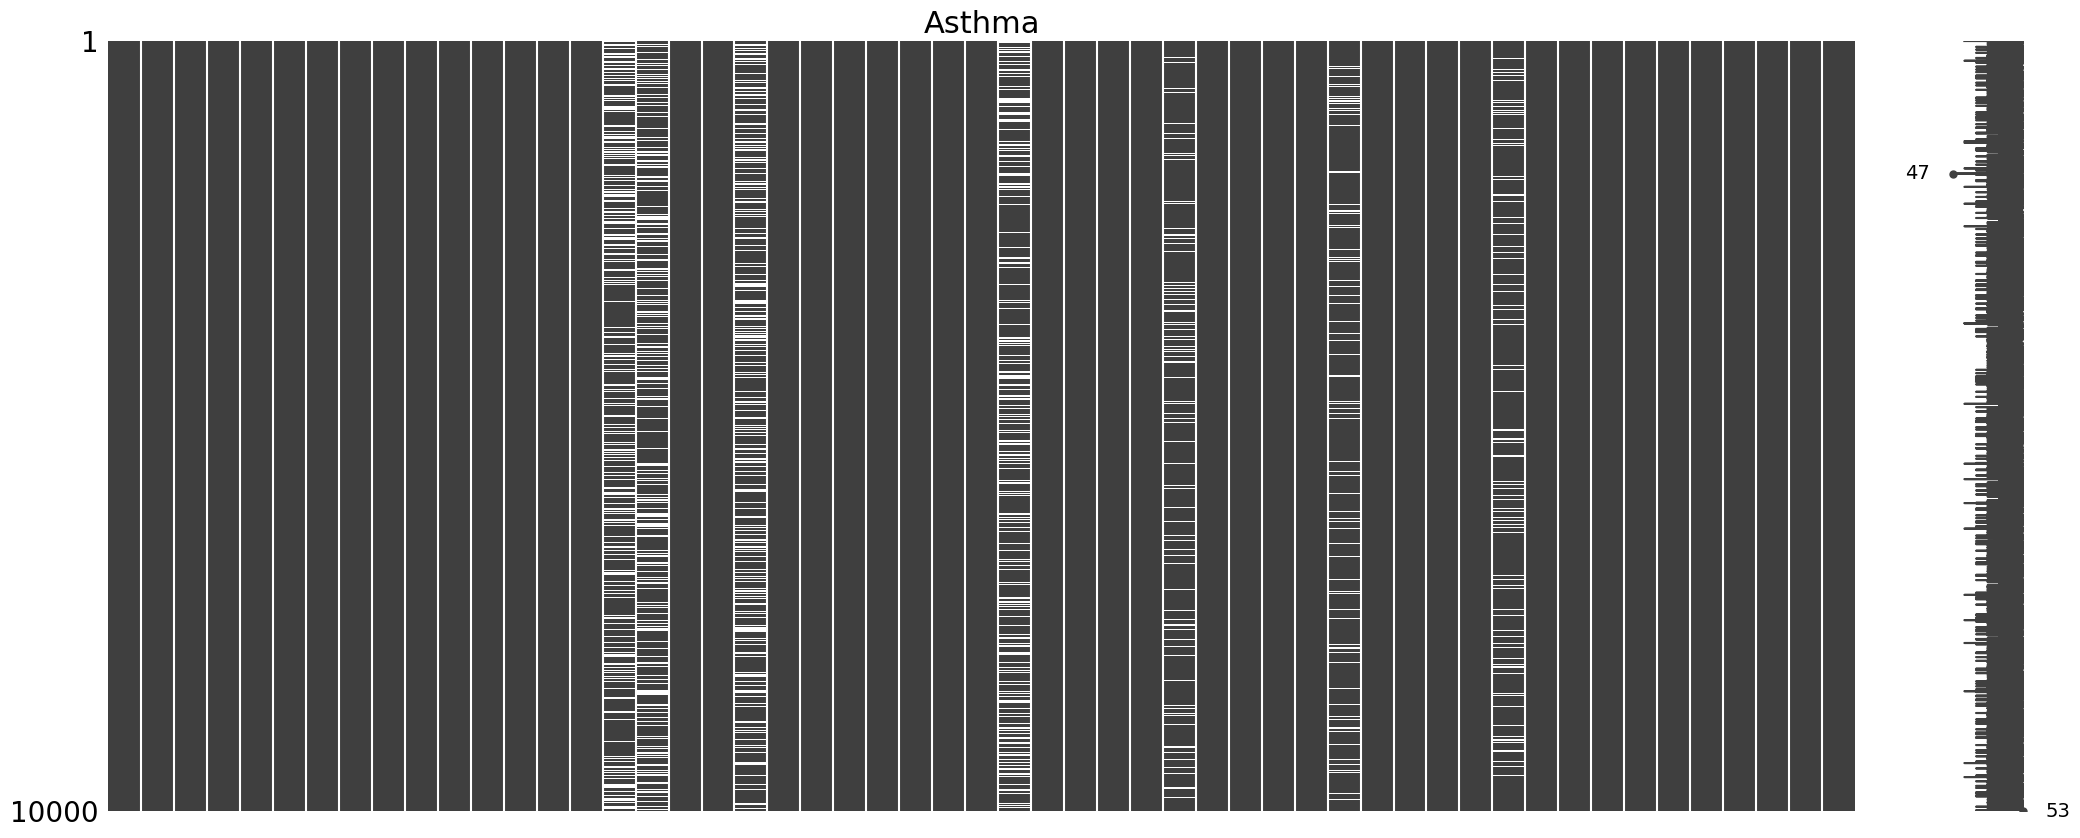

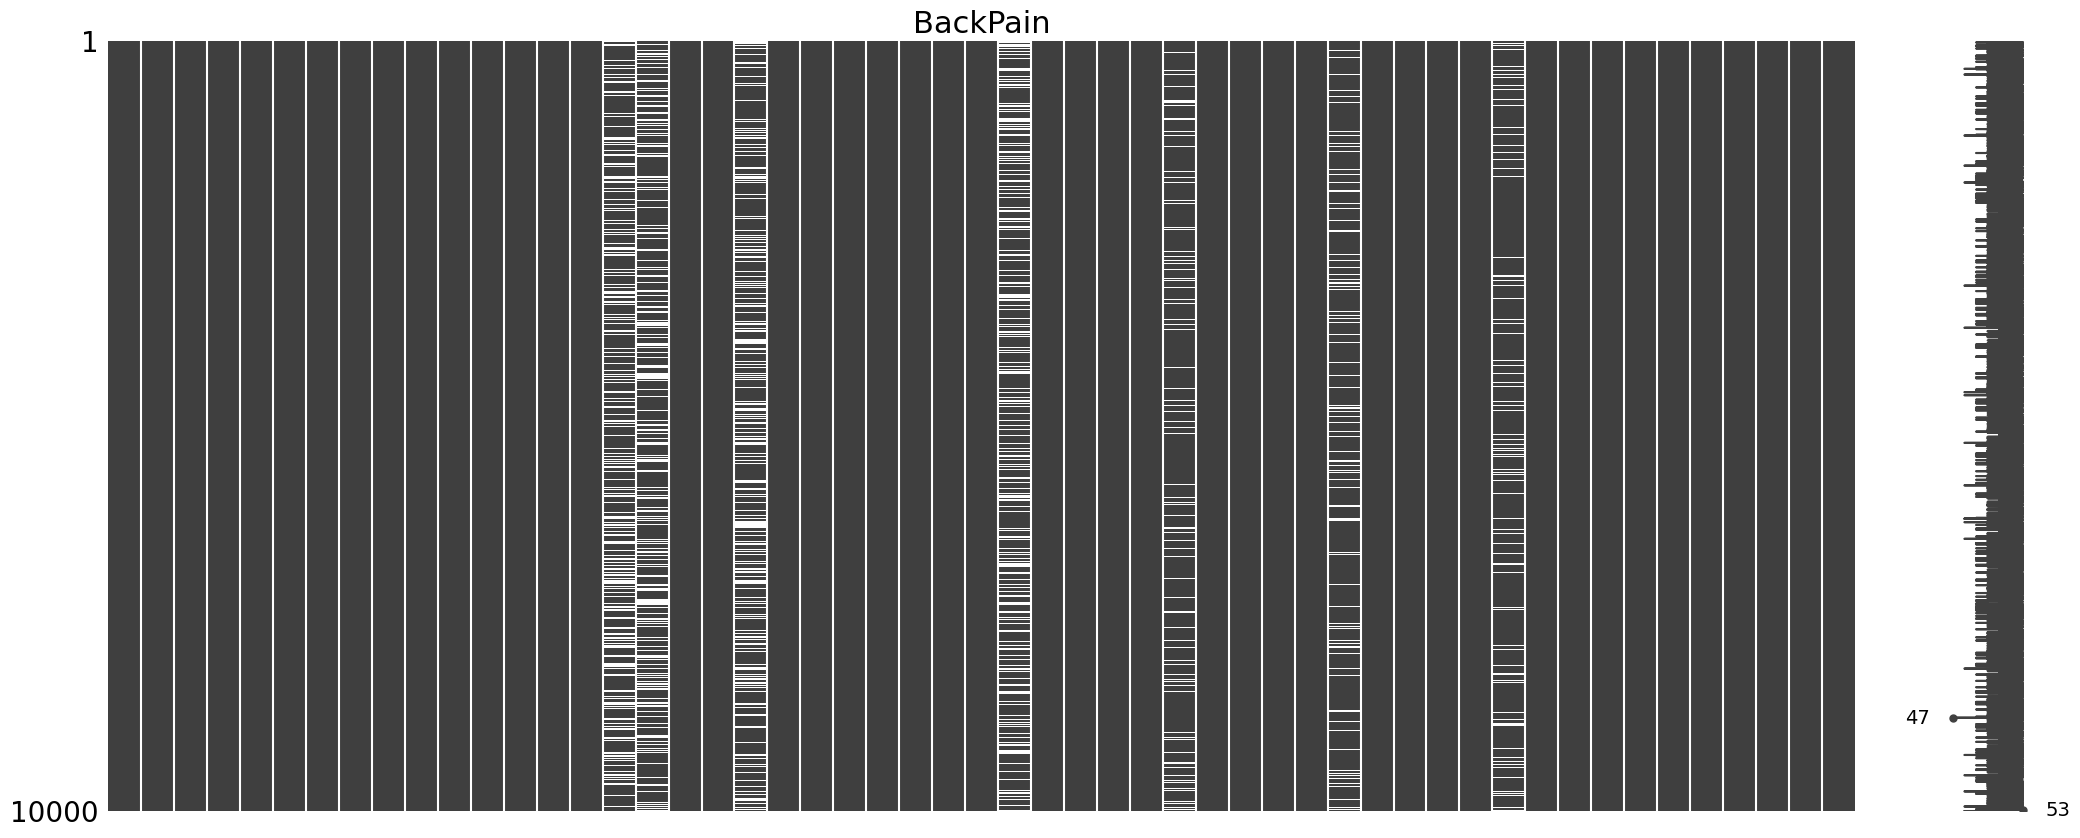

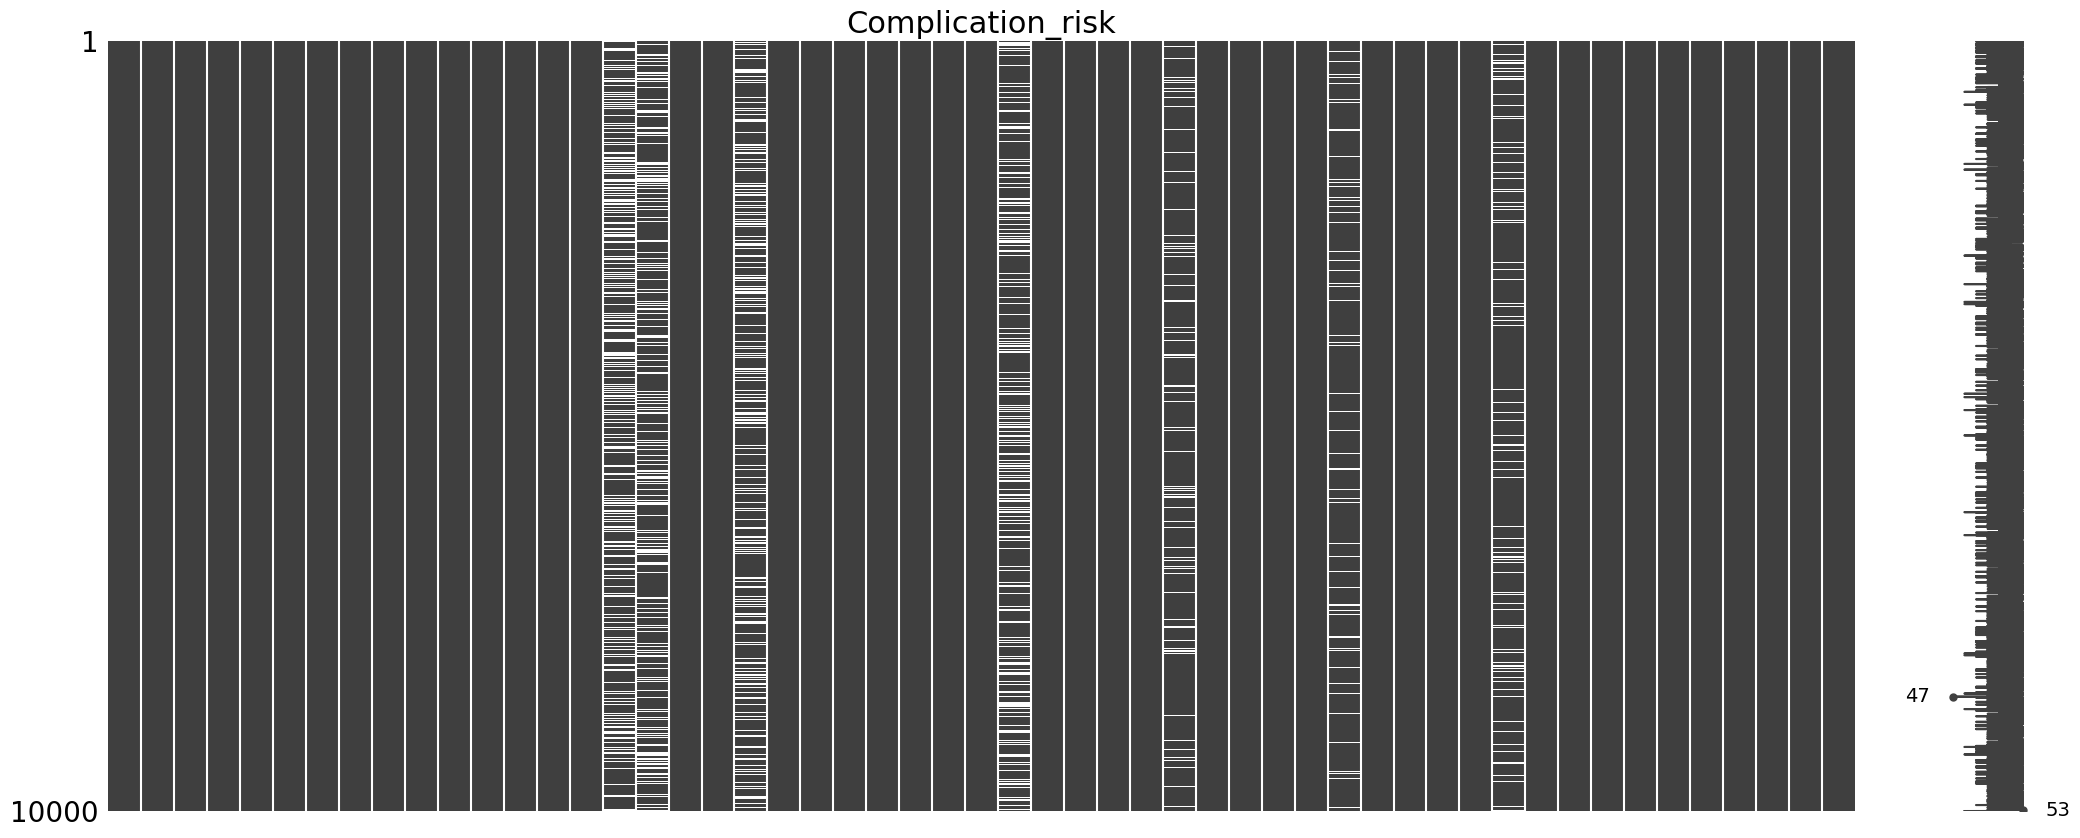

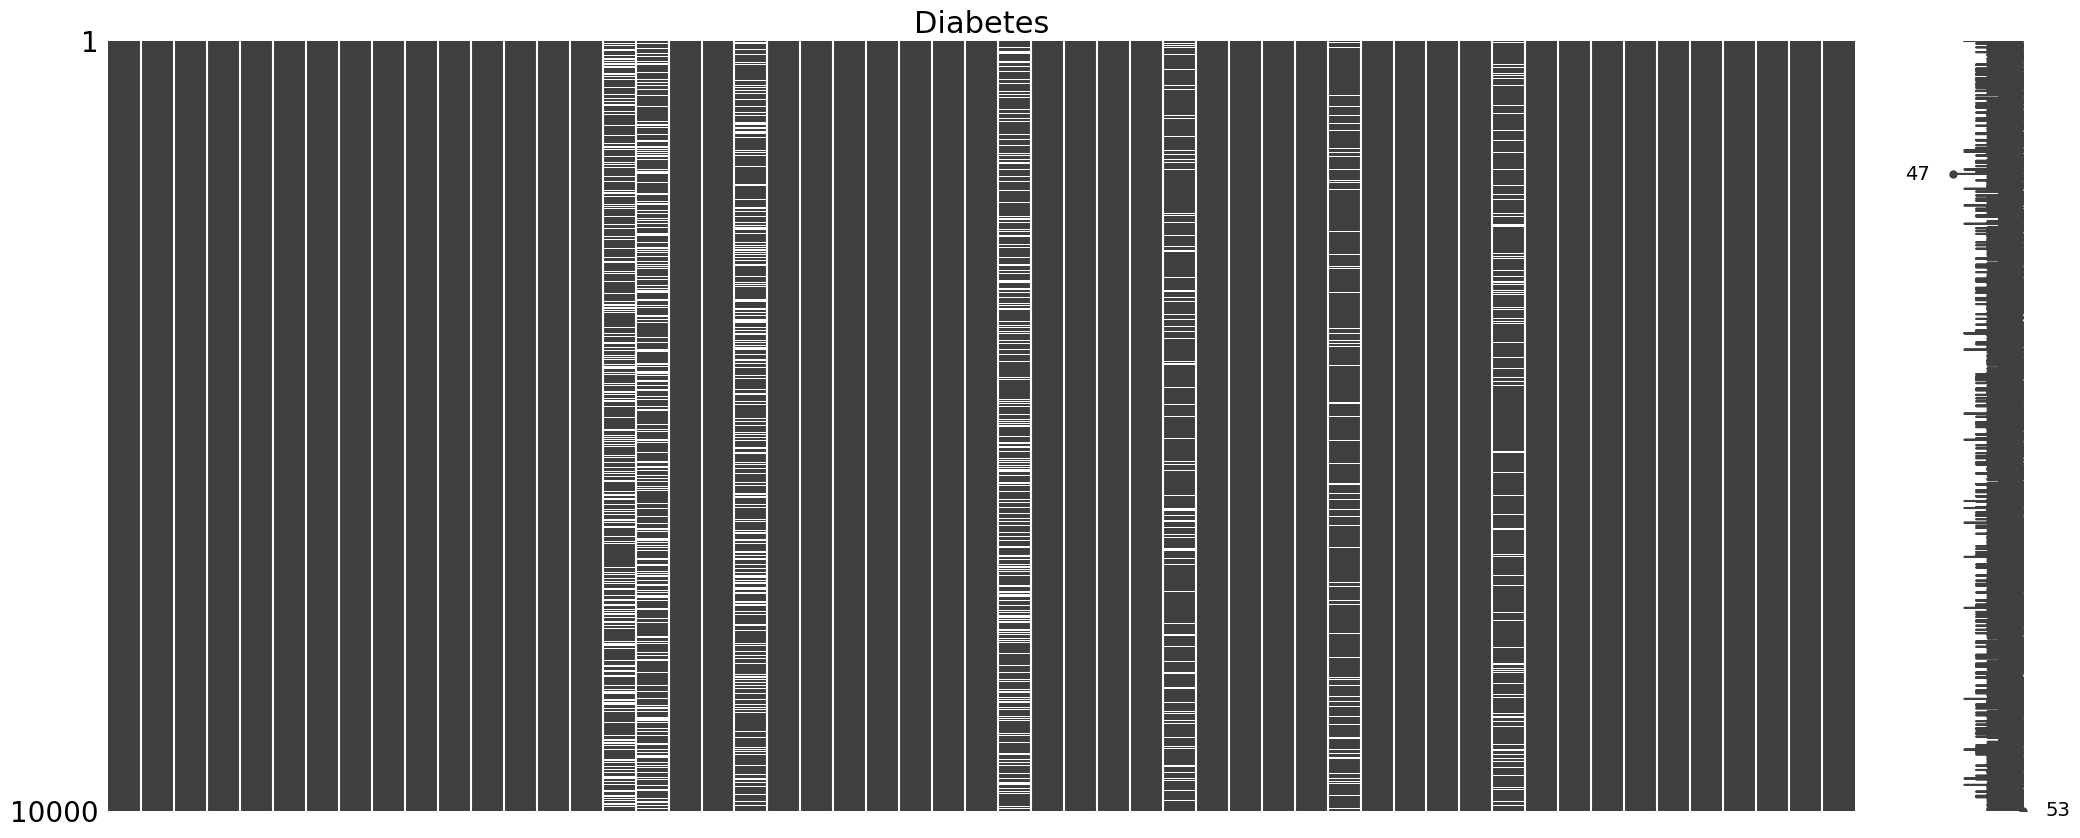

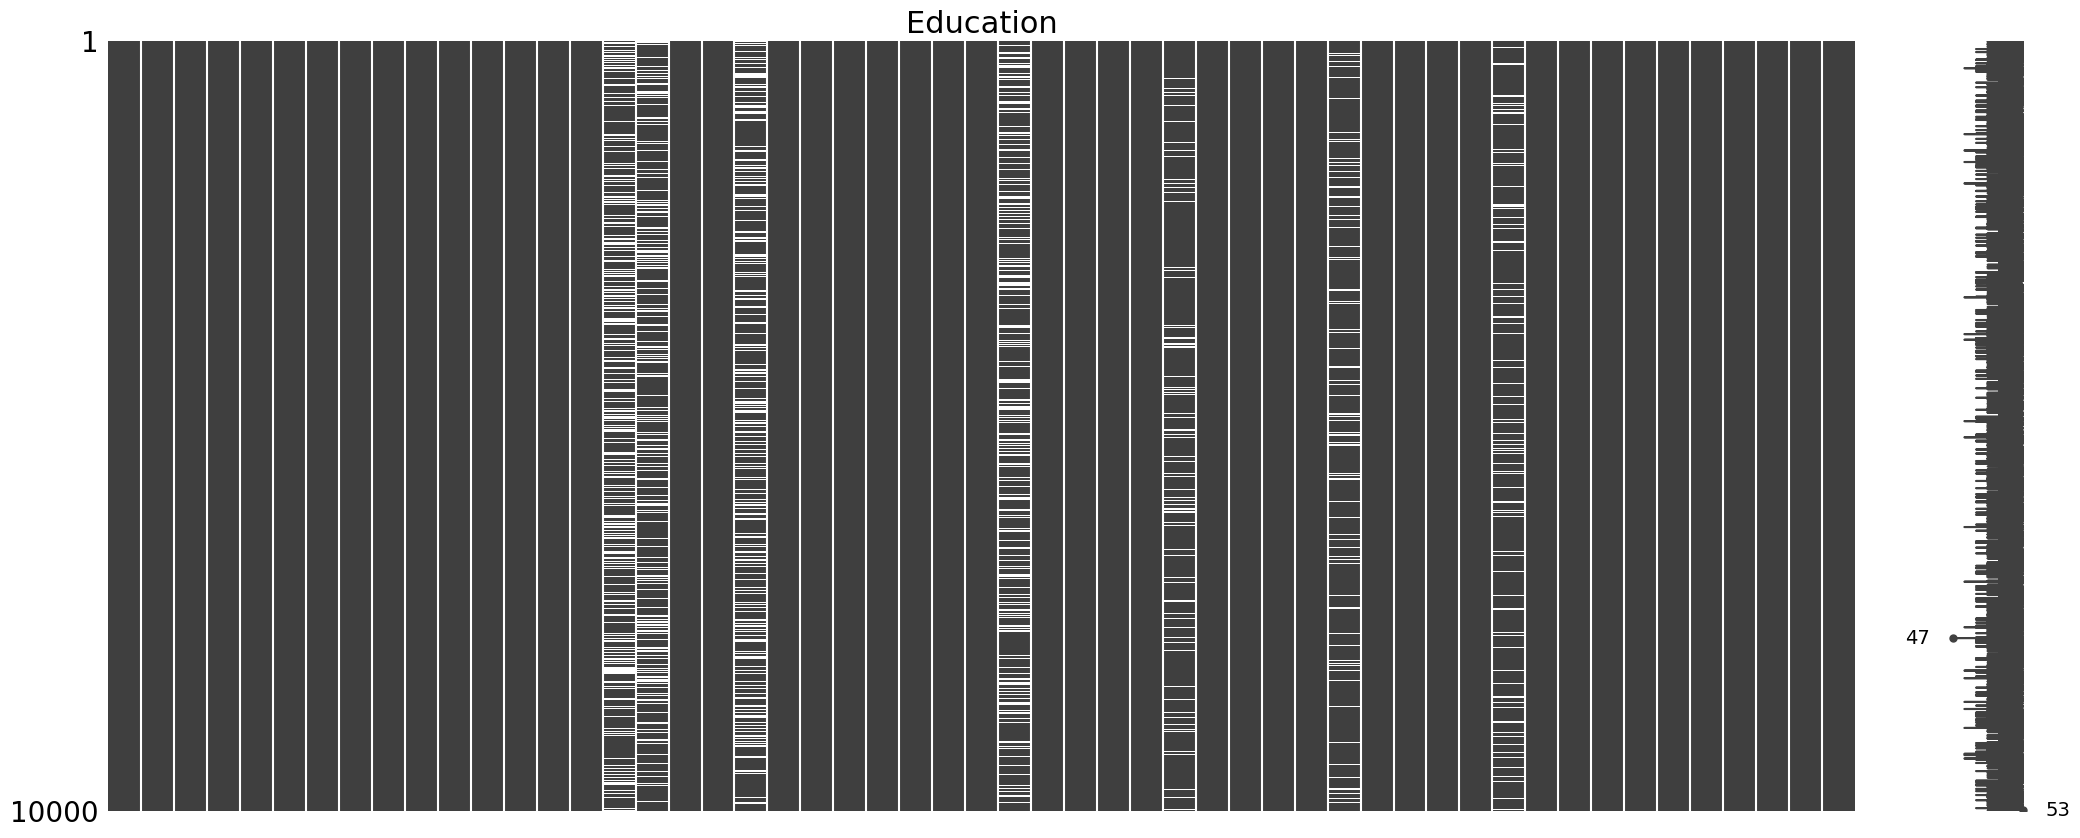

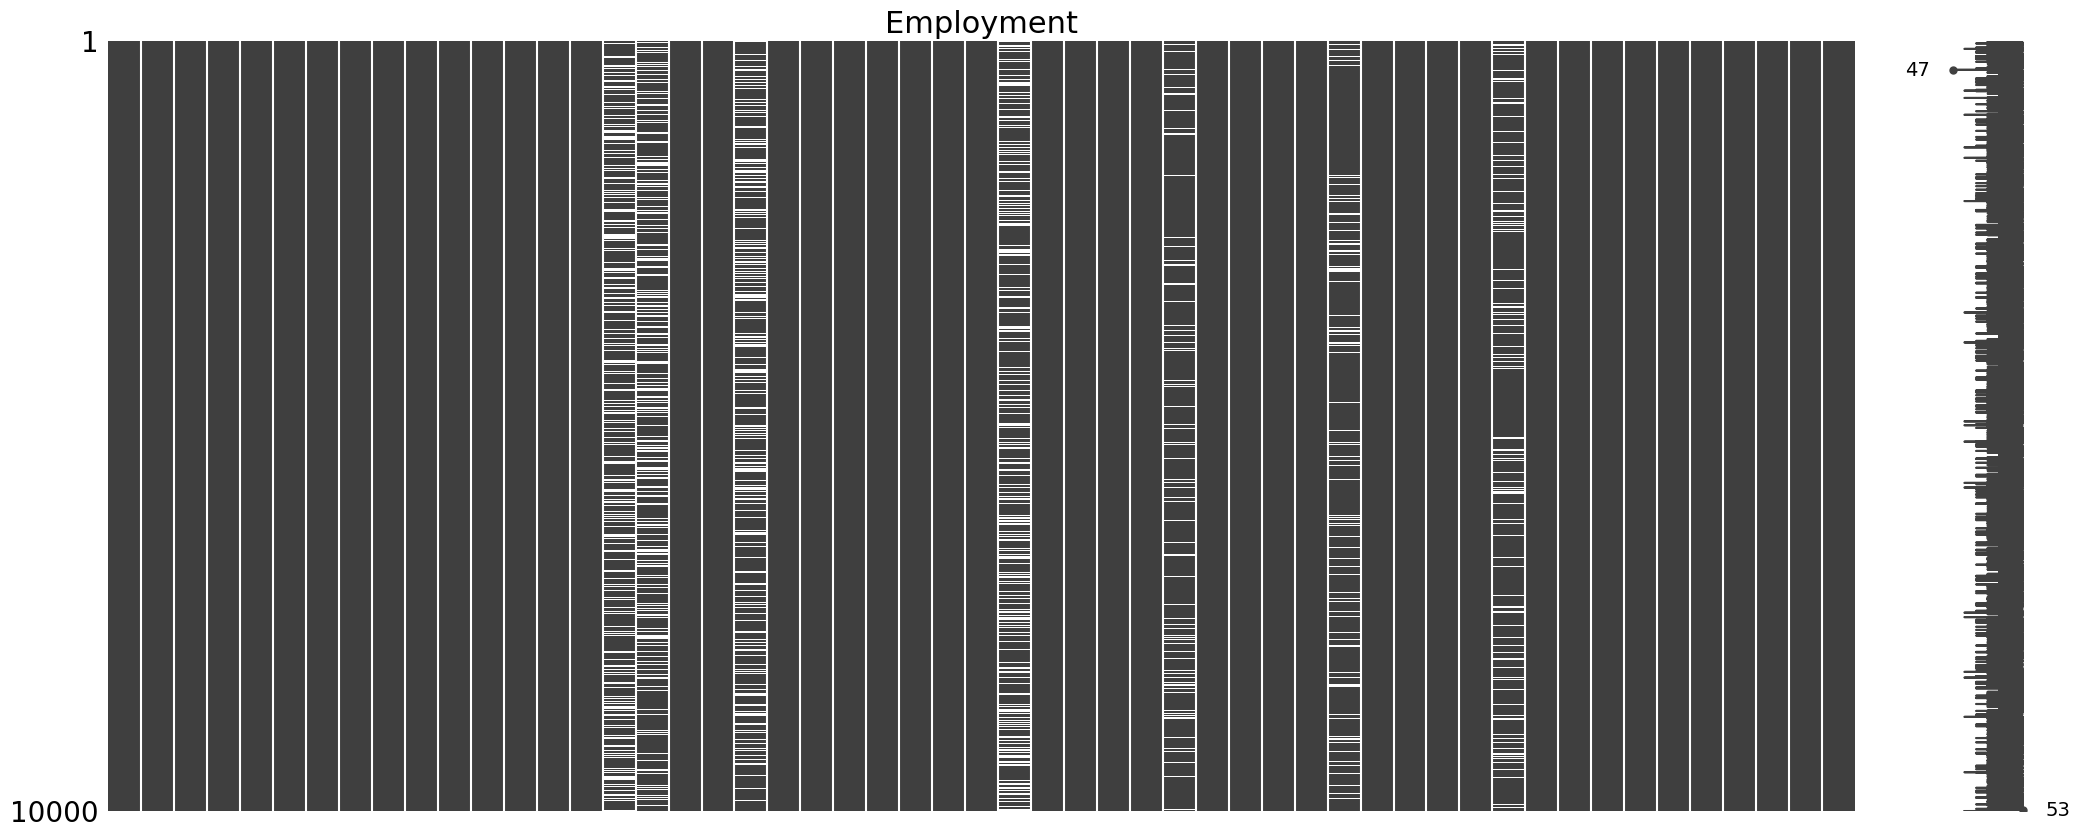

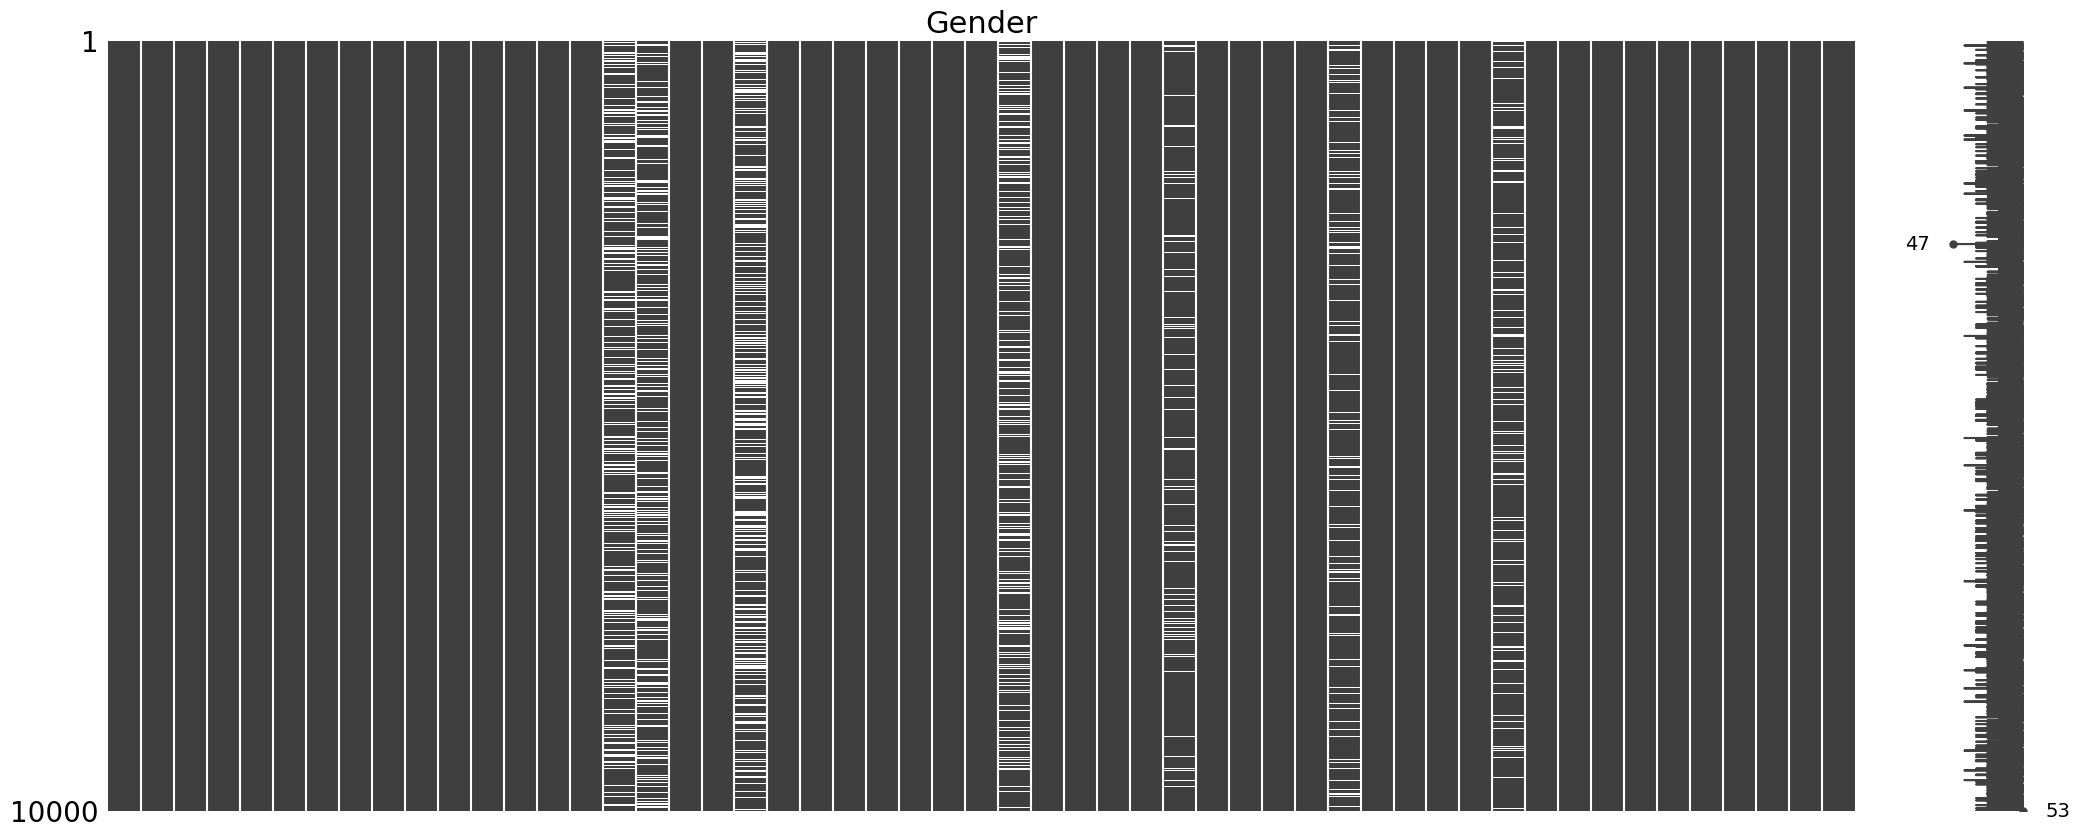

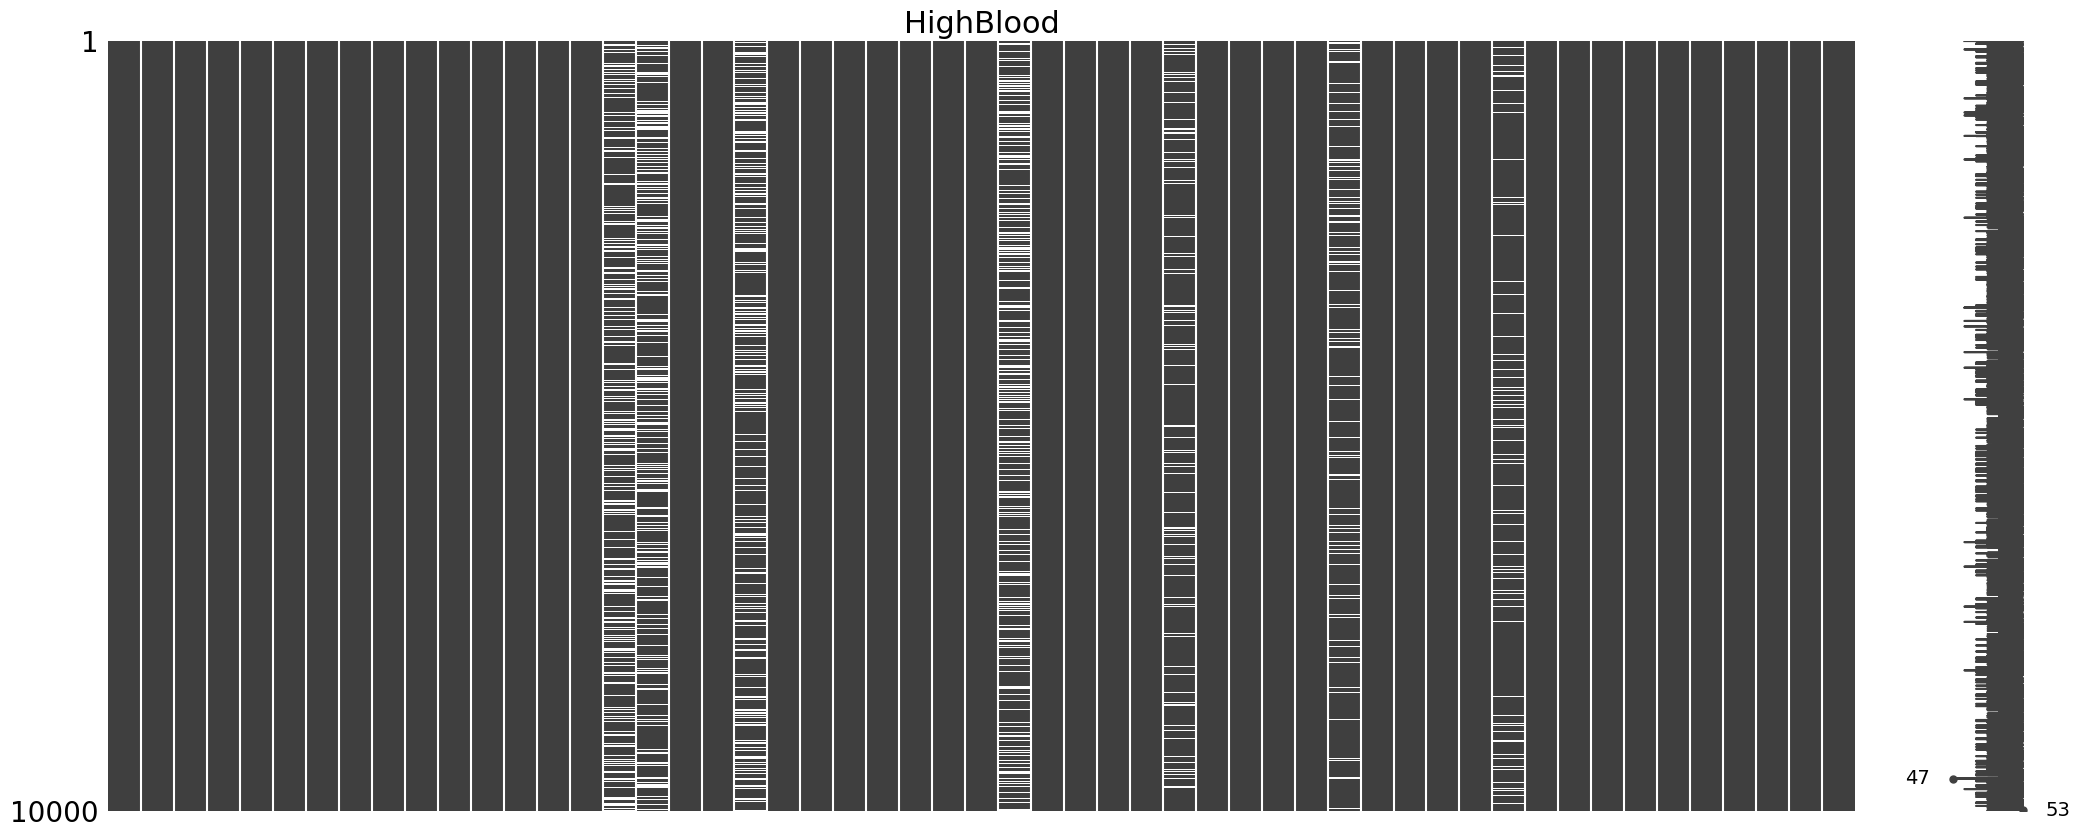

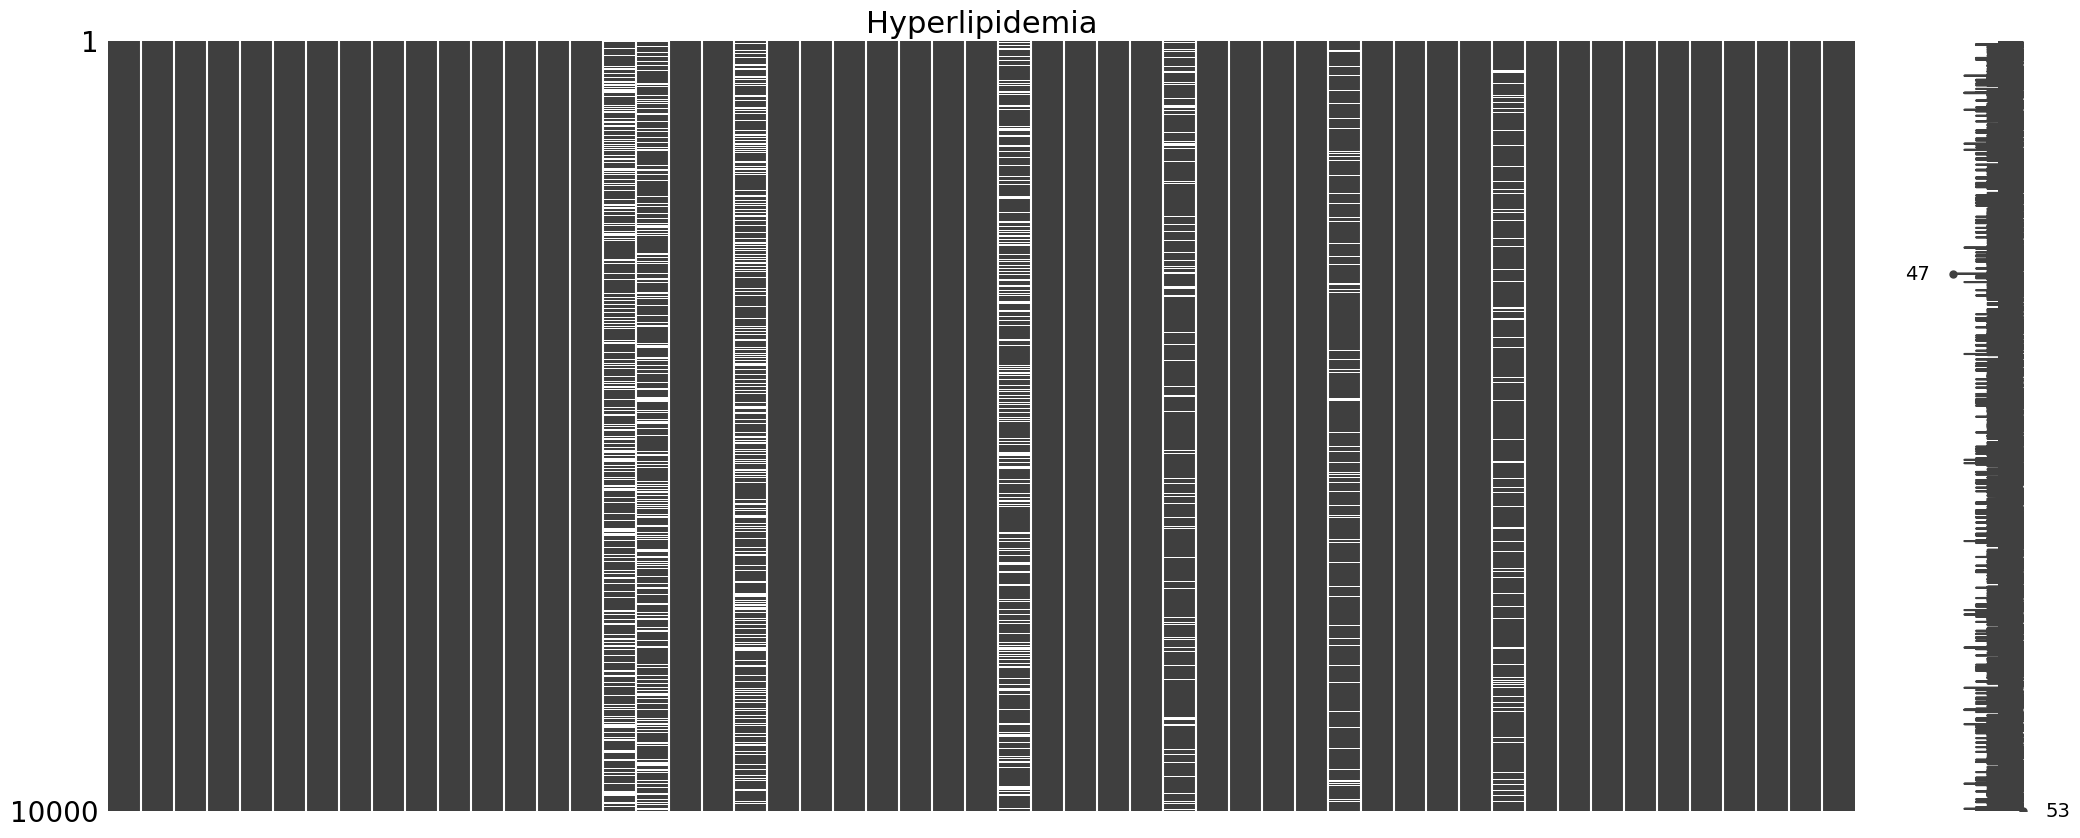

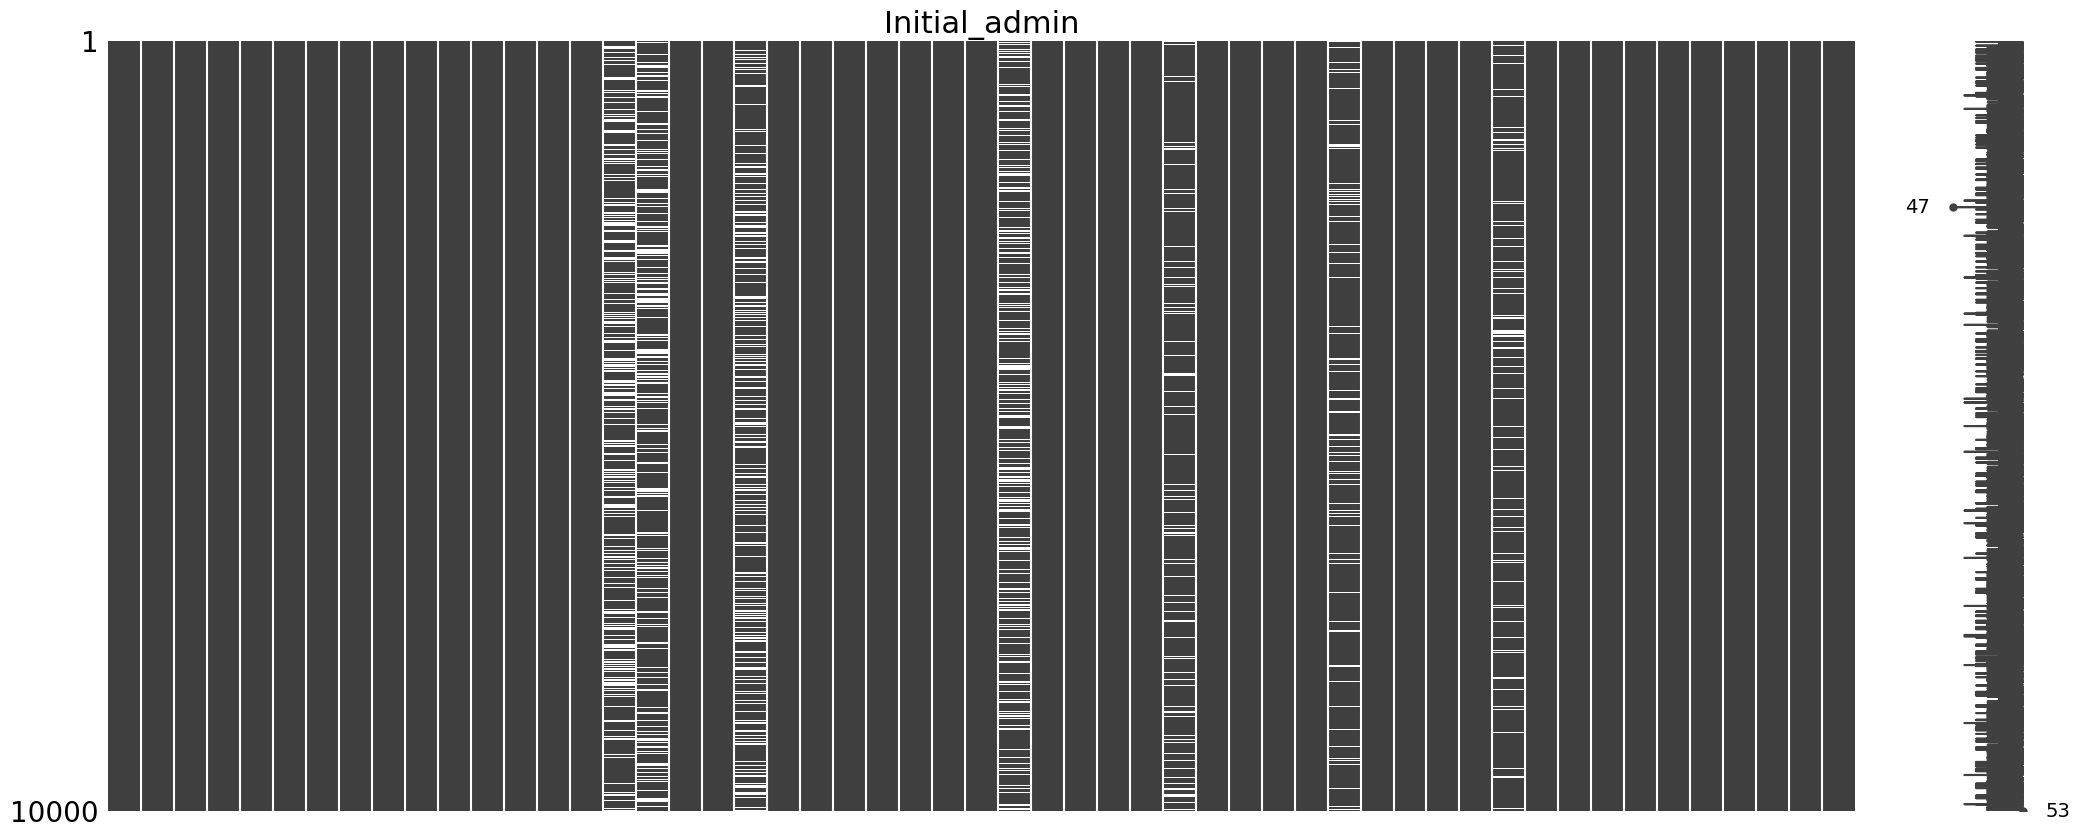

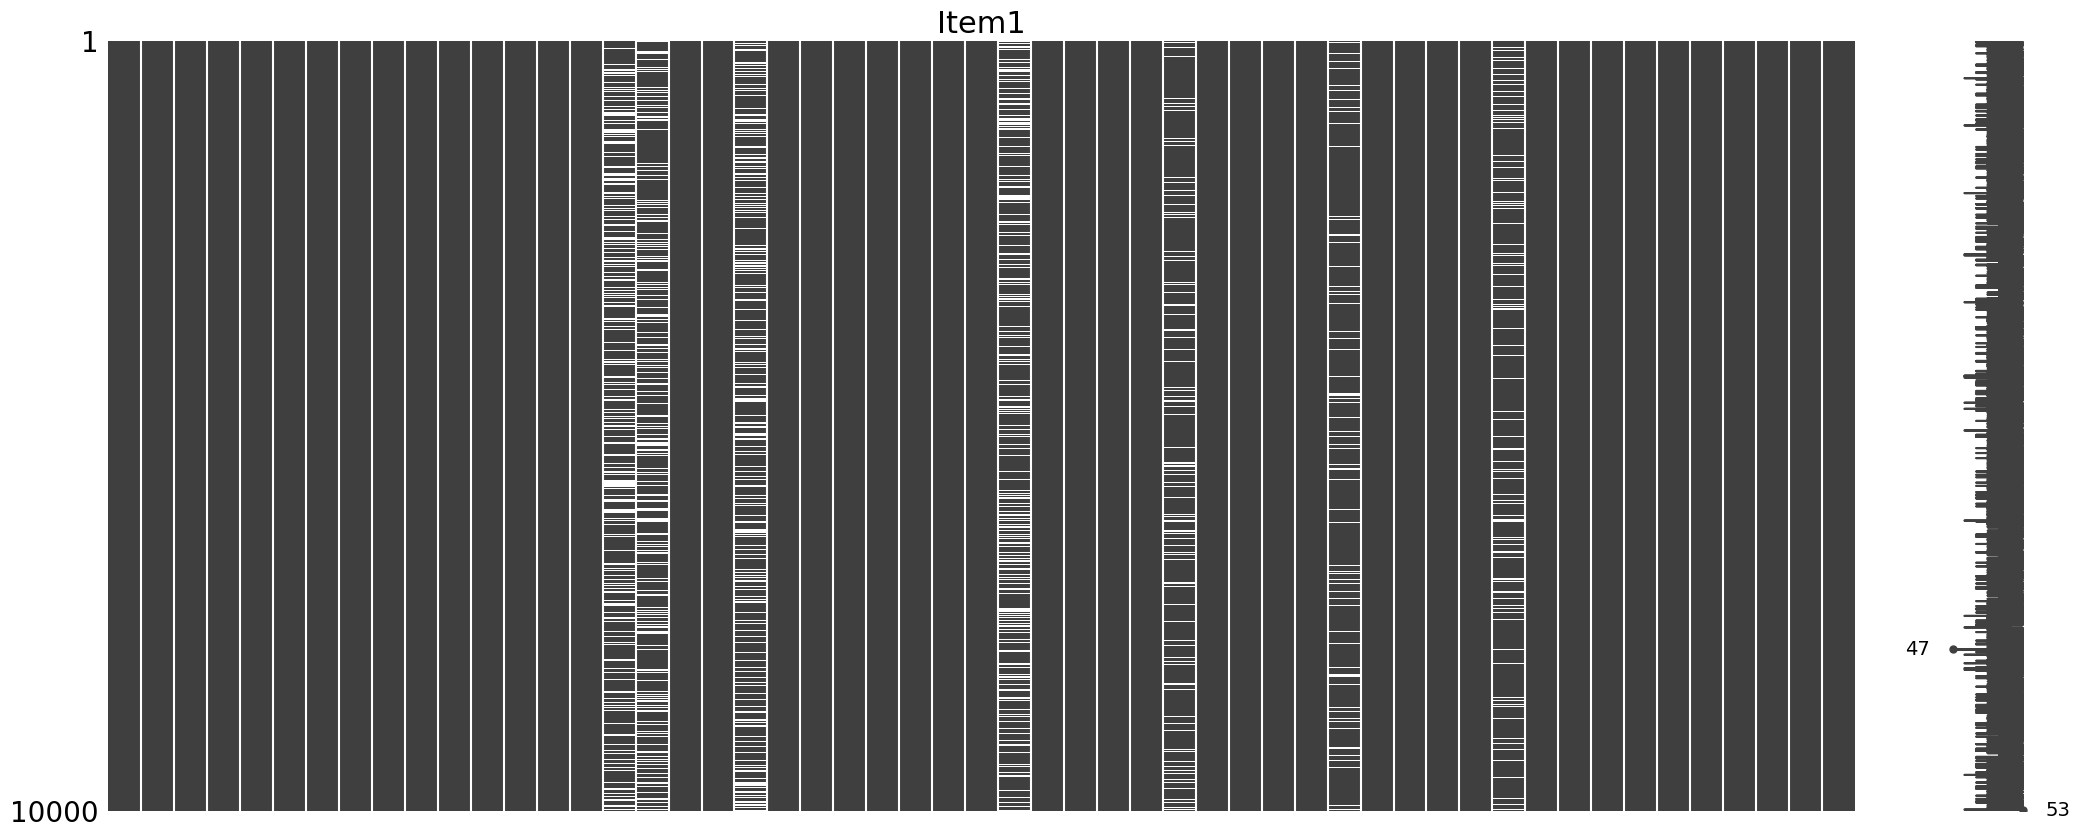

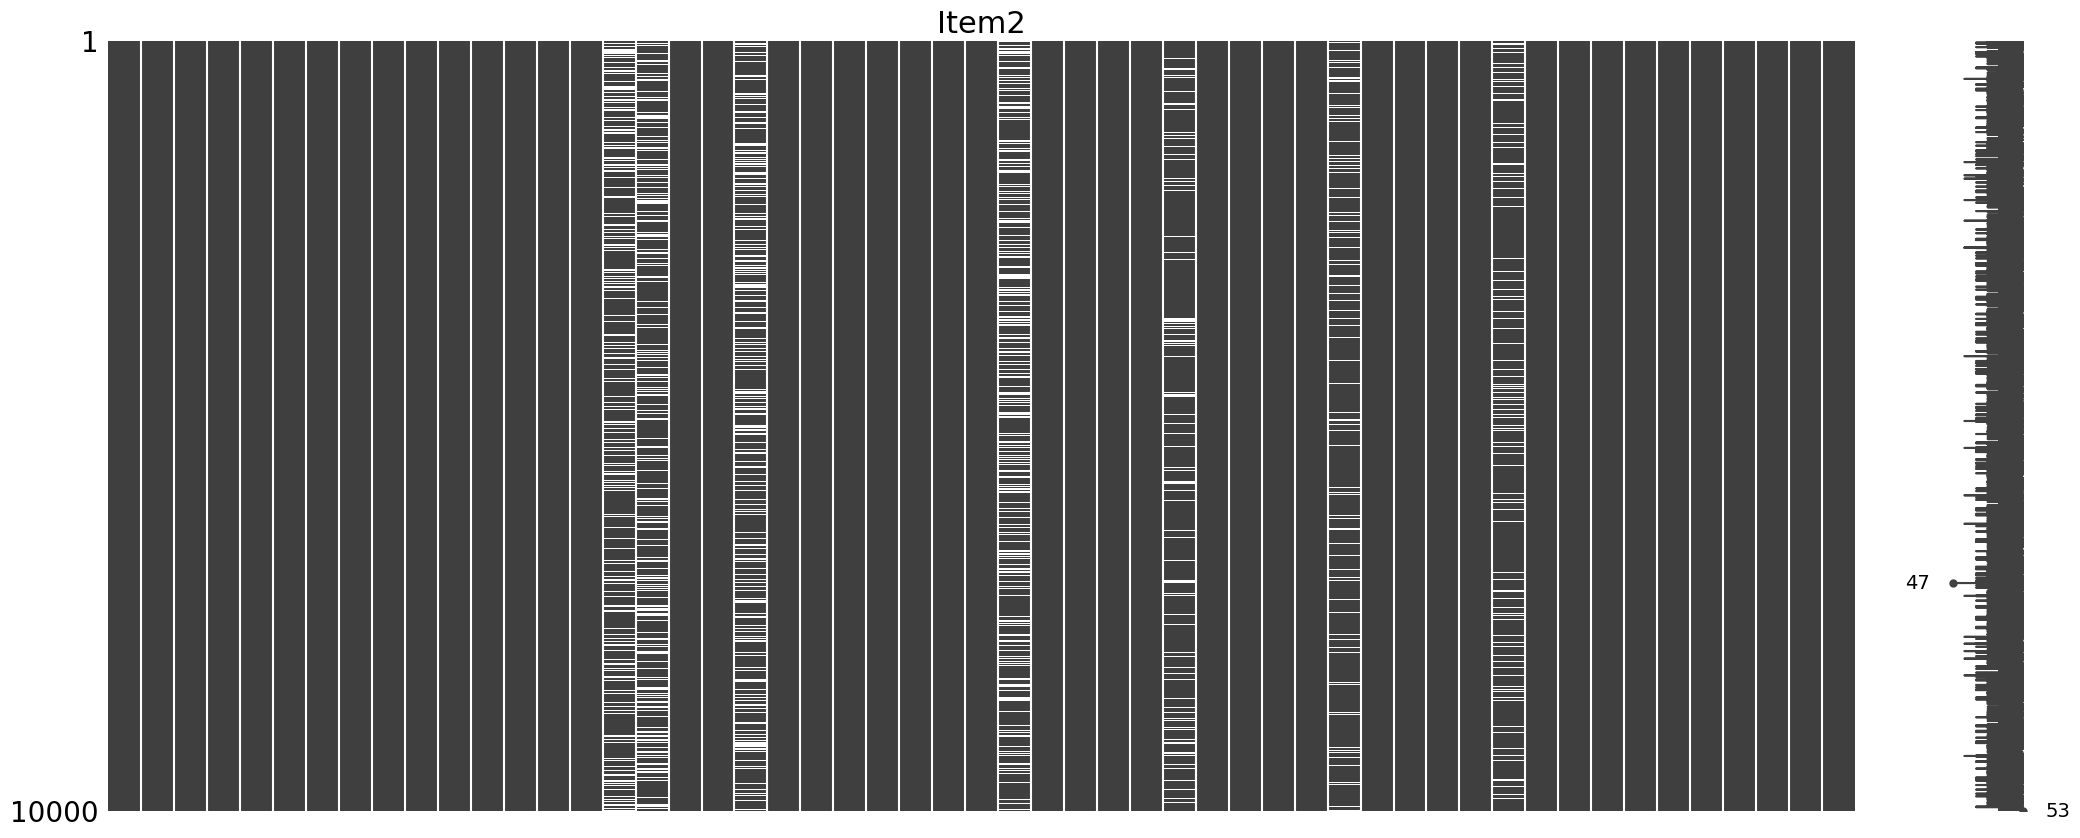

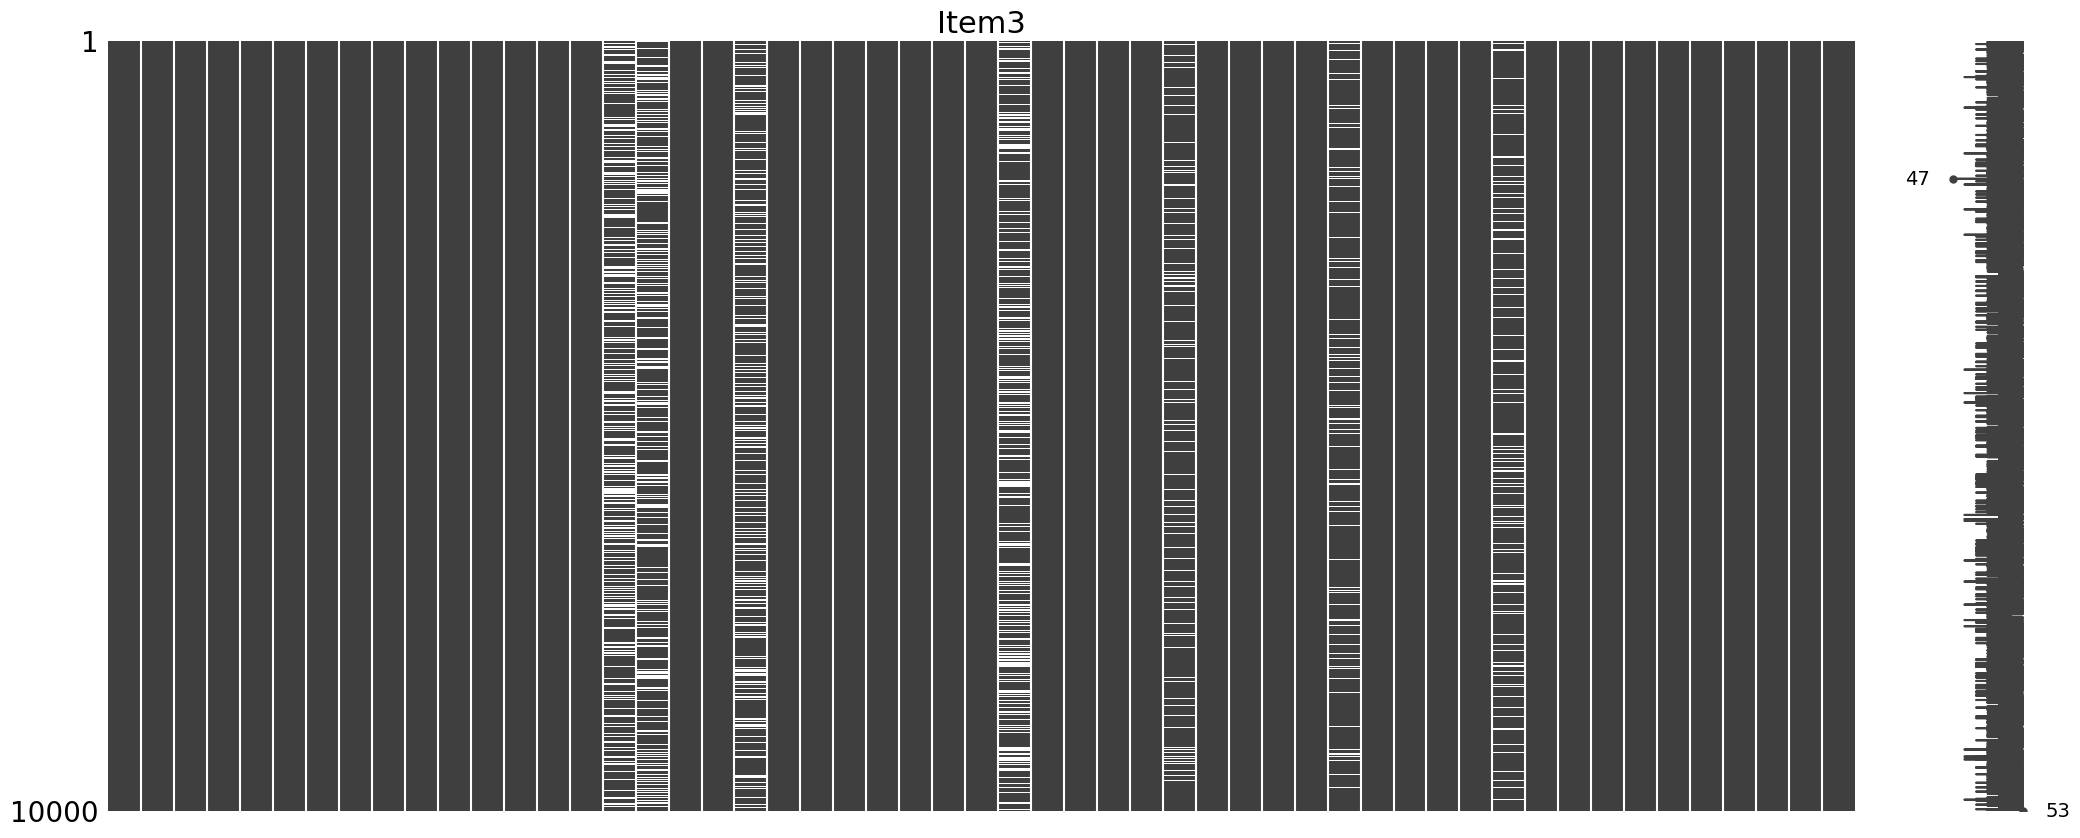

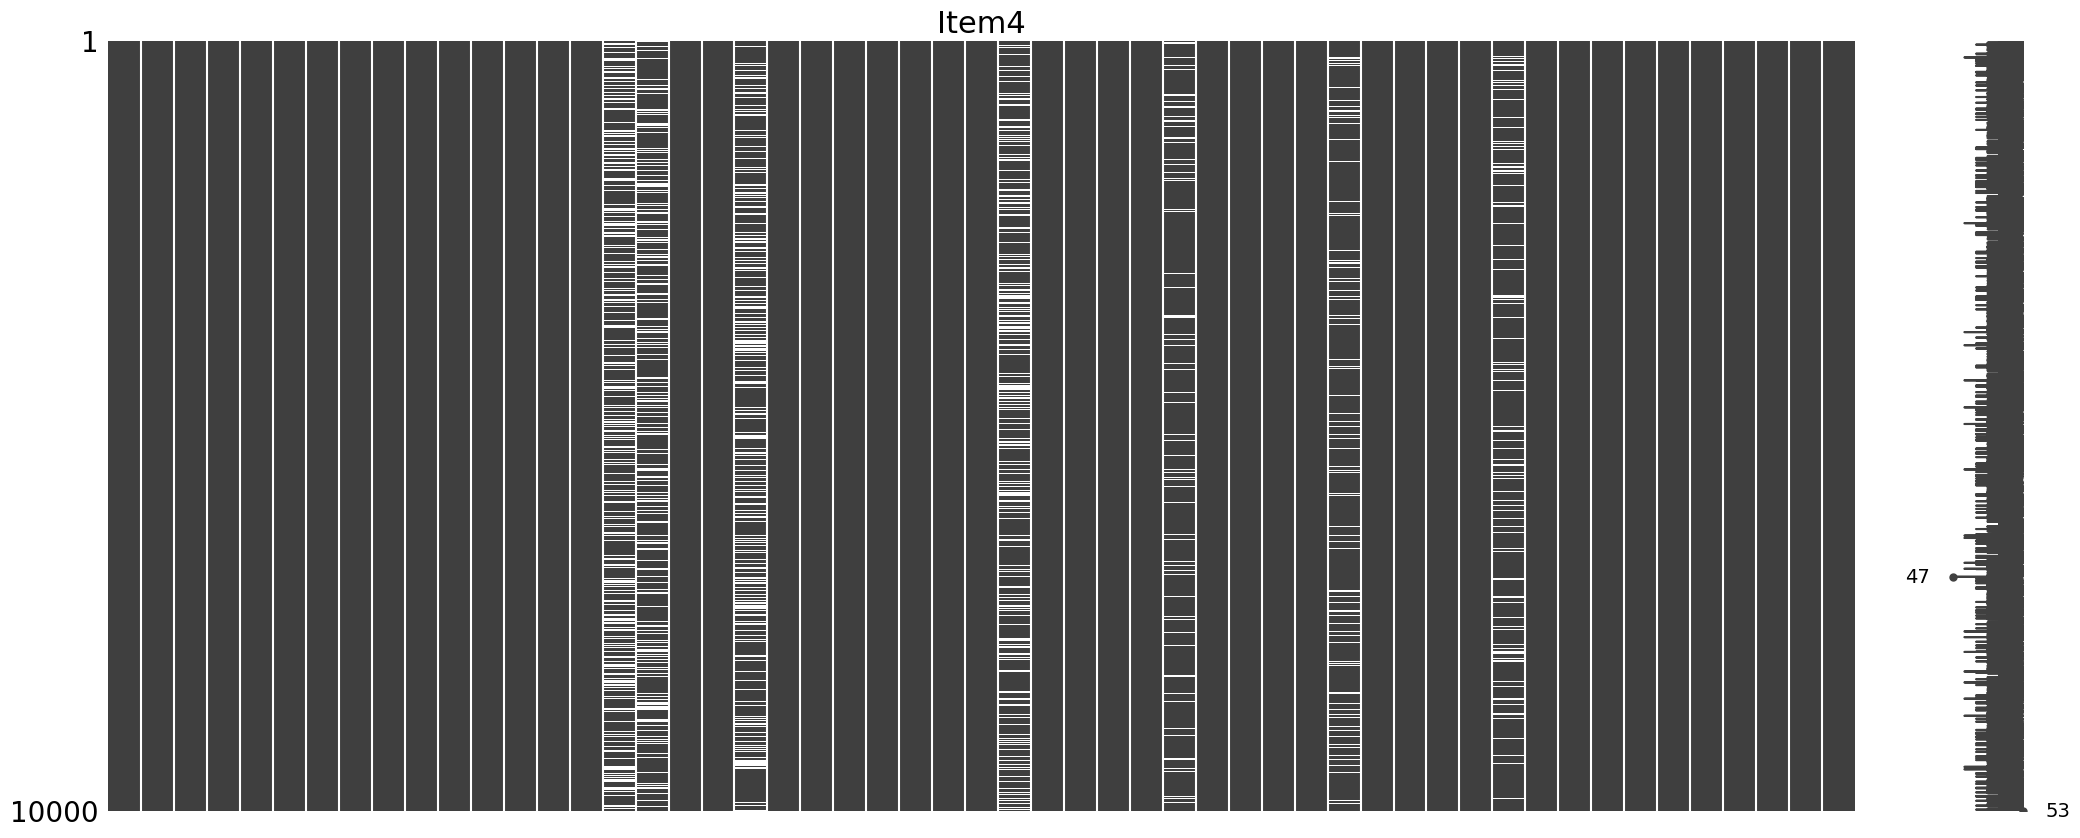

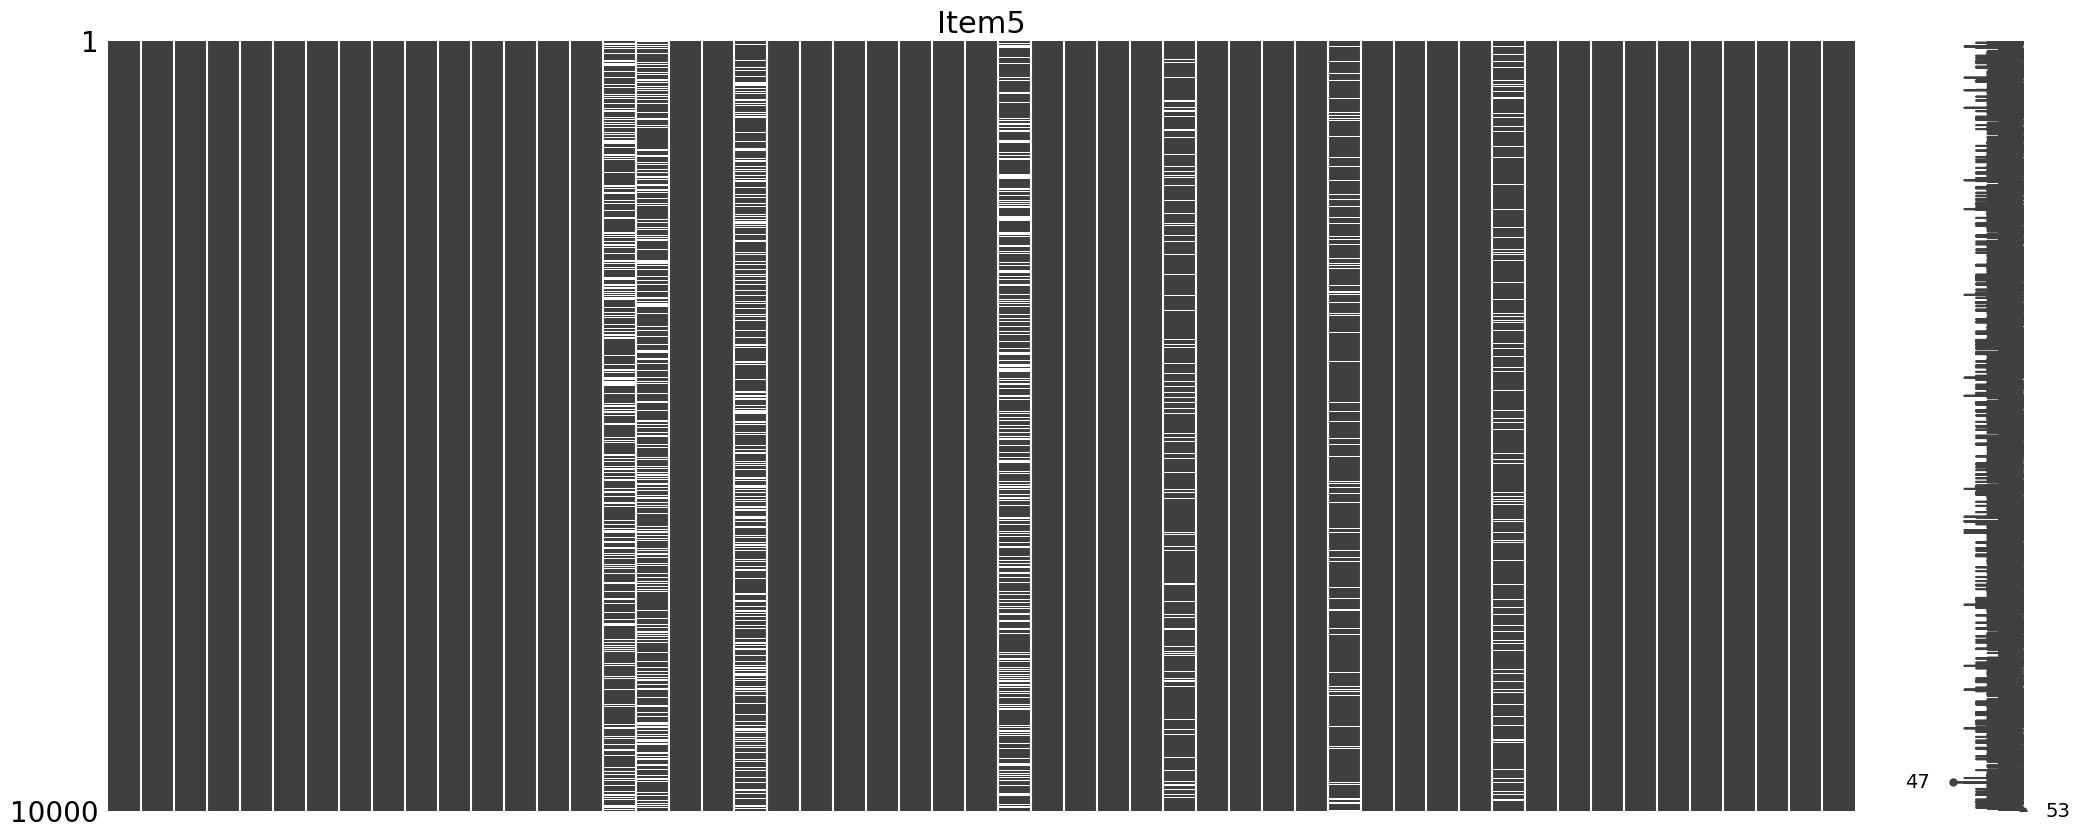

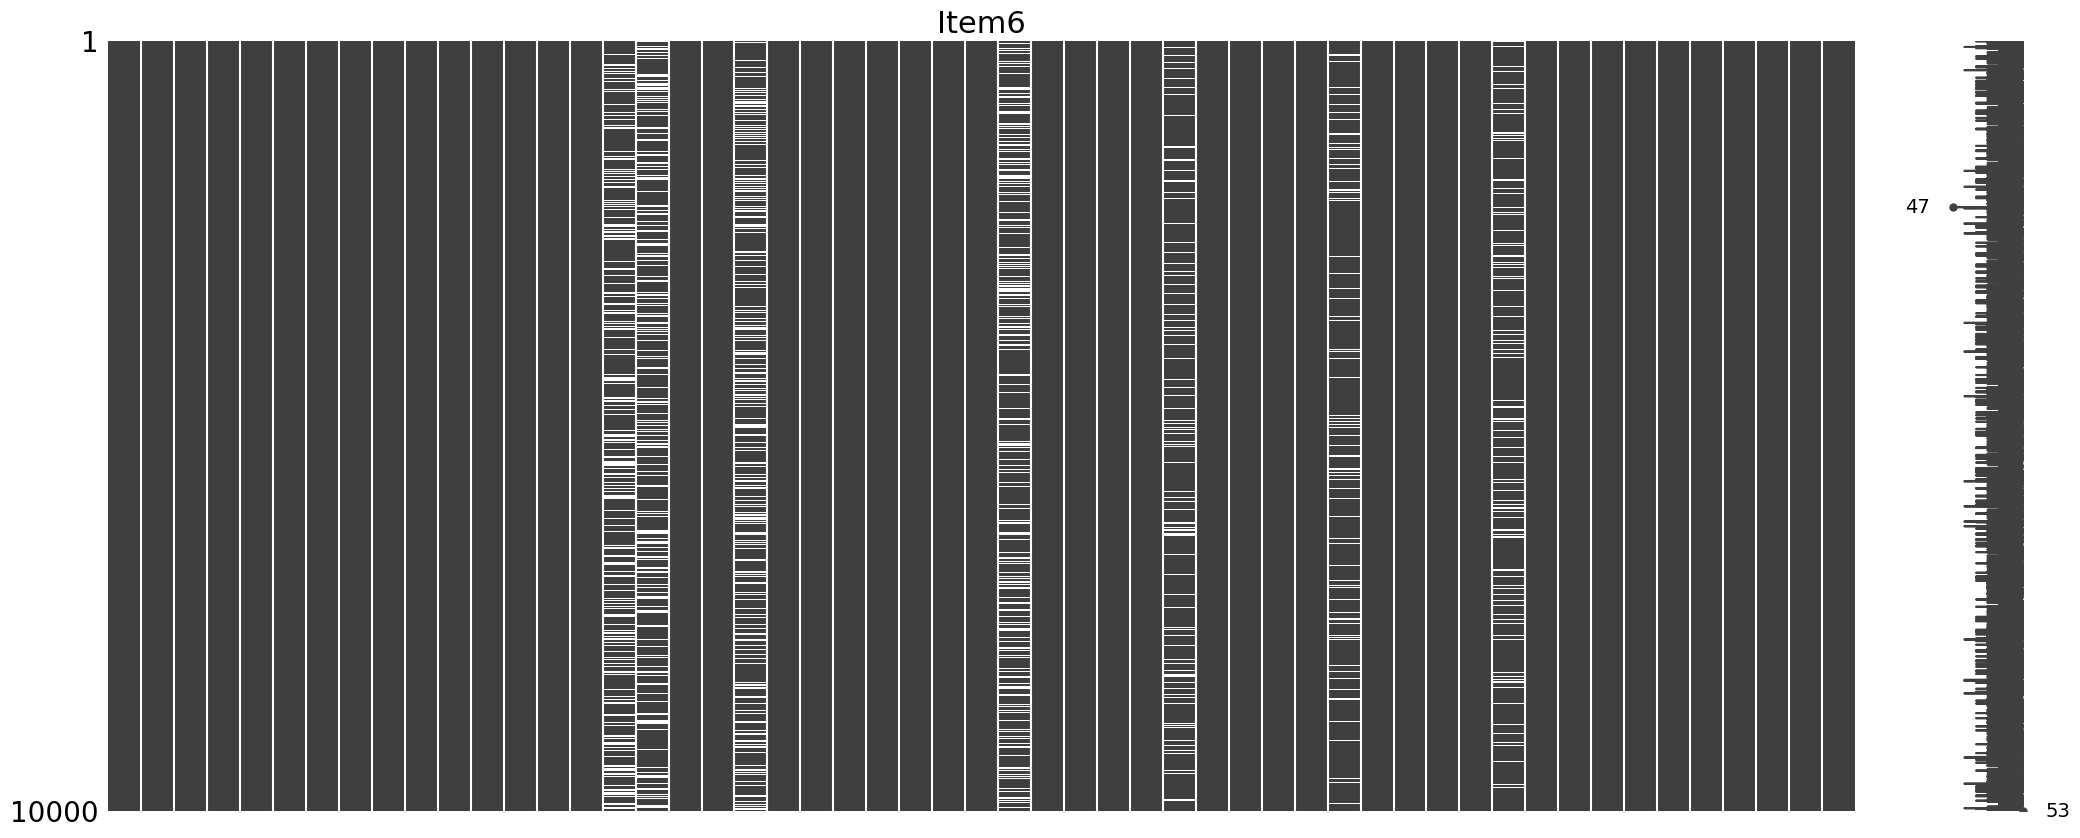

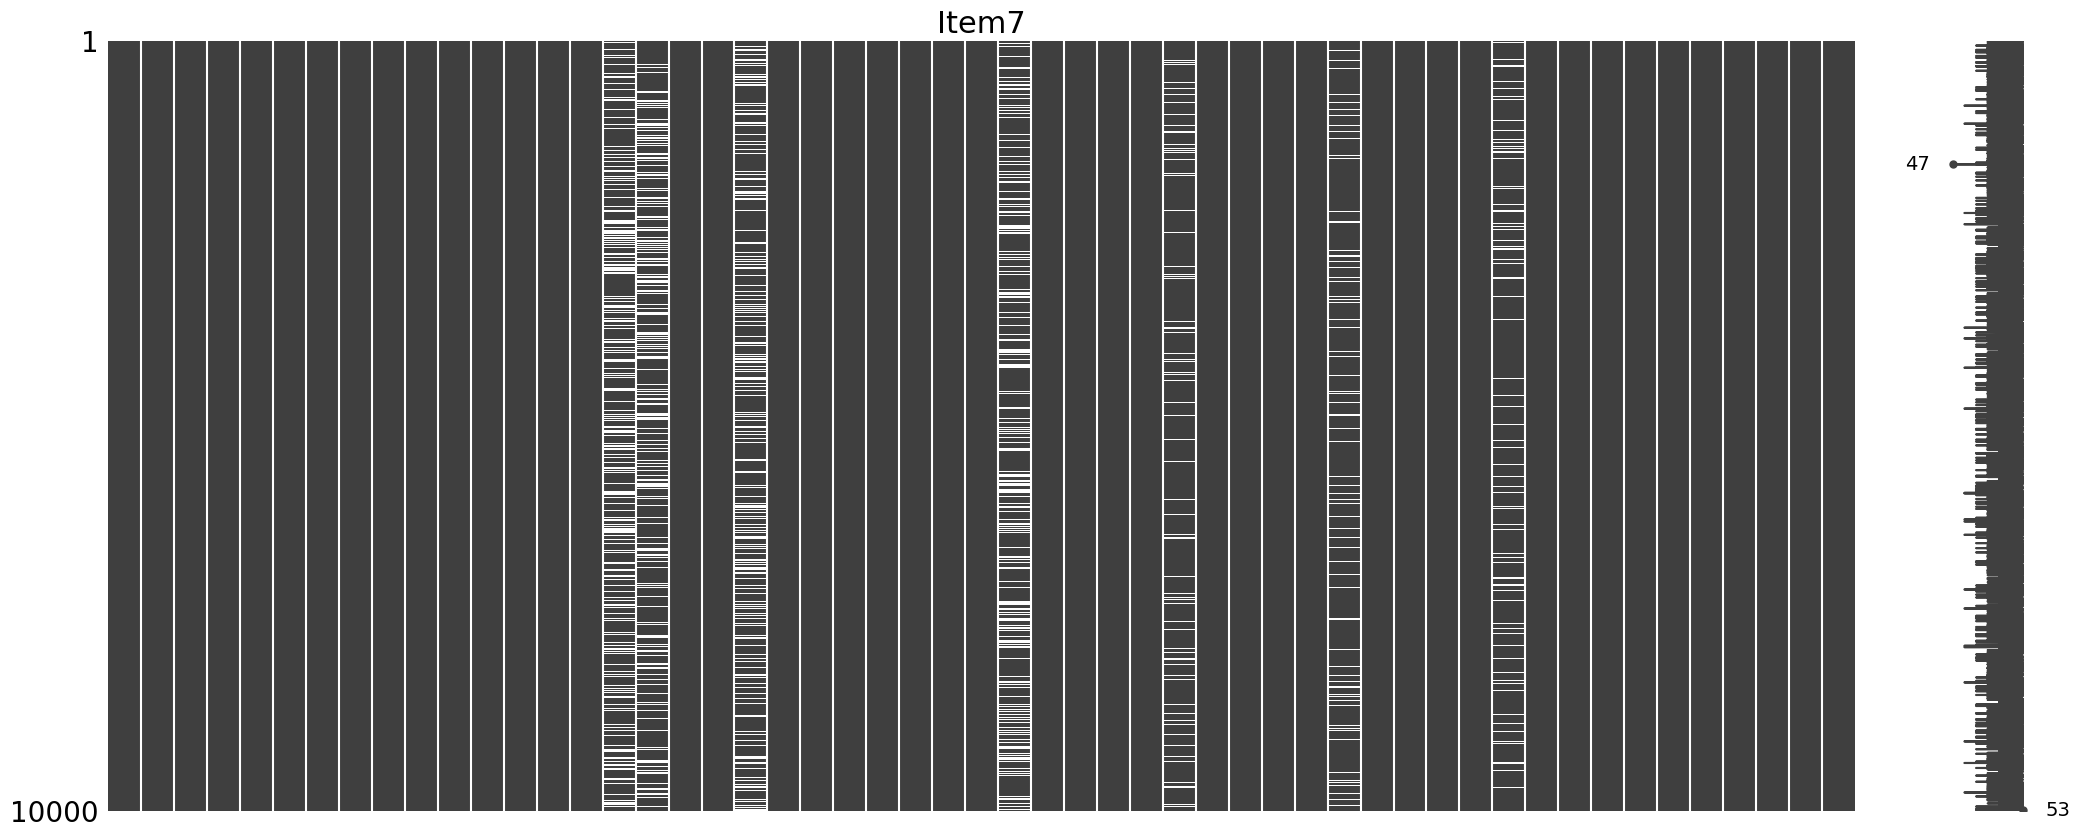

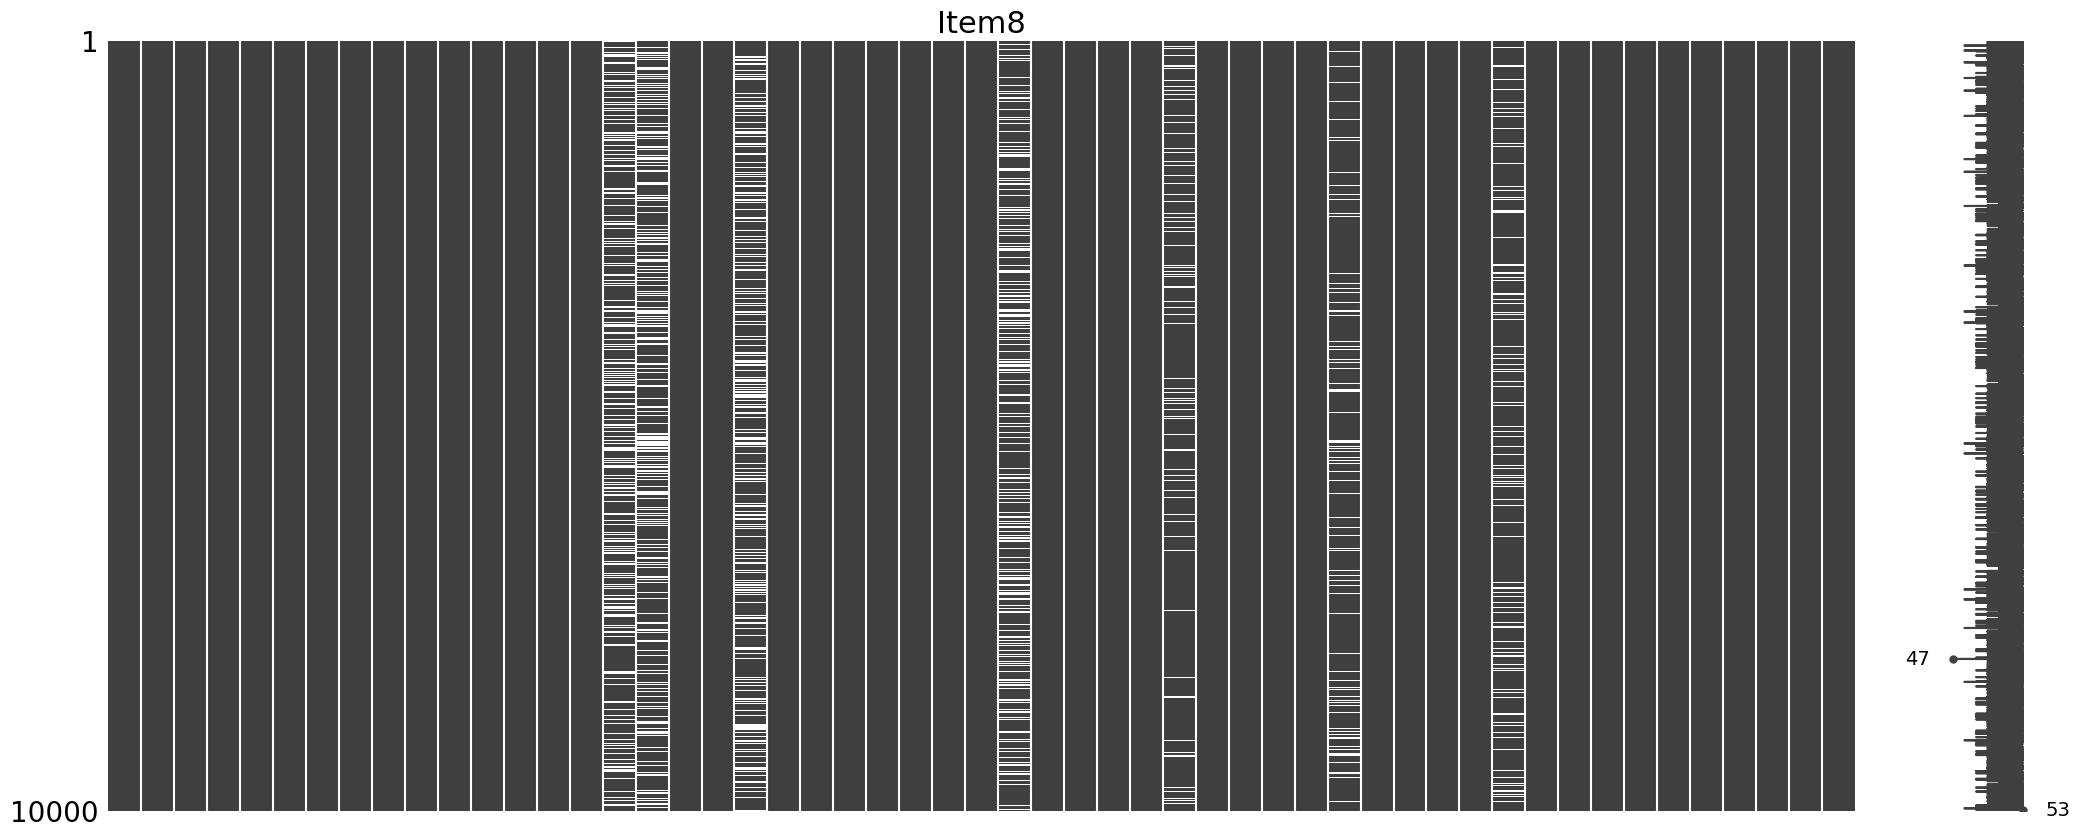

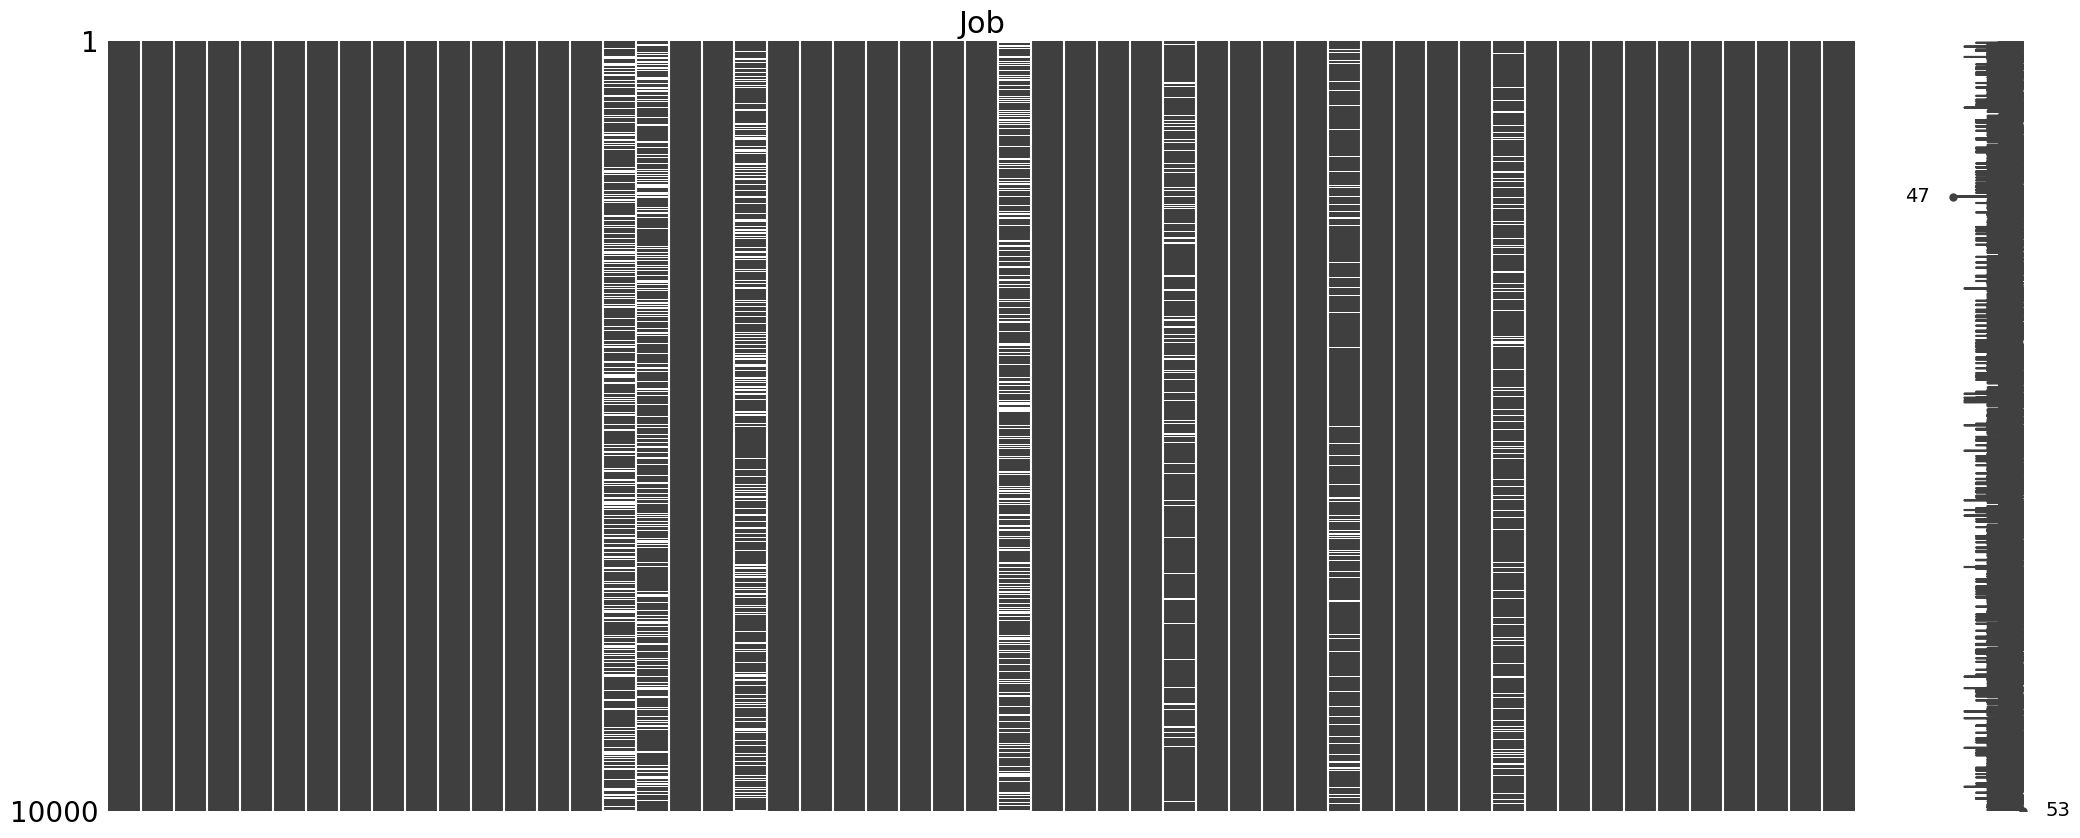

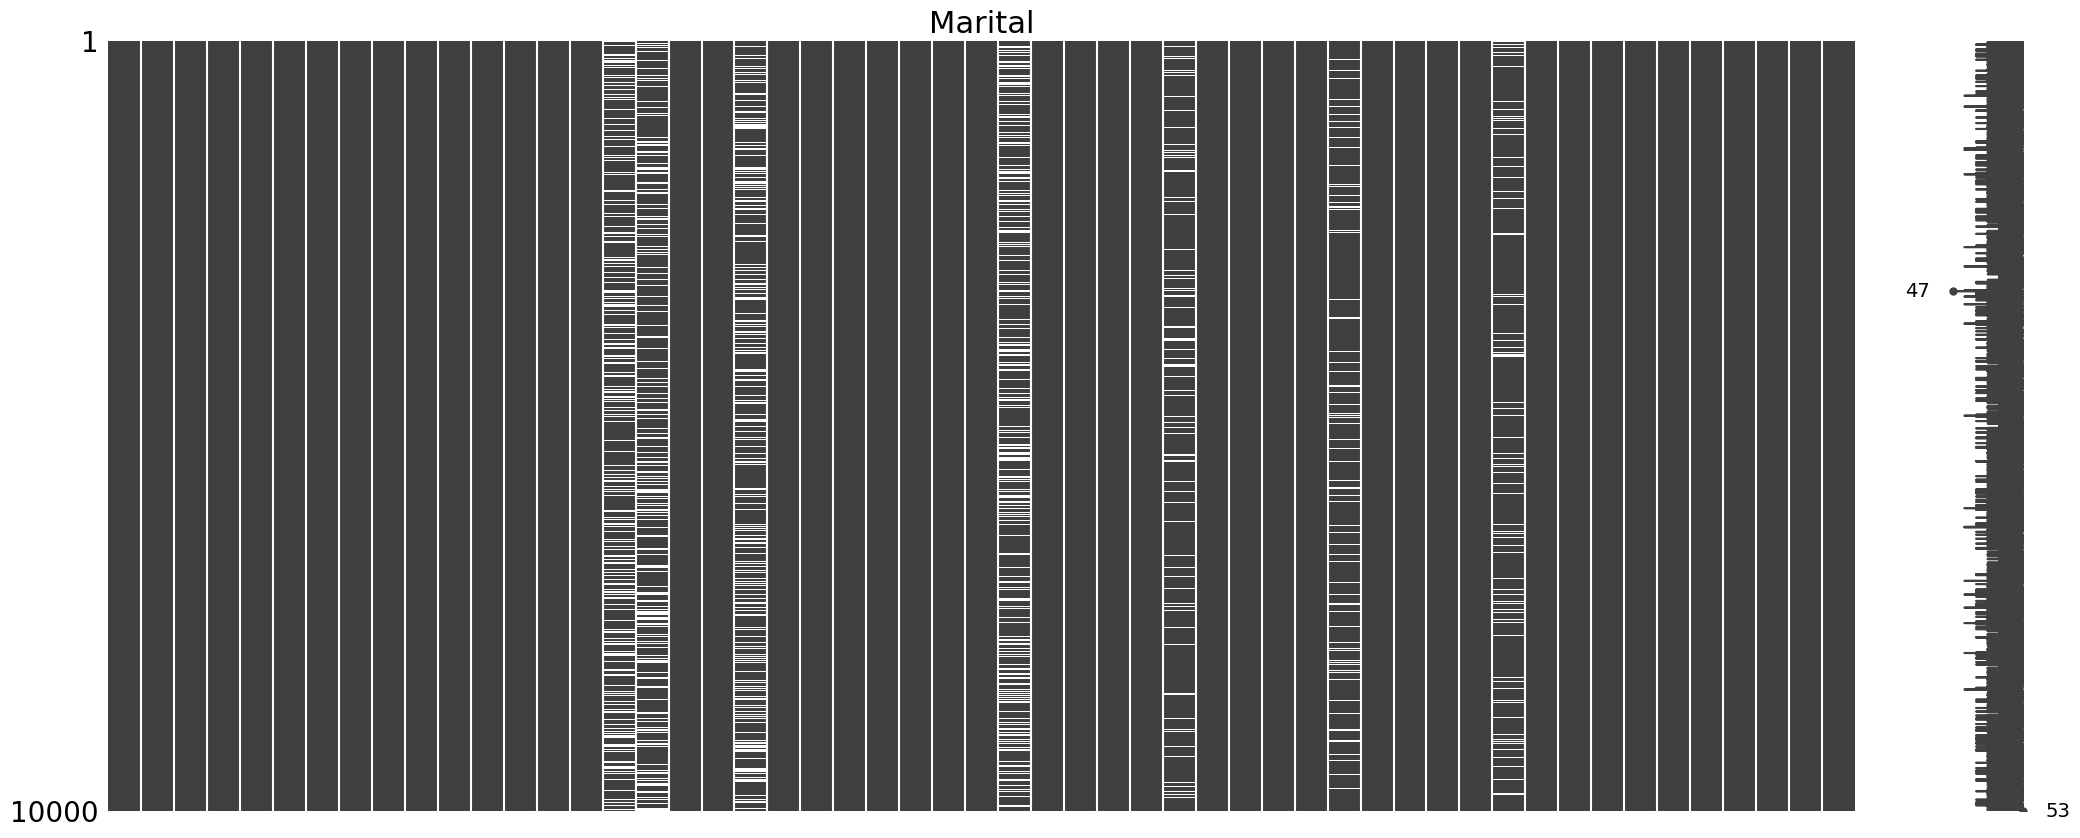

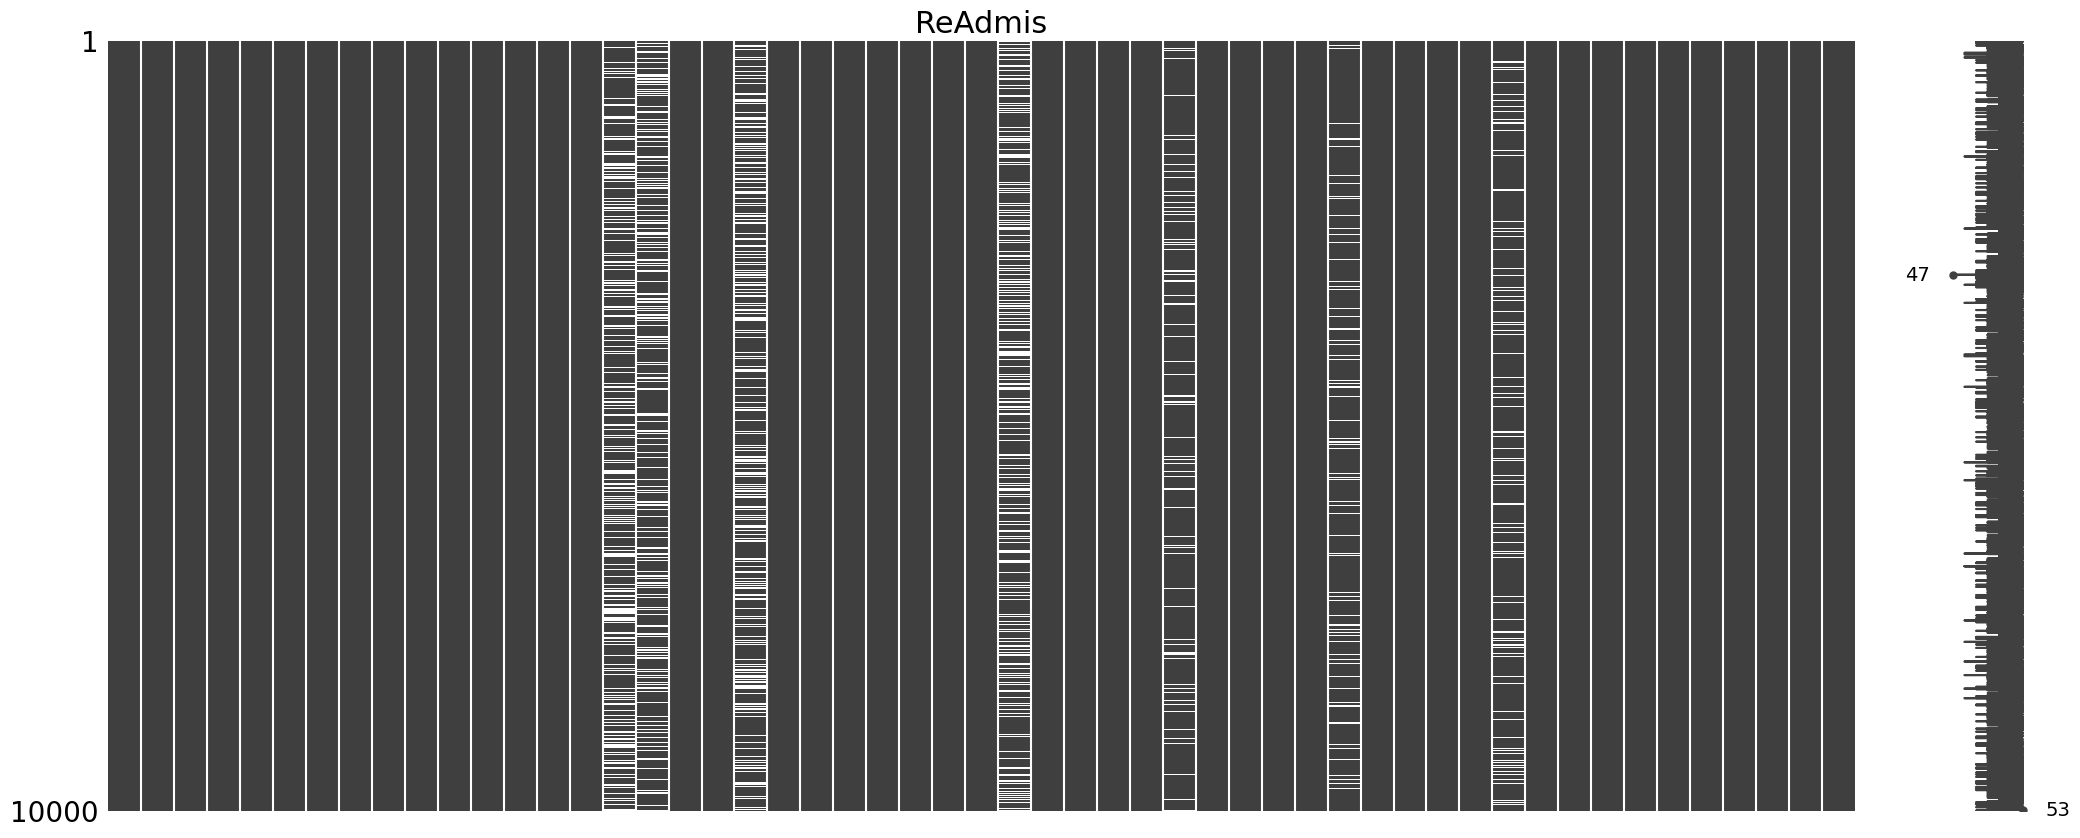

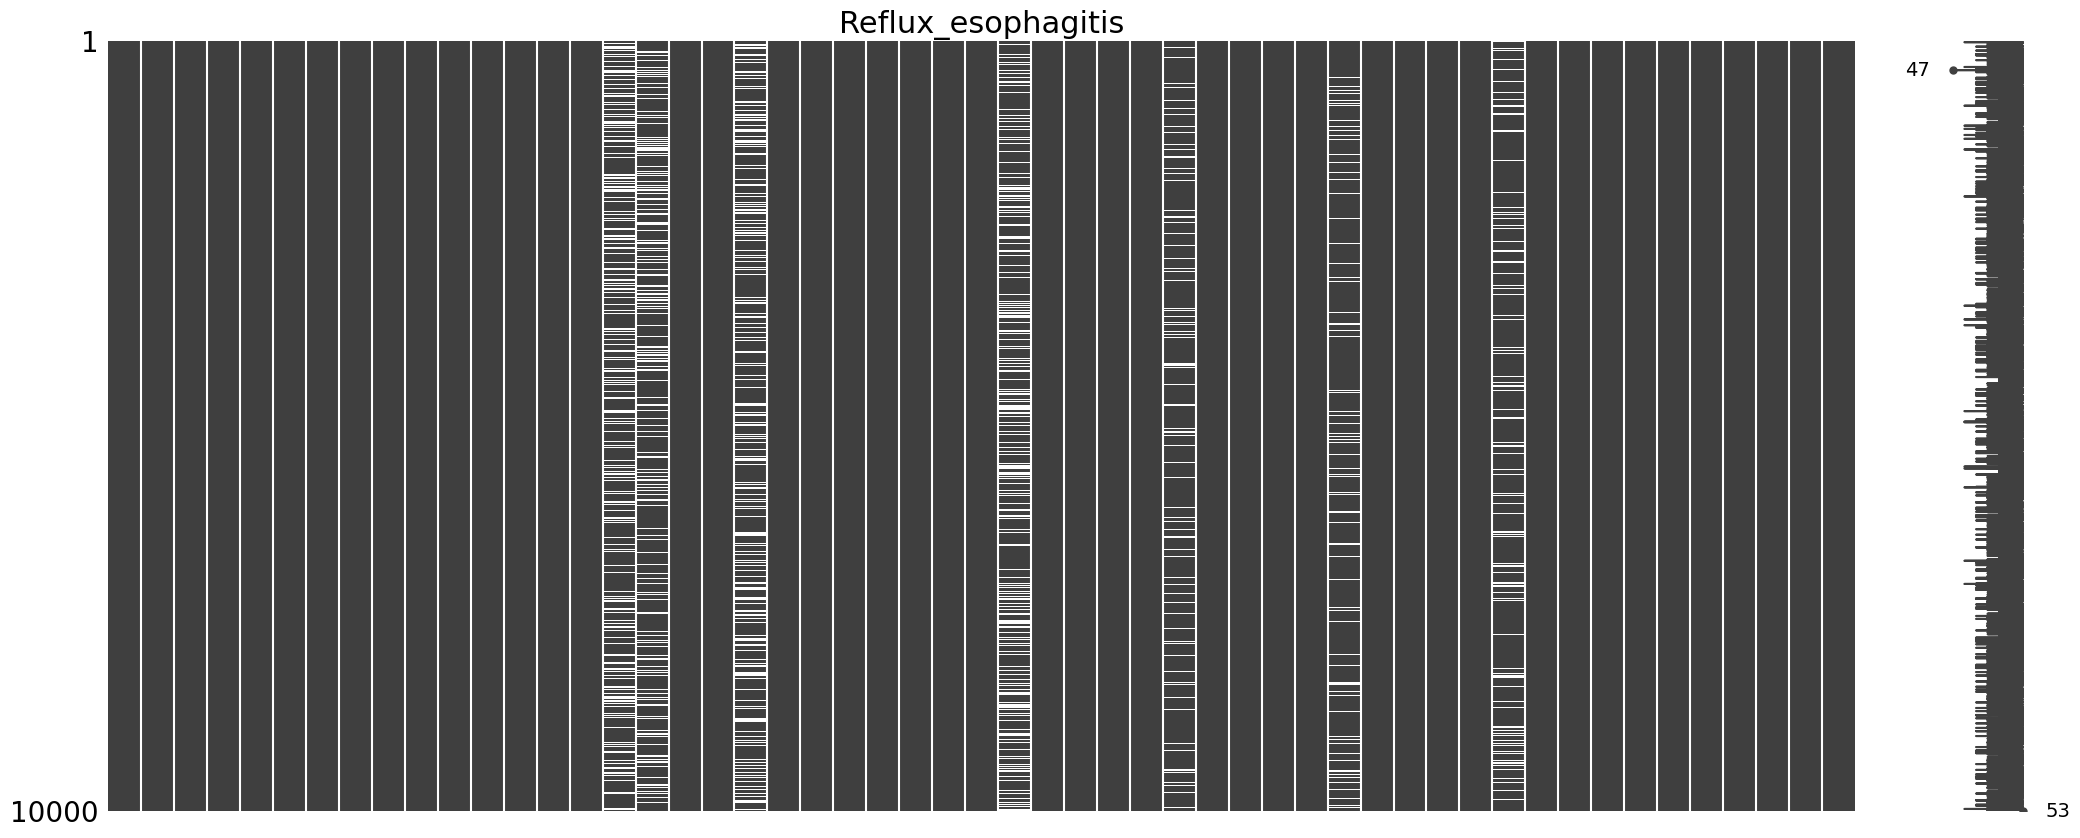

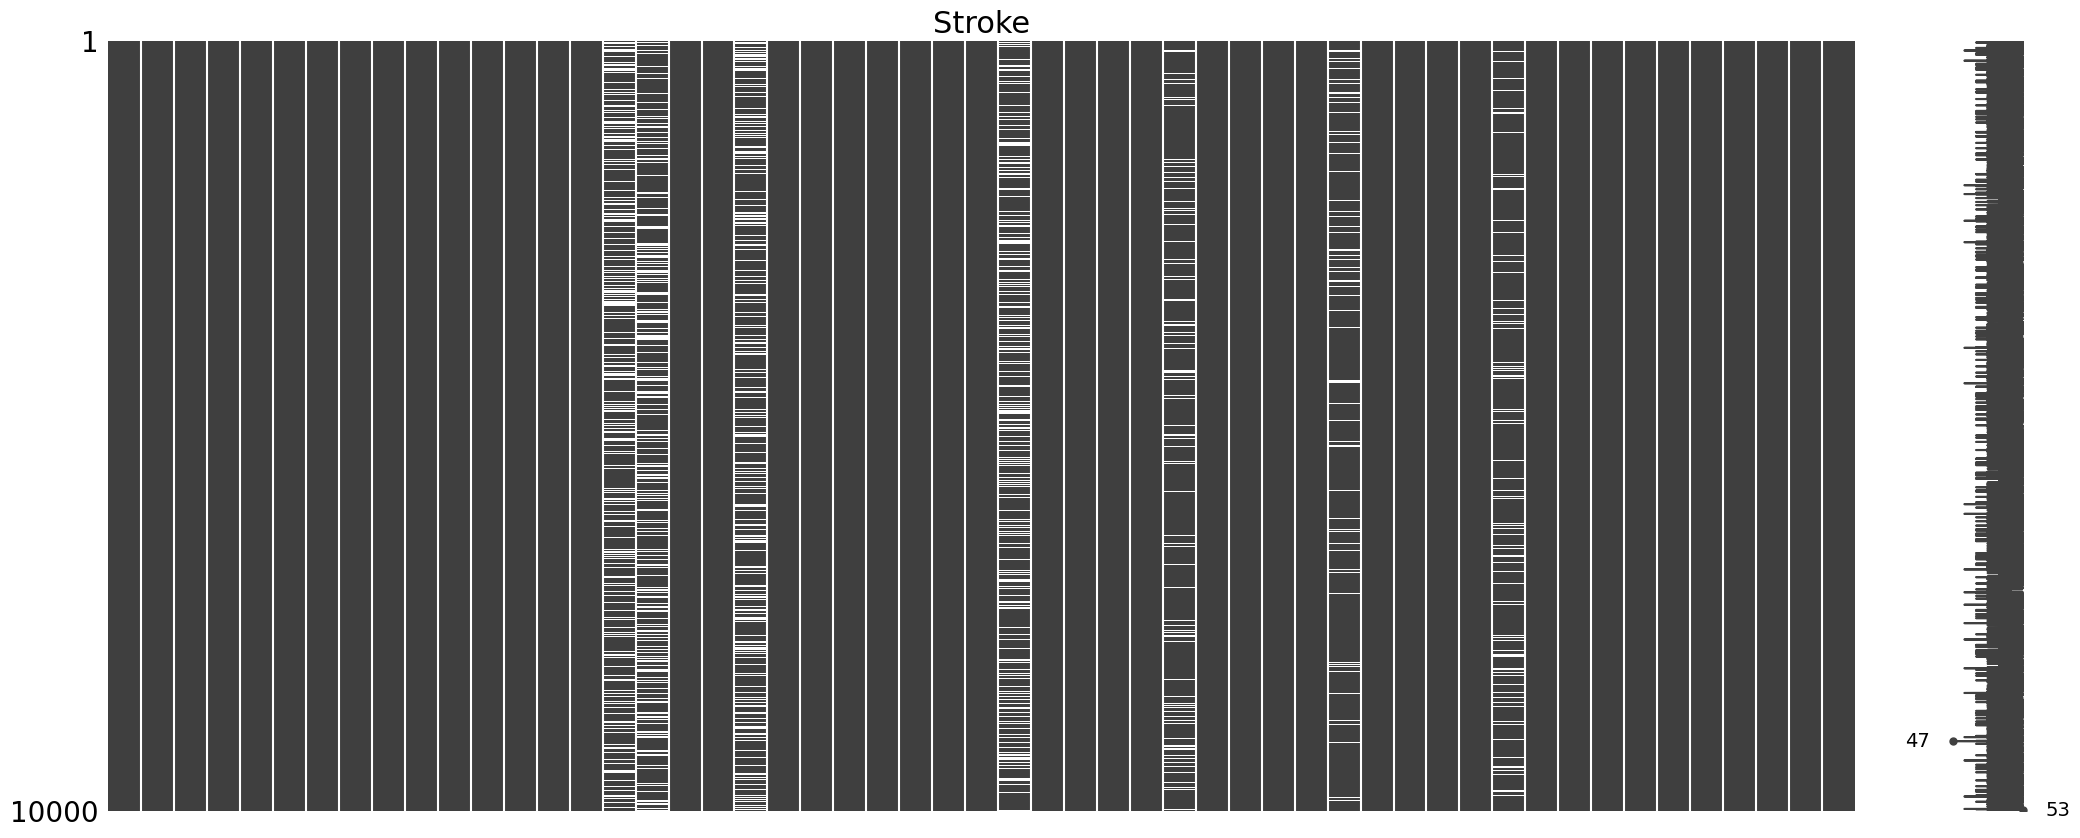

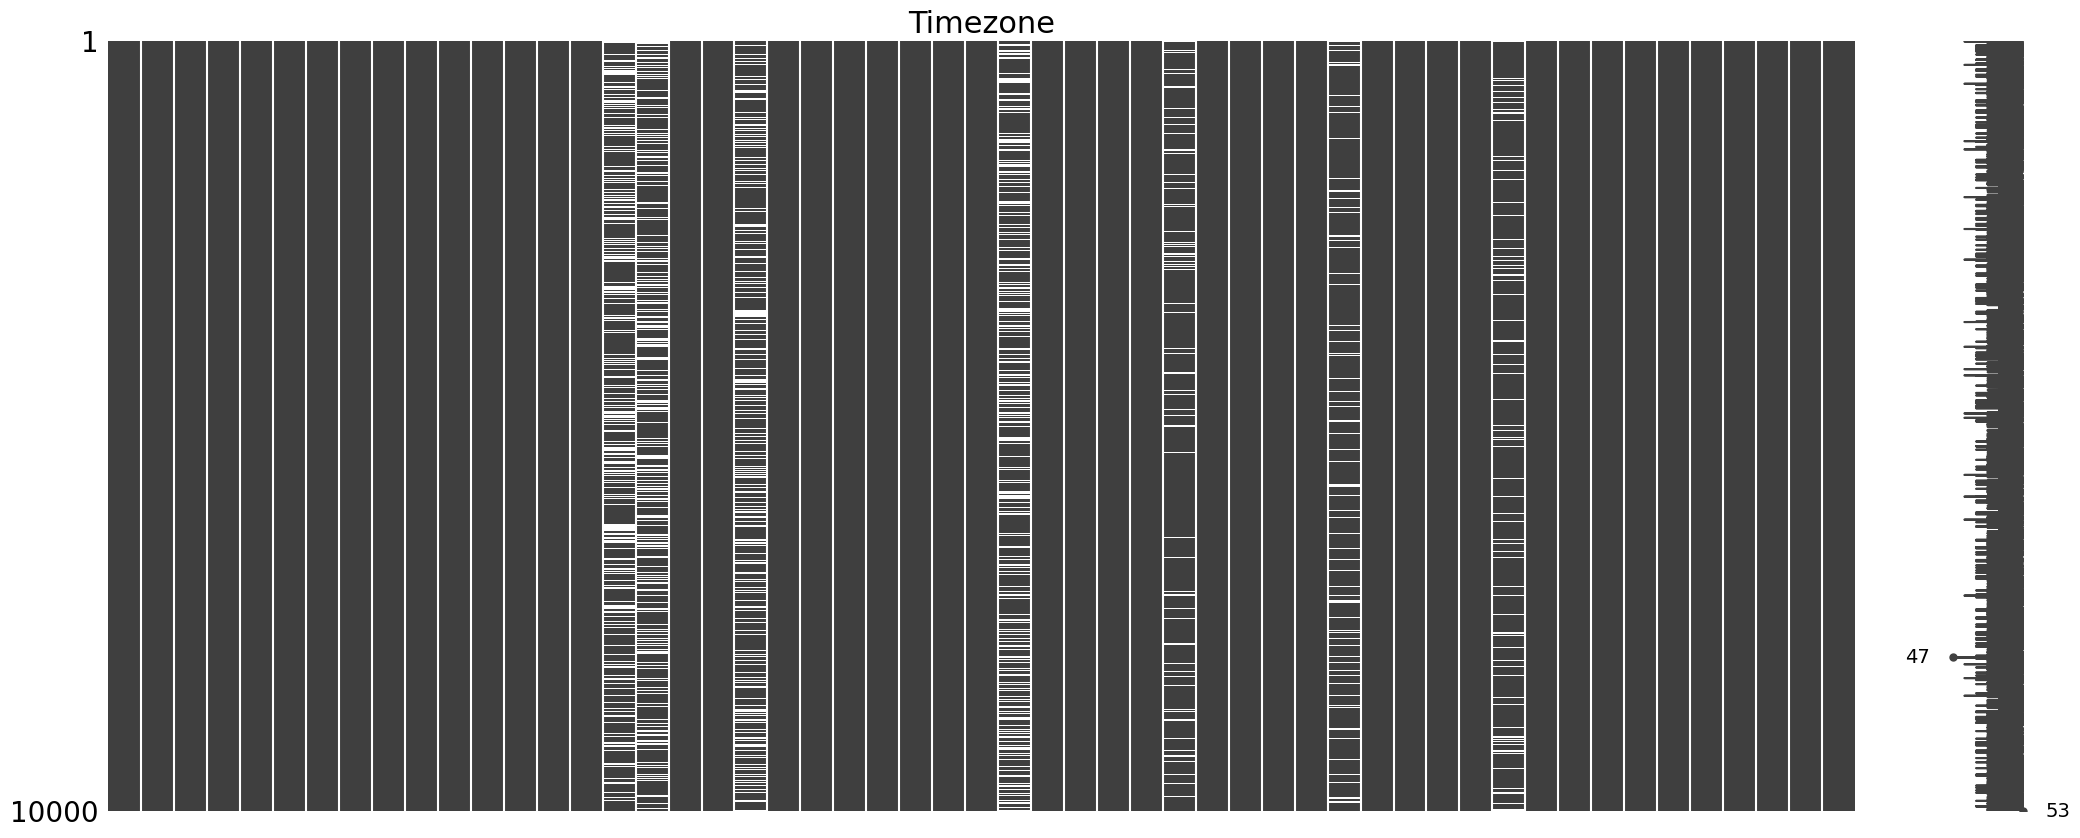

In [19]:
for col in sorted(categorical_complete):

    msno.matrix(medical.sort_values(col)).set_title(col, size=22)

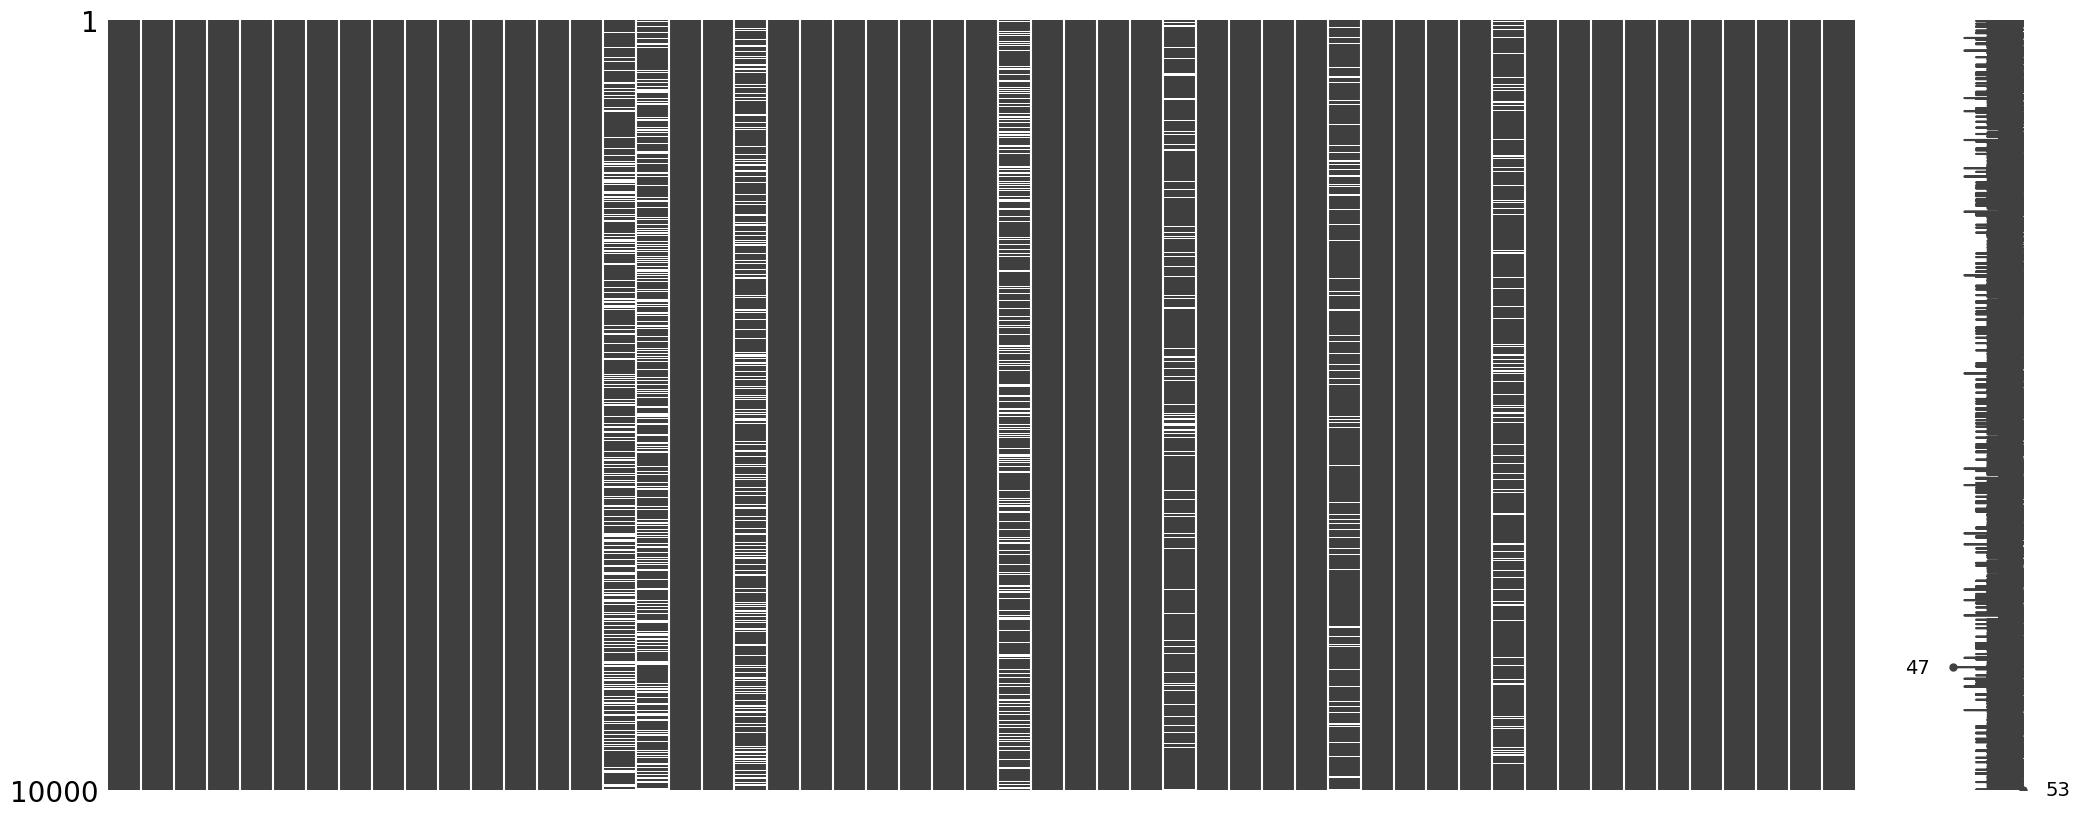

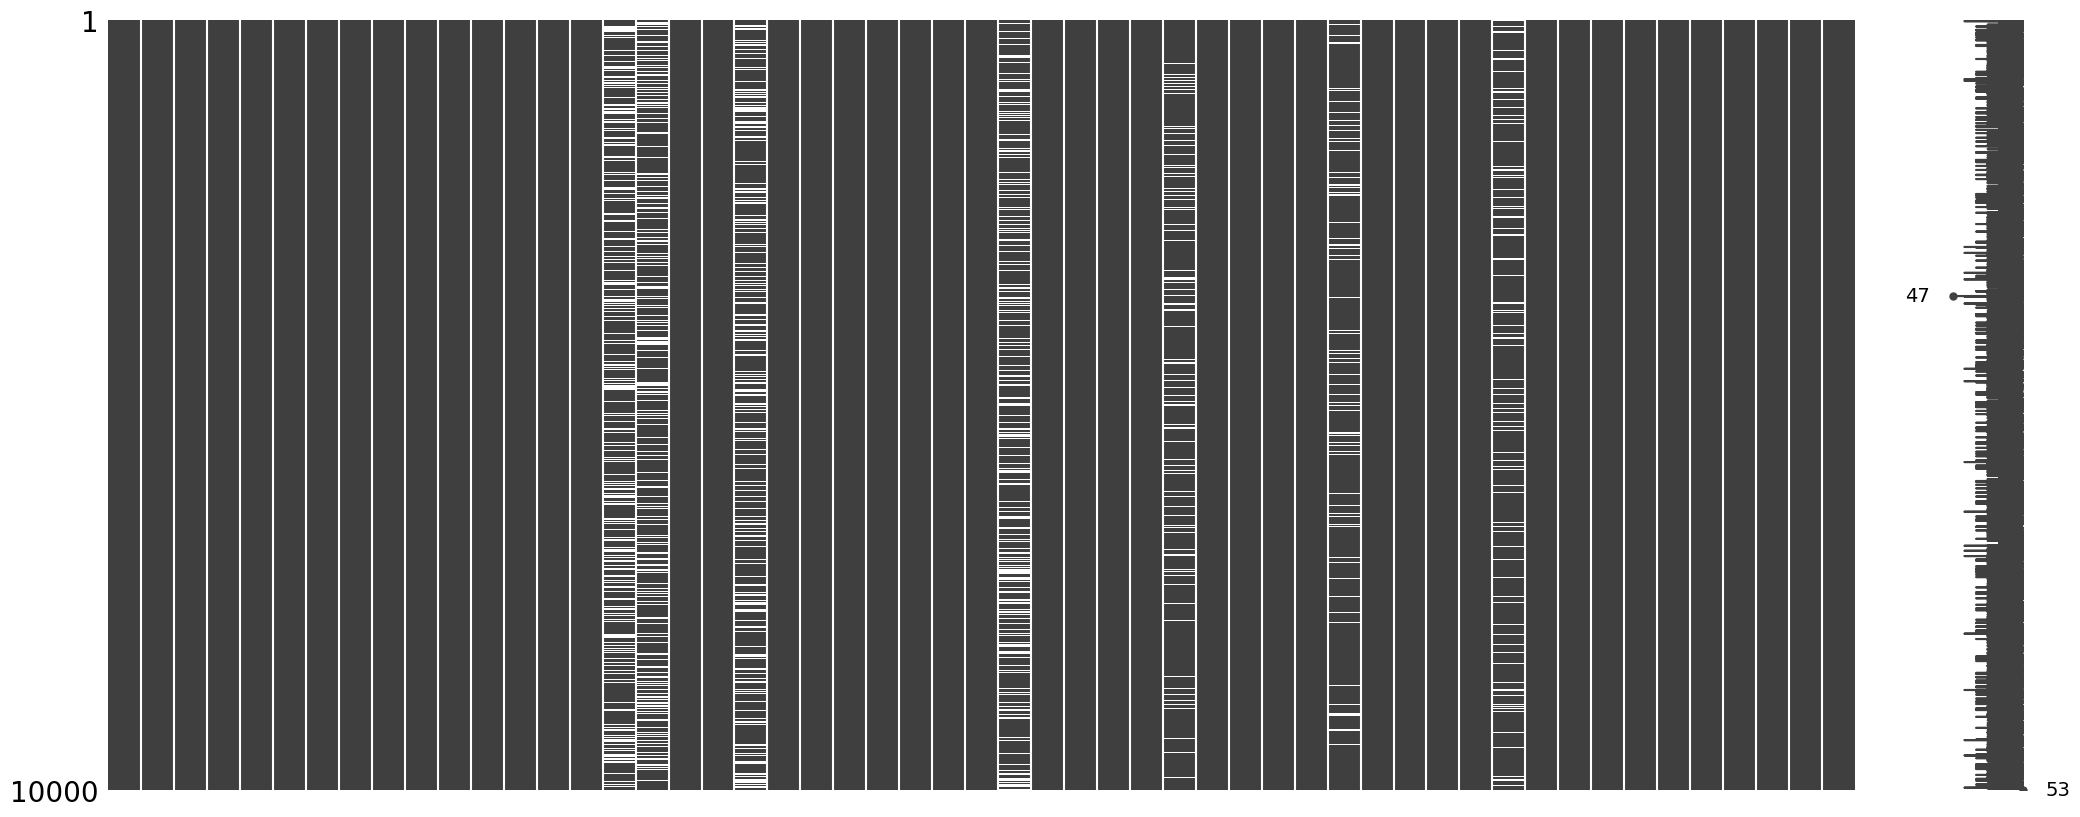

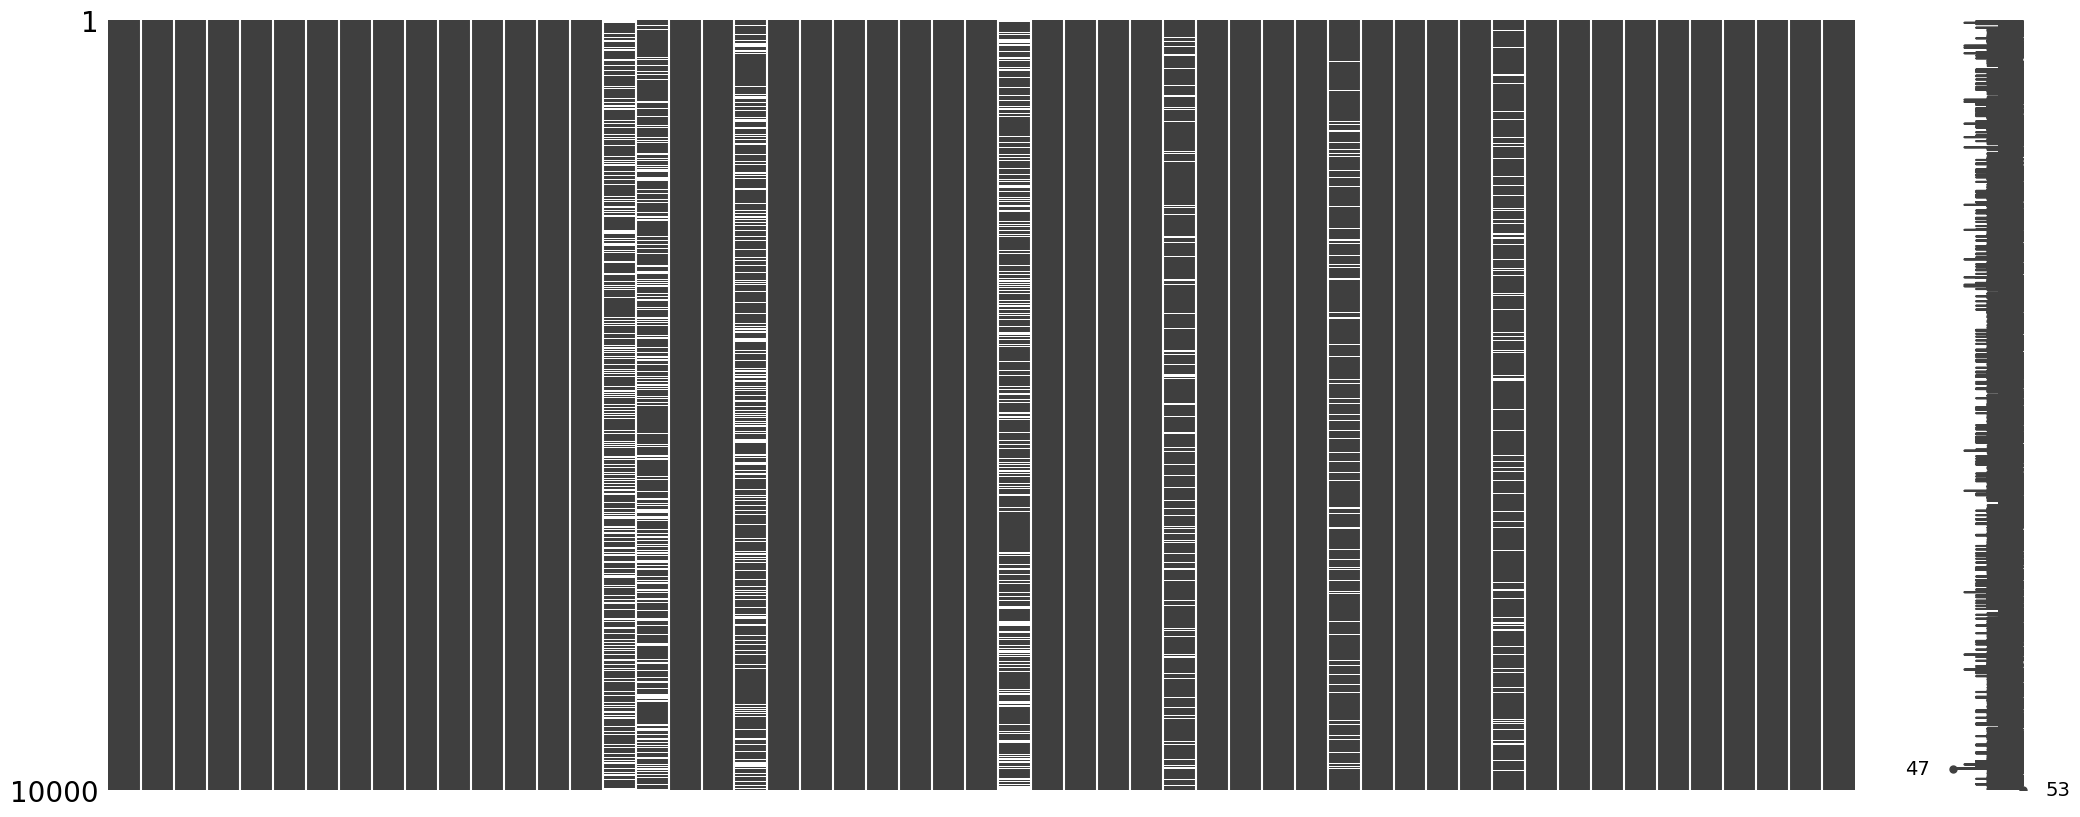

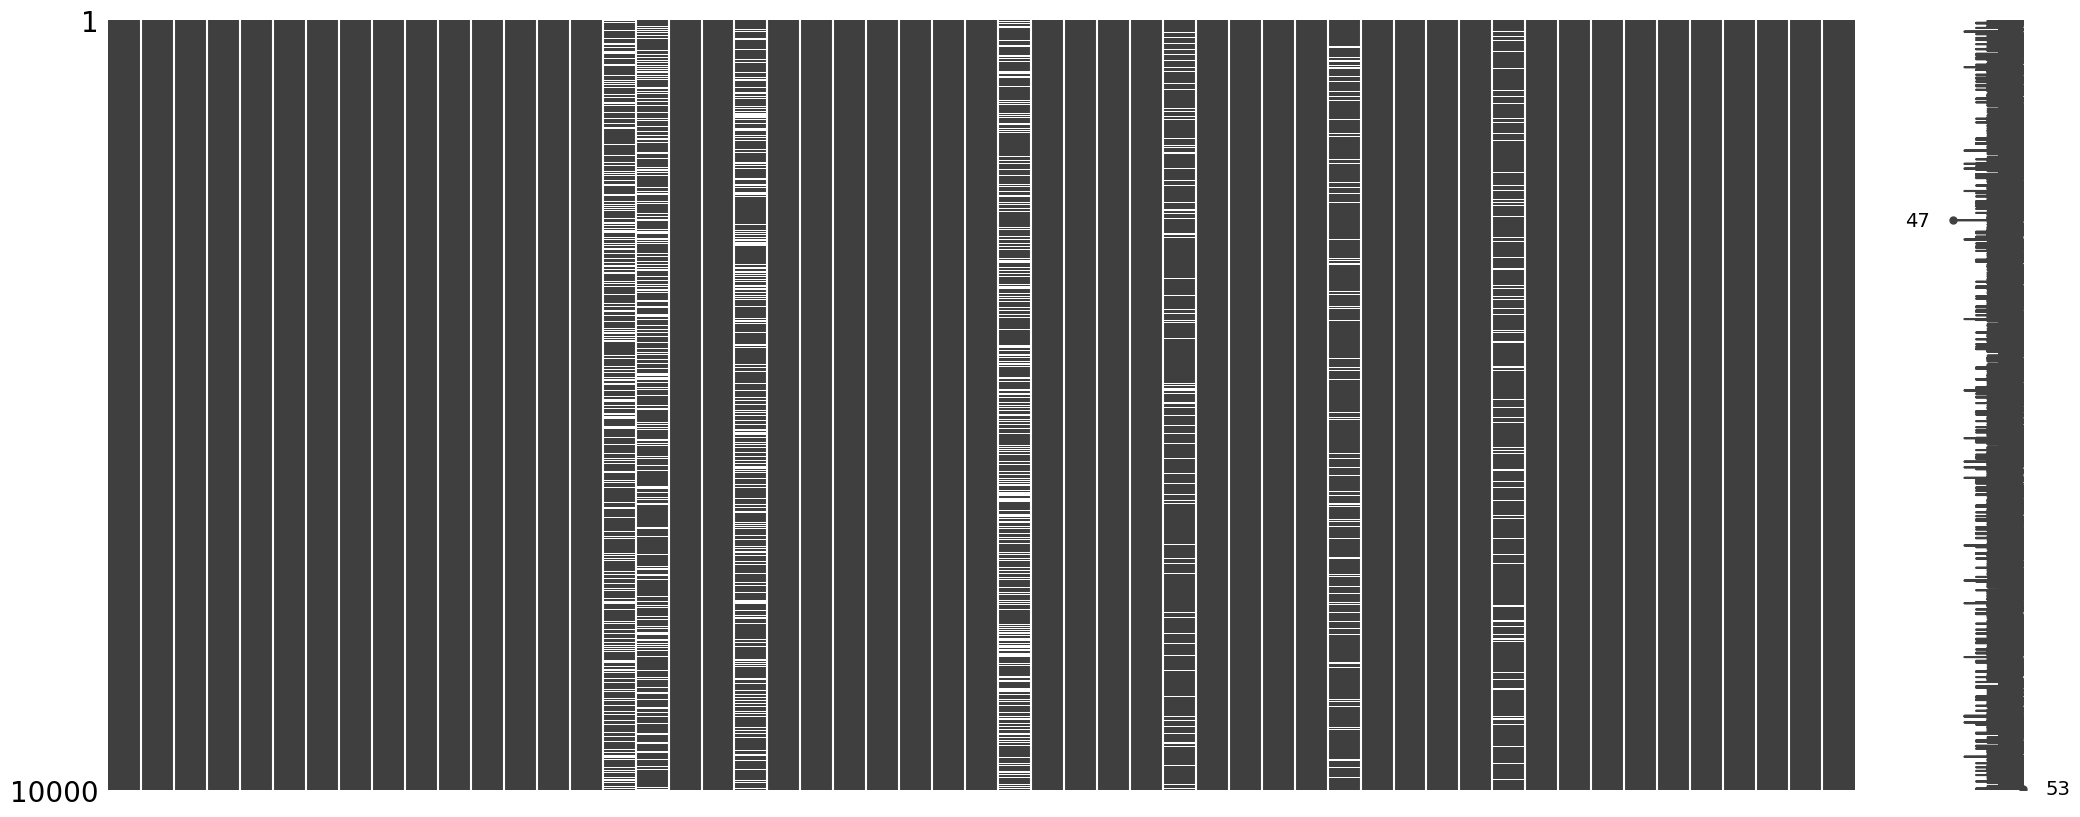

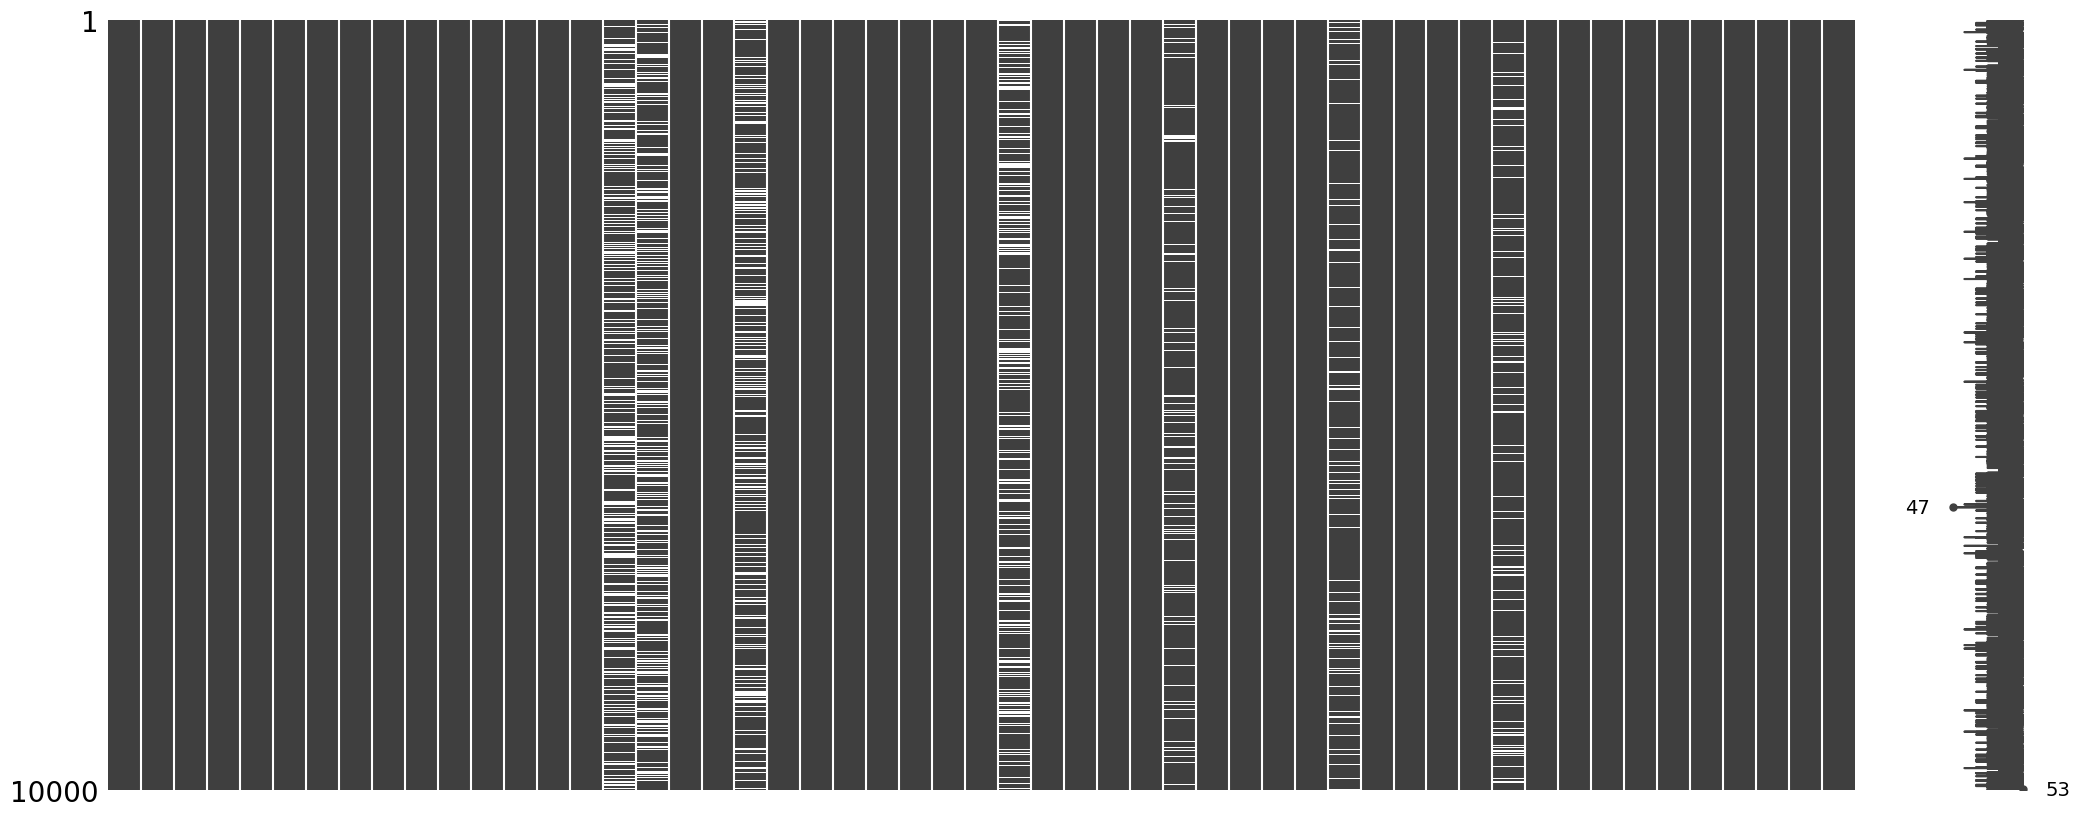

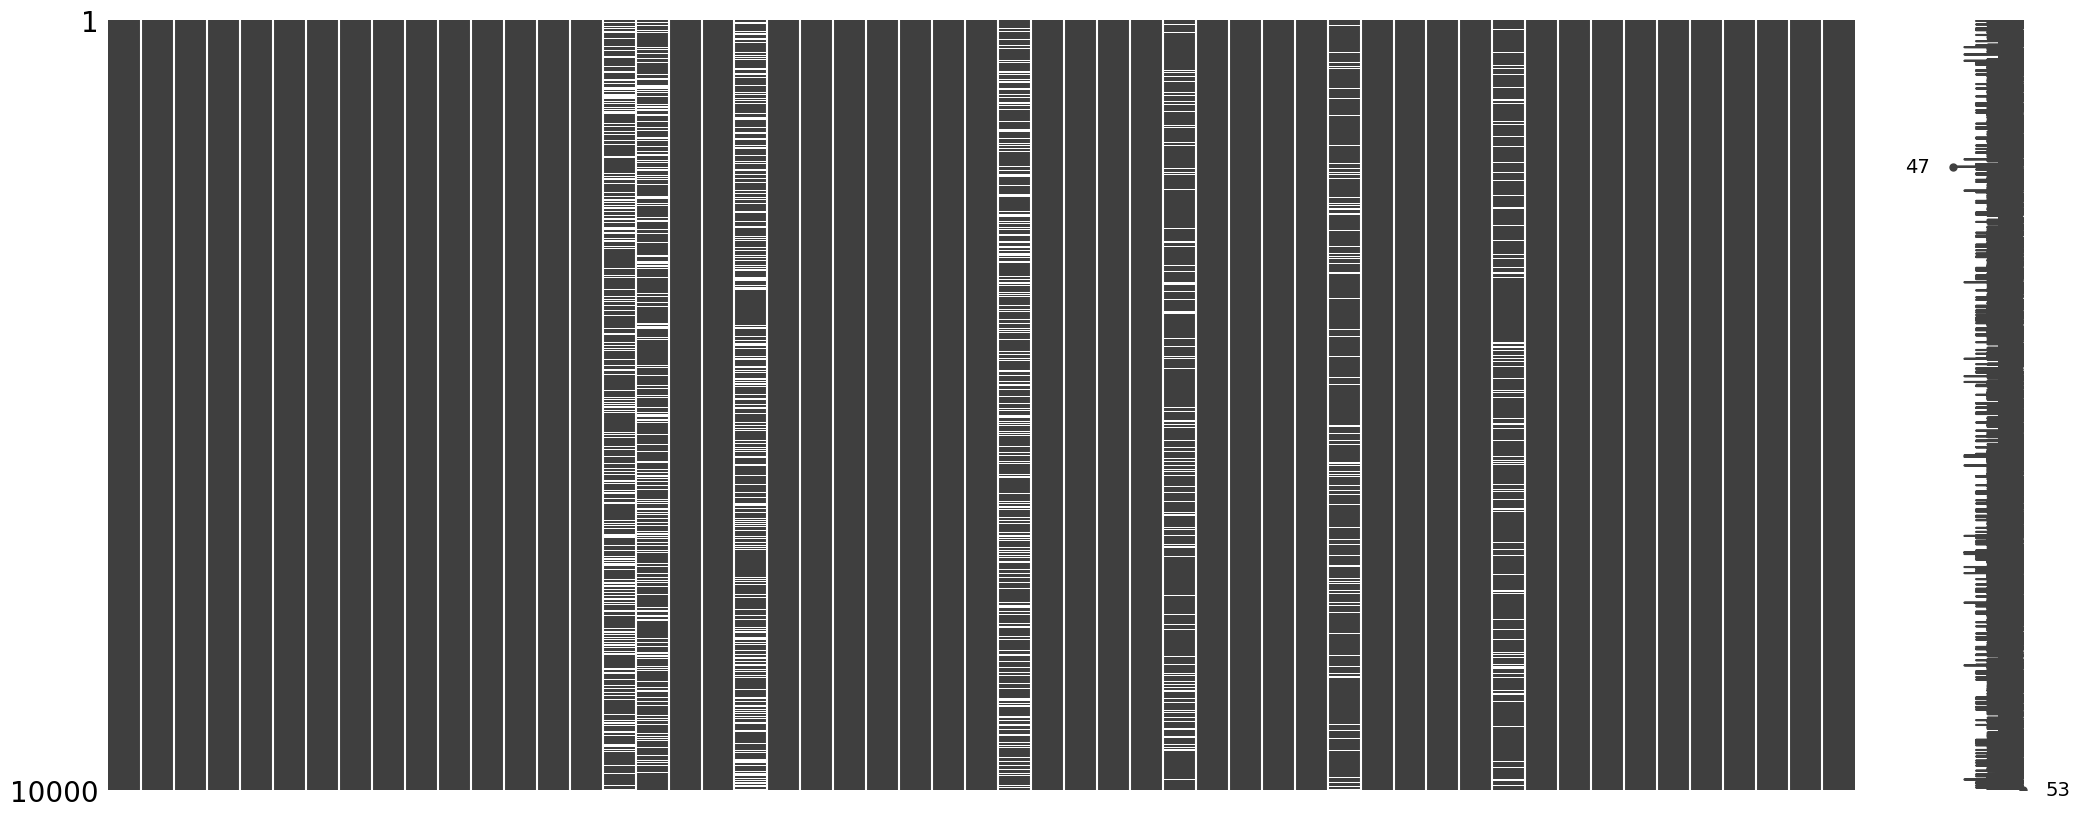

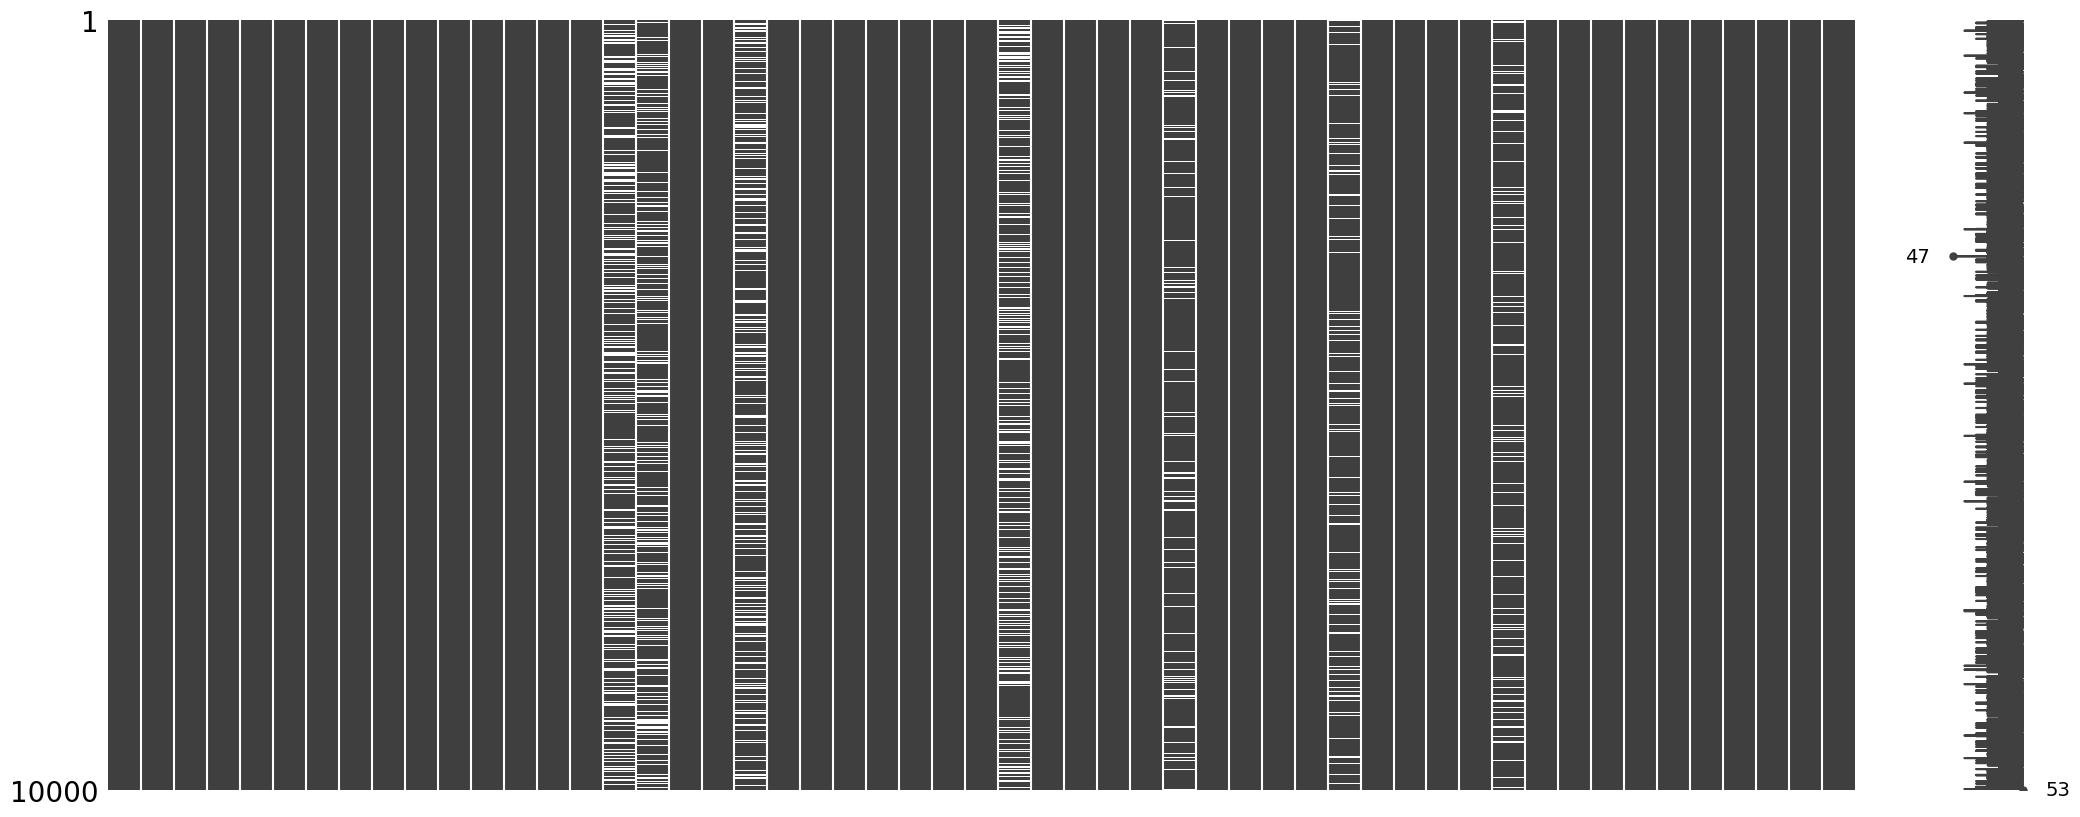

In [20]:
for col in sorted(quantitative_complete):

    msno.matrix(medical.sort_values(col))

Missingness Dendrogram

Plots below show no categories with any strong ability to predict nullity
in other columns.

Missingness for features is not likely related to other features (i.e.
the values are not likely "Missing not at Random (MNAR)" or "Missing at
Random (MAR)").


<Axes: >

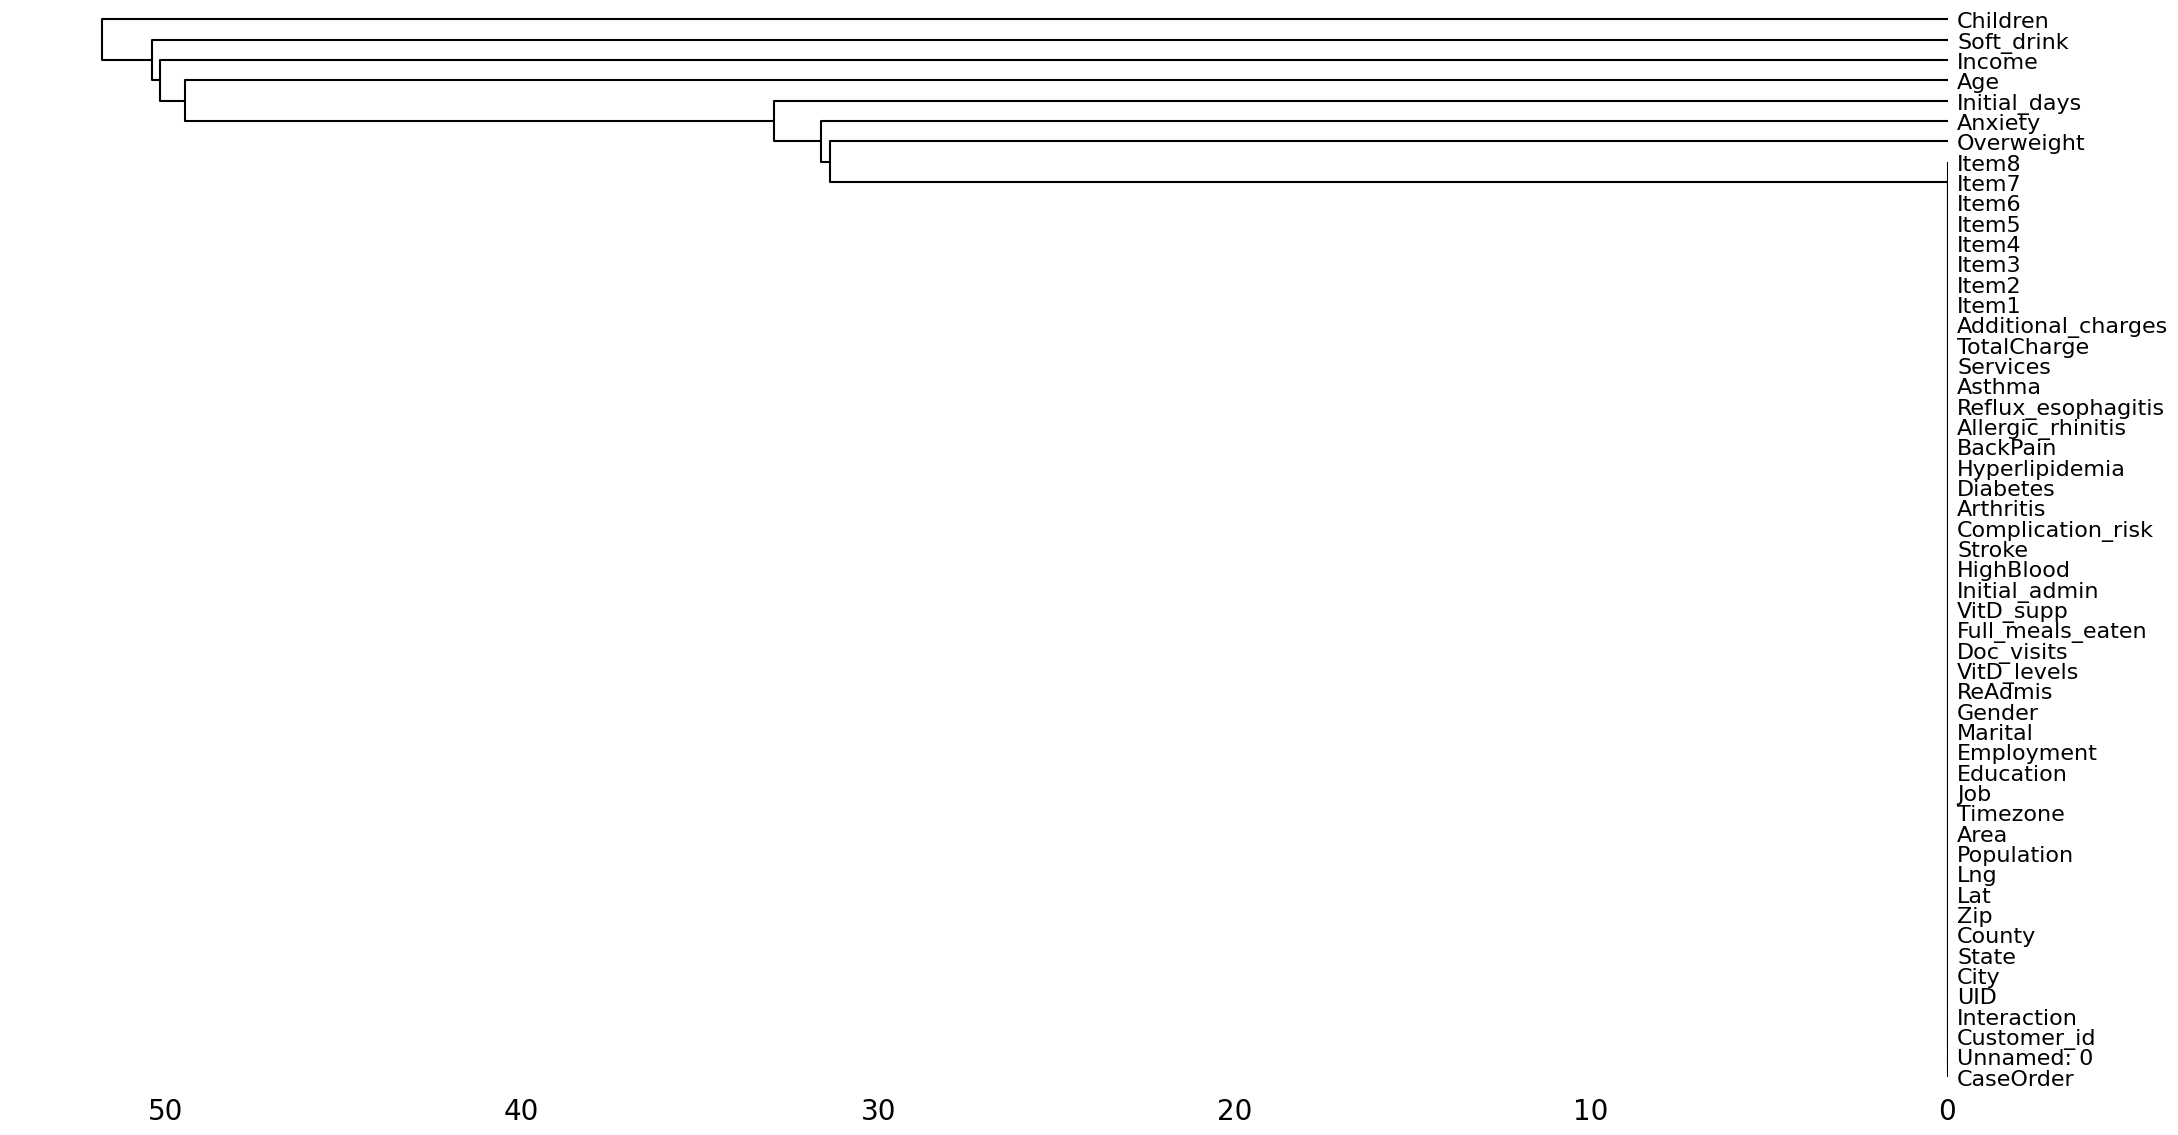

In [21]:
msno.dendrogram(medical)

<Axes: >

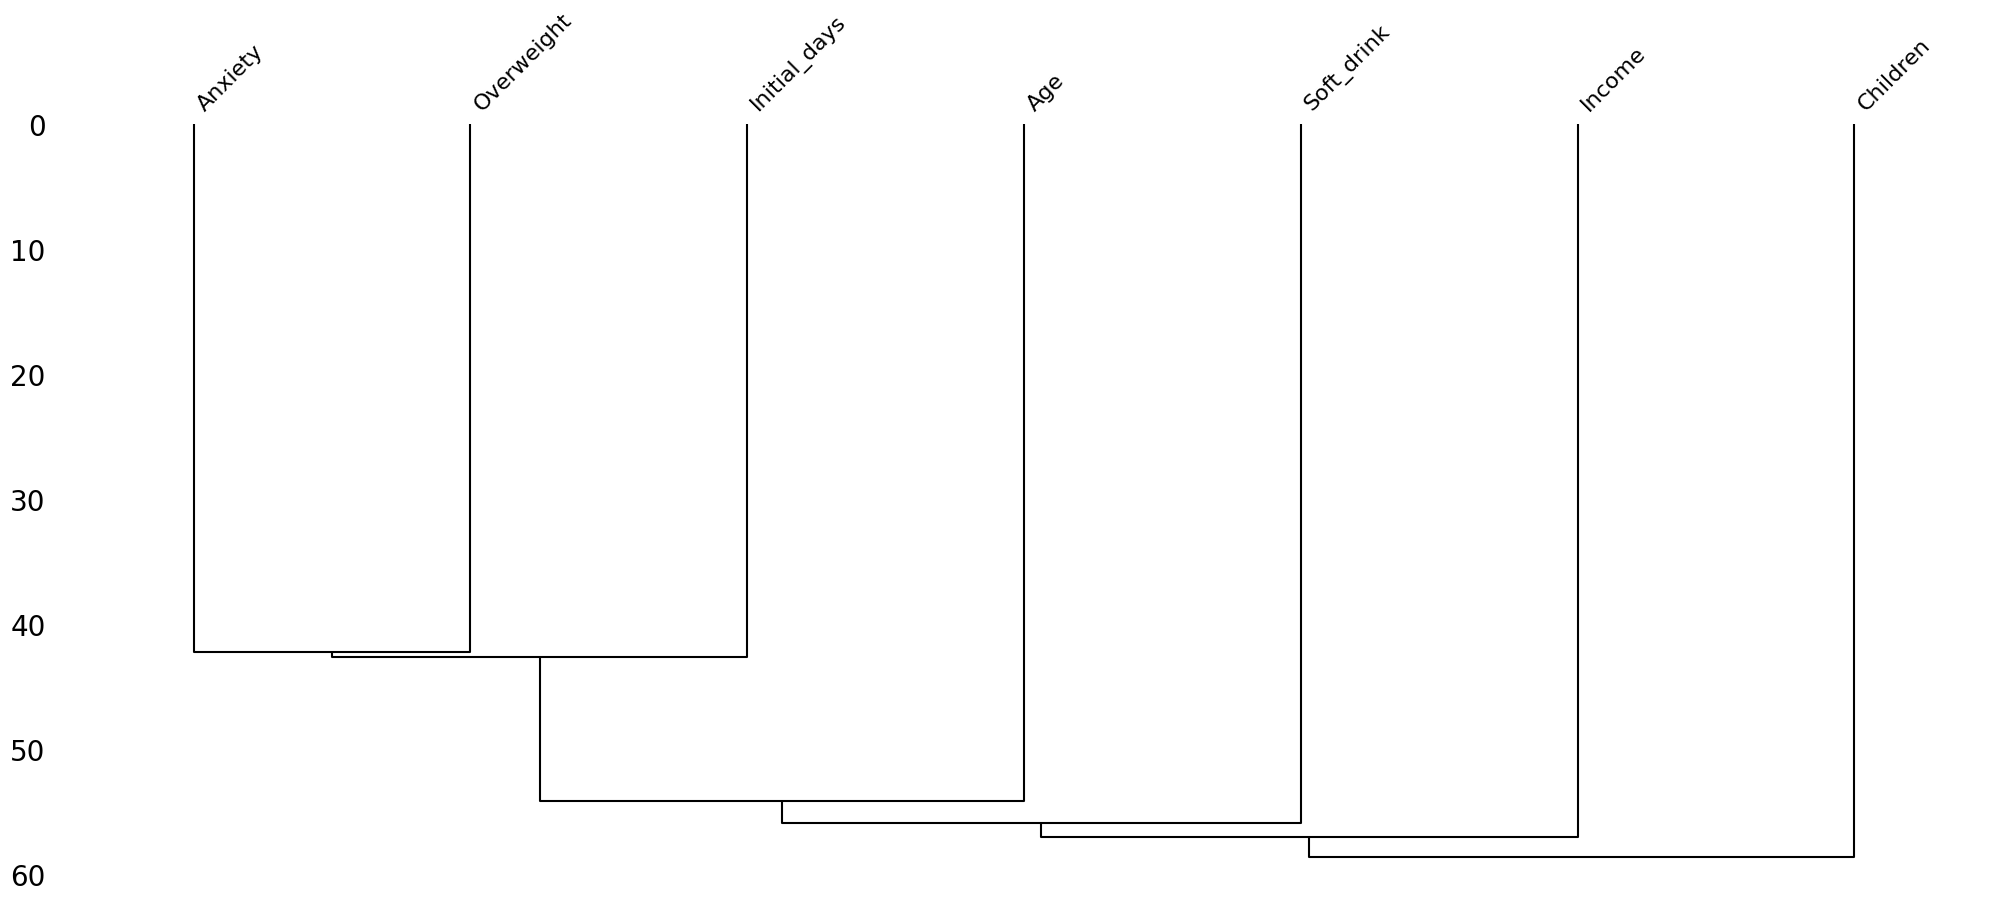

In [22]:
msno.dendrogram(medical[incomplete_cols])

## Initial check for outliers

Check for outliers in qualitative data


In [23]:
medical[quantitative_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Population,10000.0,9965.253800,14824.758614,0.000000,694.750000,2769.000000,13945.000000,122814.000000
Children,7412.0,2.098219,2.155427,0.000000,0.000000,1.000000,3.000000,10.000000
Age,7586.0,53.295676,20.659182,18.000000,35.000000,53.000000,71.000000,89.000000
Income,7536.0,40484.438268,28664.861050,154.080000,19450.792500,33942.280000,54075.235000,207249.130000
VitD_levels,10000.0,19.412675,6.723277,9.519012,16.513171,18.080560,19.789740,53.019124
Doc_visits,10000.0,5.012200,1.045734,1.000000,4.000000,5.000000,6.000000,9.000000
Full_meals_eaten,10000.0,1.001400,1.008117,0.000000,0.000000,1.000000,2.000000,7.000000
VitD_supp,10000.0,0.398900,0.628505,0.000000,0.000000,0.000000,1.000000,5.000000
Initial_days,8944.0,34.432082,26.287050,1.001981,7.911709,34.446941,61.124654,71.981486
TotalCharge,10000.0,5891.538261,3377.558136,1256.751699,3253.239465,5852.250564,7614.989701,21524.224210


#### Distribution discovery

The graphs below suggest these features

| Column             | Distribution Comments                                                                                                                                                                                                                                                                                                                |
| ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| Population         | Right Skewed                                                                                                                                                                                                                                                                                                                         |
| Children           | Right Skewed                                                                                                                                                                                                                                                                                                                         |
| Age                | Almost Uniform                                                                                                                                                                                                                                                                                                                       |
| Income             | Right Skewed                                                                                                                                                                                                                                                                                                                         |
| VitD_levels        | Right Skewed (a case could be made for Bimodal as there's a small but distinct cluster between 43 and 53)                                                                                                                                                                                                                            |
| Doc_visits         | Approximating normal (Discrete distribution , possibly Poisson with an expected rate around 5)                                                                                                                                                                                                                                       |
| Full_meals_eaten   | Right Skewed (Discrete distribution, possibly Poisson with an expected rate around 1)                                                                                                                                                                                                                                                |
| VitD_supp          | Right Skewed (Discrete distribution, possibly Poisson with an expected rate <=1)                                                                                                                                                                                                                                                     |
| Initial_days       | Bimodal                                                                                                                                                                                                                                                                                                                              |
| TotalCharge        | Multimodal. TotalCharge seems to have 4 clusters: two very strong clusters with centers around 3000, and 7700, and two weaker clusters around 14750 and 19000 (which could also be described as a right skew)                                                                                                                        |
| Additional_charges | This is an interesting distribution. You could describe it as right-skewed, but the distribution is near-uniform between 7000 and 15000, and then drops to another group of near-uniform values between 15000 and 27500, with only slight tapers at the beginning and end. There could be some significance to the 15000 breakpoint. |


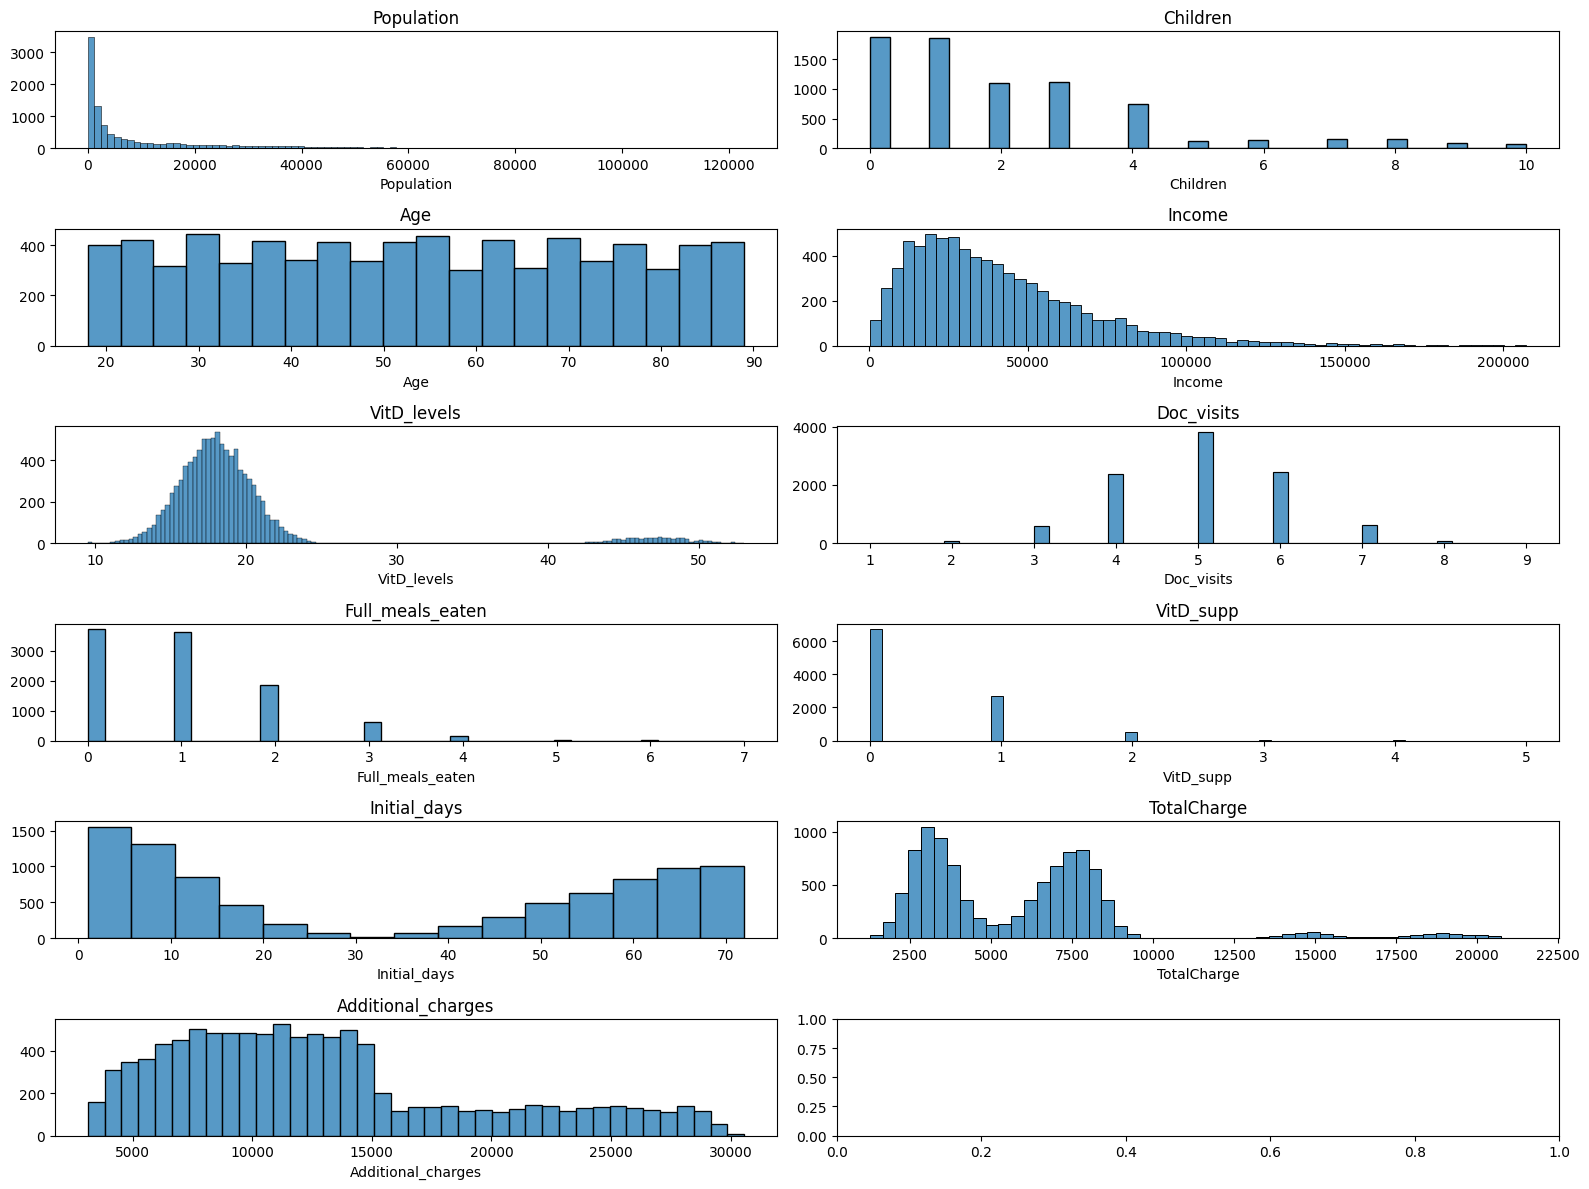

In [24]:
fig, axs = plt.subplots(6, 2, figsize=(16, 12))

for ax, col in zip(axs.ravel(), quantitative_cols):
    ax.set_title(col)
    sns.histplot(data=medical[col], ax=ax)

    ax.set(ylabel='')

plt.tight_layout()

A closer look at `TotalCharge`


(2978.246, 3053.094]
(7613.013, 7717.425]
(14794.928, 14872.406]
(18414.52, 18487.405]


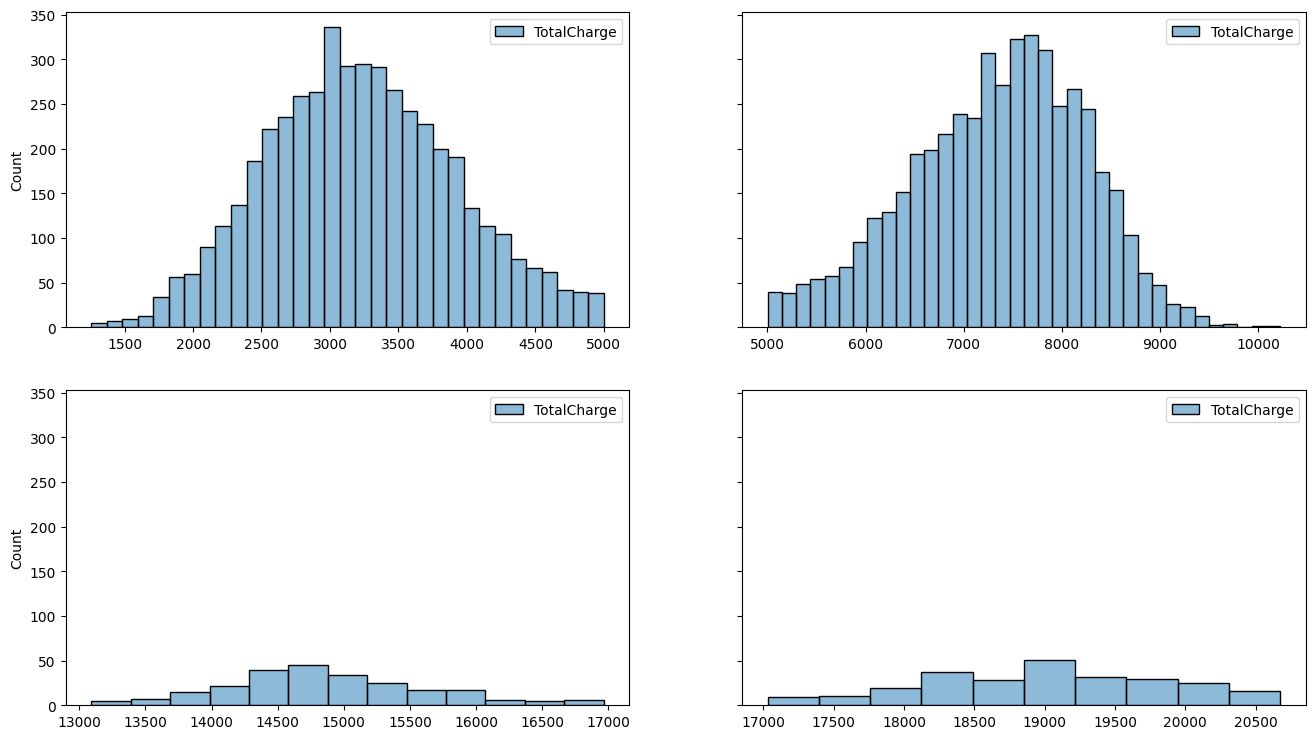

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharey=True)

cluster_01 = medical[['TotalCharge']][medical['TotalCharge'].between(0, 5000)]
cluster_02 = medical[['TotalCharge']
                     ][medical['TotalCharge'].between(5000, 12500)]
cluster_03 = medical[['TotalCharge']
                     ][medical['TotalCharge'].between(12500, 17000)]
cluster_04 = medical[['TotalCharge']
                     ][medical['TotalCharge'].between(17000, 21500)]

clusters = [cluster_01, cluster_02, cluster_03, cluster_04]

for ax, cluster in zip(axs.ravel(), clusters):

    sns.histplot(data=cluster, ax=ax)
    print(cluster['TotalCharge'].value_counts(bins=50).index[0])

plt.show()

### Box plots


In [26]:
# Box plots require all values to be present.
quantitative_no_nulls = medical[quantitative_cols].drop(
    quantitative_contains_nulls, axis=1)

# comparing z scores
quantitative_zscore = quantitative_no_nulls.apply(zscore)

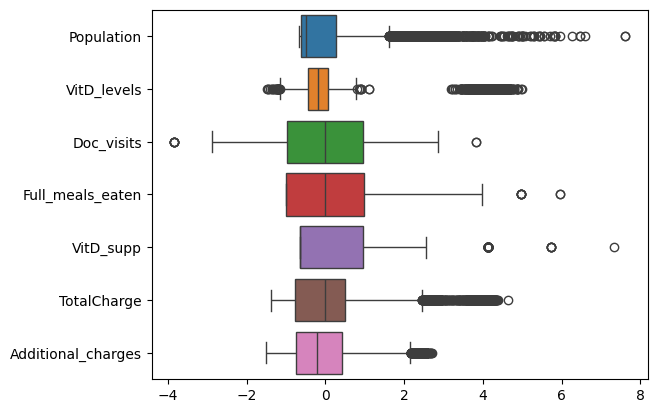

In [27]:
ax = sns.boxplot(
    data=quantitative_zscore,
    orient="h"
)

In [28]:
med_numeric = medical.select_dtypes(include=[np.number]).columns

In [29]:
for i in range(1, 9):

    print(medical[f"Item{i}"].value_counts(dropna=False).index)
    print("\t",
          np.sort(
              medical[f"Item{i}"].value_counts(dropna=False).index.values)
          )

Index([4, 3, 5, 2, 6, 1, 7, 8], dtype='int64', name='Item1')
	 [1 2 3 4 5 6 7 8]
Index([3, 4, 5, 2, 1, 6, 7], dtype='int64', name='Item2')
	 [1 2 3 4 5 6 7]
Index([4, 3, 5, 2, 6, 1, 7, 8], dtype='int64', name='Item3')
	 [1 2 3 4 5 6 7 8]
Index([3, 4, 5, 2, 6, 1, 7], dtype='int64', name='Item4')
	 [1 2 3 4 5 6 7]
Index([4, 3, 2, 5, 6, 1, 7], dtype='int64', name='Item5')
	 [1 2 3 4 5 6 7]
Index([4, 3, 5, 2, 6, 1, 7], dtype='int64', name='Item6')
	 [1 2 3 4 5 6 7]
Index([4, 3, 2, 5, 1, 6, 7], dtype='int64', name='Item7')
	 [1 2 3 4 5 6 7]
Index([3, 4, 5, 2, 6, 1, 7], dtype='int64', name='Item8')
	 [1 2 3 4 5 6 7]


In [30]:
medical.ReAdmis.value_counts(dropna=False)

ReAdmis
No     6331
Yes    3669
Name: count, dtype: int64

### Drop superfluous indexing columns

The original dataset includes two identical columns that exist to
preserve the original record order. These two columns can be dropped as
pandas already provides a numeric index.


In [31]:
medical.iloc[:, 0:2]

,Unnamed: 0,CaseOrder
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5
...,...,...
9995,9996,9996
9996,9997,9997
9997,9998,9998
9998,9999,9999


In [32]:
medical = medical.drop(medical.columns[[0, 1]], axis=1)

In [33]:
medical.columns.shape

(51,)

## Categorical Data

It's good practice to ensure categorical data is defined as such. The
`check_for_categorical` function creates a report and returns a list of
columns where the number of unique value counts remain under a given
threshold (with a default of 30).


In [34]:
possible_categories = check_for_categorical(
    medical,
    file="../reports/medical_cat_report.txt")

In [35]:
print(len(possible_categories))
print(possible_categories)

34
['Area', 'Timezone', 'Children', 'Education', 'Employment', 'Marital', 'Gender', 'ReAdmis', 'Doc_visits', 'Full_meals_eaten', 'VitD_supp', 'Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke', 'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'Services', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8']


Manual inspection suggests that these included column names should not be
considered categorical.

- Children
- Doc_visits
- Full_meals_eaten
- VitD_supp


In [36]:
for cat in ["Children", "Doc_visits", "Full_meals_eaten", "VitD_supp"]:

    if cat in possible_categories:
        possible_categories.remove(cat)

Manual inspection indicates that these columns should additionally be
considered categorical:

- City
- State
- County

These should added to the list of columns be cast to a categorical type.


In [37]:
for cat in ["City", "State", "County"]:

    if cat not in possible_categories:
        possible_categories.append(cat)

In [38]:
print(possible_categories)

['Area', 'Timezone', 'Education', 'Employment', 'Marital', 'Gender', 'ReAdmis', 'Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke', 'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'Services', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8', 'City', 'State', 'County']


In [39]:
# cast to categorical
for cat in possible_categories:
    medical[cat] = medical[cat].astype('category')

In [40]:
medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Customer_id         10000 non-null  object  
 1   Interaction         10000 non-null  object  
 2   UID                 10000 non-null  object  
 3   City                10000 non-null  category
 4   State               10000 non-null  category
 5   County              10000 non-null  category
 6   Zip                 10000 non-null  int64   
 7   Lat                 10000 non-null  float64 
 8   Lng                 10000 non-null  float64 
 9   Population          10000 non-null  int64   
 10  Area                10000 non-null  category
 11  Timezone            10000 non-null  category
 12  Job                 10000 non-null  object  
 13  Children            7412 non-null   float64 
 14  Age                 7586 non-null   float64 
 15  Education           10000 non-null  c

## Categories with custom ordering

- [pandas.DataFrame.astype](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html)

Some categorical features suggest an order (e.g progressive levels of
risk, levels of education).


### Complication risk Ordering

The `Complication_risk` category represents the 'level of complication
risk for the patient as assessed by a primary patient assessment'. It has
three categories that can be ordered.

- Low
- Medium
- High


In [41]:
# counts of each level, include null values if any
medical['Complication_risk'].value_counts(dropna=False)

Complication_risk
Medium    4517
High      3358
Low       2125
Name: count, dtype: int64

In [42]:
complication_order = [
    'Low',
    'Medium',
    'High'
]

complication_dtype = CategoricalDtype(
    categories=complication_order,
    ordered=True)

medical["Complication_risk"] = (
    medical["Complication_risk"].astype(complication_dtype))

### Education ordering

The named education categories represent various levels of education. Although some wide differences are very obvious (e.g. `No Schooling Completed` compared to `Doctorate Degree`) A few are a little more ambiguous.

Here is a proposed order.

Education:

- No Schooling Completed
- Nursery School to 8th Grade
- 9th Grade to 12th Grade, No Diploma
- GED or Alternative Credential
- Regular High School Diploma
- Some College, Less than 1 Year
- Some College, 1 or More Years, No Degree
- Associate's Degree
- Bachelor's Degree
- Master's Degree
- Doctorate Degree
- Professional School Degree


In [43]:
ed_order = [
    "No Schooling Completed",
    "Nursery School to 8th Grade",
    "9th Grade to 12th Grade, No Diploma",
    "GED or Alternative Credential",
    "Regular High School Diploma",
    "Some College, Less than 1 Year",
    "Some College, 1 or More Years, No Degree",
    "Associate's Degree",
    "Bachelor's Degree",
    "Master's Degree",
    "Doctorate Degree",
    "Professional School Degree"]

ed_dtype = CategoricalDtype(
    categories=ed_order,
    ordered=True)

medical["Education"] = medical["Education"].astype(ed_dtype)

### Survey Question ordering

Survey questions here are expressed in levels of importance (with a
response of 8 being least important, a response of 1 being most
important)

Each survey question response is independent of others.

- Respondents may assign the same score to more than one survey question.


In [44]:
item_order = [8, 7, 6, 5, 4, 3, 2, 1]

item_dtype = CategoricalDtype(
    categories=item_order,
    ordered=True)

for i in range(1, 9):

    medical[f"Item{i}"] = medical[f"Item{i}"].astype(item_dtype)

### Zip Codes

Zip codes have an additional challenge, as zip codes can begin with
leading zeros.

Zip codes in this dataset

- are limited to US locations
- do not include any "+ 4" codes

Process:

- Convert to string
- Use `rjust` to pad left with zeros for any short zip codes
- Convert to categorical


In [45]:
medical['Zip'] = medical['Zip'].astype(str).str.rjust(5, '0')

# visually confirm conversion & padding
medical['Zip'].sort_values().head()

7945    00610
1339    00617
5813    00622
8932    00624
1378    00631
Name: Zip, dtype: object

In [46]:
# convert to categorical
medical['Zip'] = pd.Categorical(medical['Zip'])

medical['Zip'].describe()

count     10000
unique     8612
top       24136
freq          4
Name: Zip, dtype: object

### Confirm categorical


In [47]:
medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Customer_id         10000 non-null  object  
 1   Interaction         10000 non-null  object  
 2   UID                 10000 non-null  object  
 3   City                10000 non-null  category
 4   State               10000 non-null  category
 5   County              10000 non-null  category
 6   Zip                 10000 non-null  category
 7   Lat                 10000 non-null  float64 
 8   Lng                 10000 non-null  float64 
 9   Population          10000 non-null  int64   
 10  Area                10000 non-null  category
 11  Timezone            10000 non-null  category
 12  Job                 10000 non-null  object  
 13  Children            7412 non-null   float64 
 14  Age                 7586 non-null   float64 
 15  Education           10000 non-null  c

## Binary Categorical Variables

Binary categorical variables only have two possible values. These values
are typically encoded as `True` & `False` or `0` & `1` prior to
processing with Python.

Binary categorical features in this dataset are coded as `Yes` & `No`.
These will need to be recoded before processing.


In [48]:
# get categorical values with only two values present
possible_boolean = check_for_categorical(
    medical,
    threshold=2,
    file='../reports/boolean_cat_report.txt')

possible_boolean

['ReAdmis',
 'HighBlood',
 'Stroke',
 'Arthritis',
 'Diabetes',
 'Hyperlipidemia',
 'BackPain',
 'Allergic_rhinitis',
 'Reflux_esophagitis',
 'Asthma']

In [49]:
medical[possible_boolean].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   ReAdmis             10000 non-null  category
 1   HighBlood           10000 non-null  category
 2   Stroke              10000 non-null  category
 3   Arthritis           10000 non-null  category
 4   Diabetes            10000 non-null  category
 5   Hyperlipidemia      10000 non-null  category
 6   BackPain            10000 non-null  category
 7   Allergic_rhinitis   10000 non-null  category
 8   Reflux_esophagitis  10000 non-null  category
 9   Asthma              10000 non-null  category
dtypes: category(10)
memory usage: 99.0 KB


Rename values to `0` & `1`

- [`pandas.Series.cat.rename_categories`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.rename_categories.html)


In [50]:
# rename each categorical variable
# if encoded as Yes and No
for cat in possible_boolean:

    if 'Yes' in list(medical[cat].unique()):

        medical[cat] = medical[cat].cat.rename_categories(
            {'Yes': 1, 'No': 0})

In [51]:
post_convert_boolean = check_for_categorical(
    medical,
    threshold=2,
    file='../reports/boolean_post_convert_report.txt')

In [52]:
medical[possible_categories].describe().T

,count,unique,top,freq
Area,10000,3,Rural,3369
Timezone,10000,26,America/New_York,3889
Education,10000,12,Regular High School Diploma,2444
Employment,10000,5,Full Time,6029
Marital,10000,5,Widowed,2045
Gender,10000,3,Female,5018
ReAdmis,10000,2,0,6331
Soft_drink,7533,2,No,5589
Initial_admin,10000,3,Emergency Admission,5060
HighBlood,10000,2,0,5910


## Missing data check


Columns with missing values

- Children
- Age
- Income
- Soft_drink
- Overweight
- Anxiety
- Initial_days


In [53]:
# Which columns contain null values
def col_contains_nulls(df):

    col_lst = list()

    for col in df.columns[1:]:

        if df[col].isna().sum() > 0:

            col_lst.append(col)

    return col_lst


incomplete_cols = col_contains_nulls(medical)
incomplete_cols

['Children',
 'Age',
 'Income',
 'Soft_drink',
 'Overweight',
 'Anxiety',
 'Initial_days']

In [54]:
medical[incomplete_cols].isna().sum().index

Index(['Children', 'Age', 'Income', 'Soft_drink', 'Overweight', 'Anxiety',
       'Initial_days'],
      dtype='object')

In [55]:
medical[incomplete_cols].isna().sum()

Children        2588
Age             2414
Income          2464
Soft_drink      2467
Overweight       982
Anxiety          984
Initial_days    1056
dtype: int64

### Number of Complete observations

How many rows would be available if only rows with all observations were
kept?

It looks like only 2313 records have entries for every feature.


In [56]:
# dropping rows with any missing values
medical.dropna().shape

(2313, 51)

How many columns would be available if only columns with all observations
were kept?

There are 44 columns that have all observations (7 columns have missing
values)


In [57]:
medical.dropna(axis=1).shape

(10000, 44)

#### Check missing categories against one another

There doesn't seem to be any noteworthy correlation between categories
containing missing values.

This suggests that each category is missing completely at random (MCAR)


<Axes: >

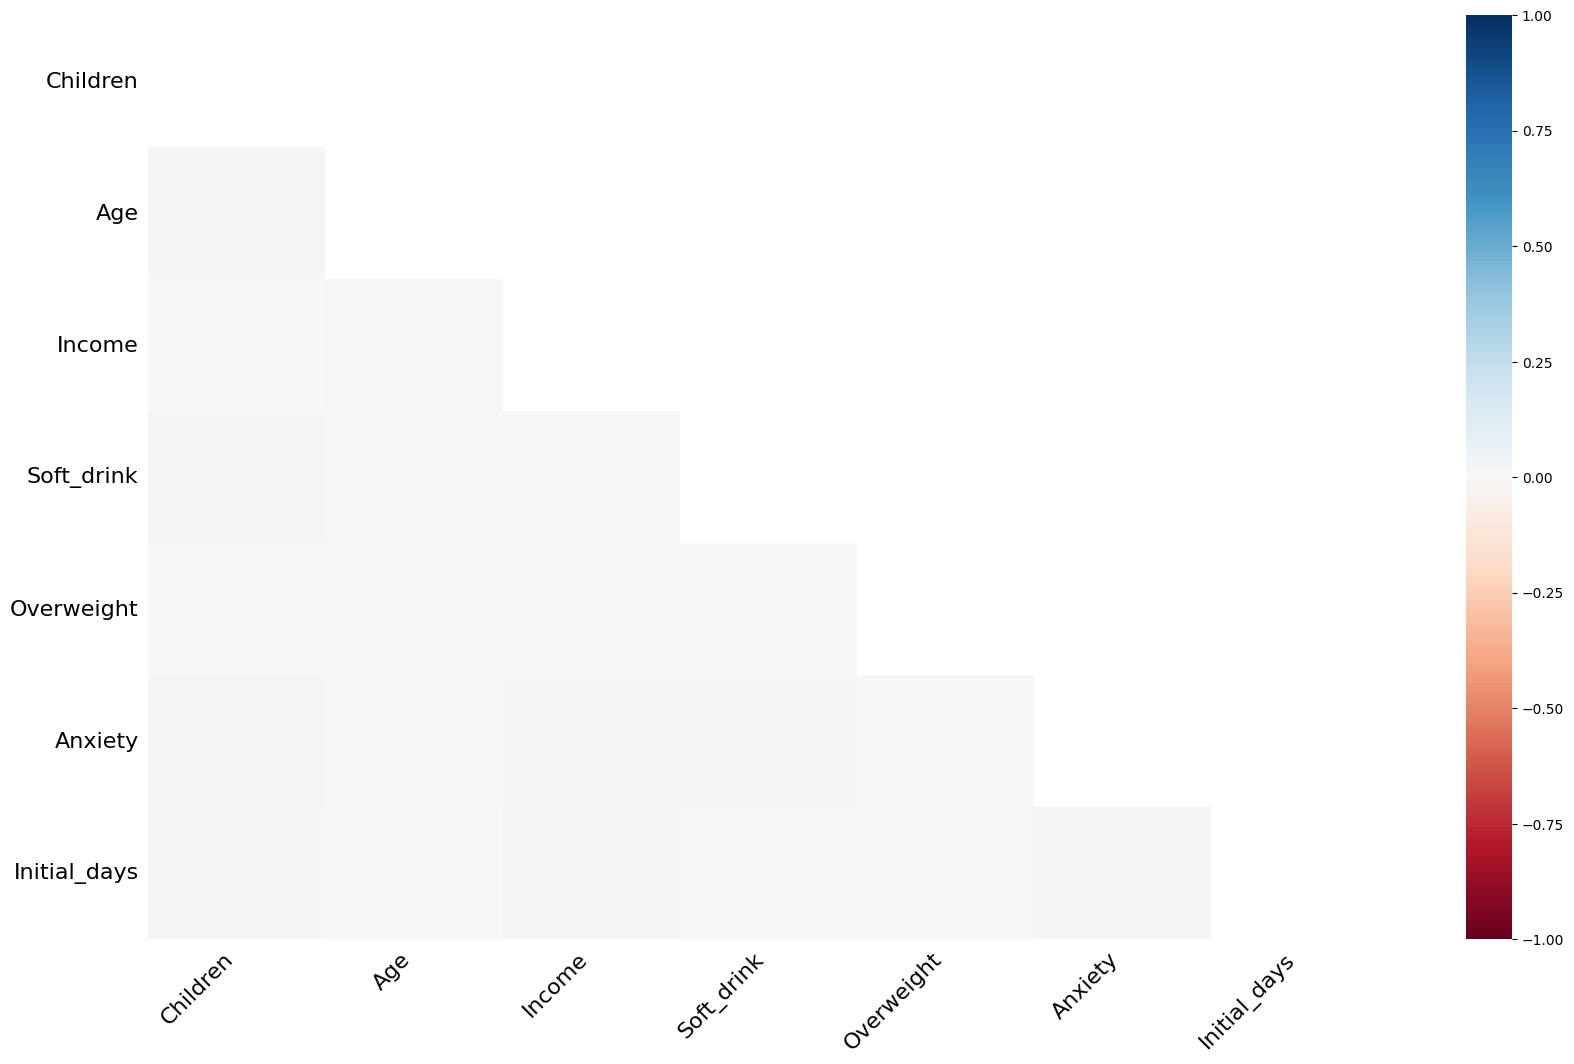

In [58]:
msno.heatmap(medical[incomplete_cols])

<Axes: >

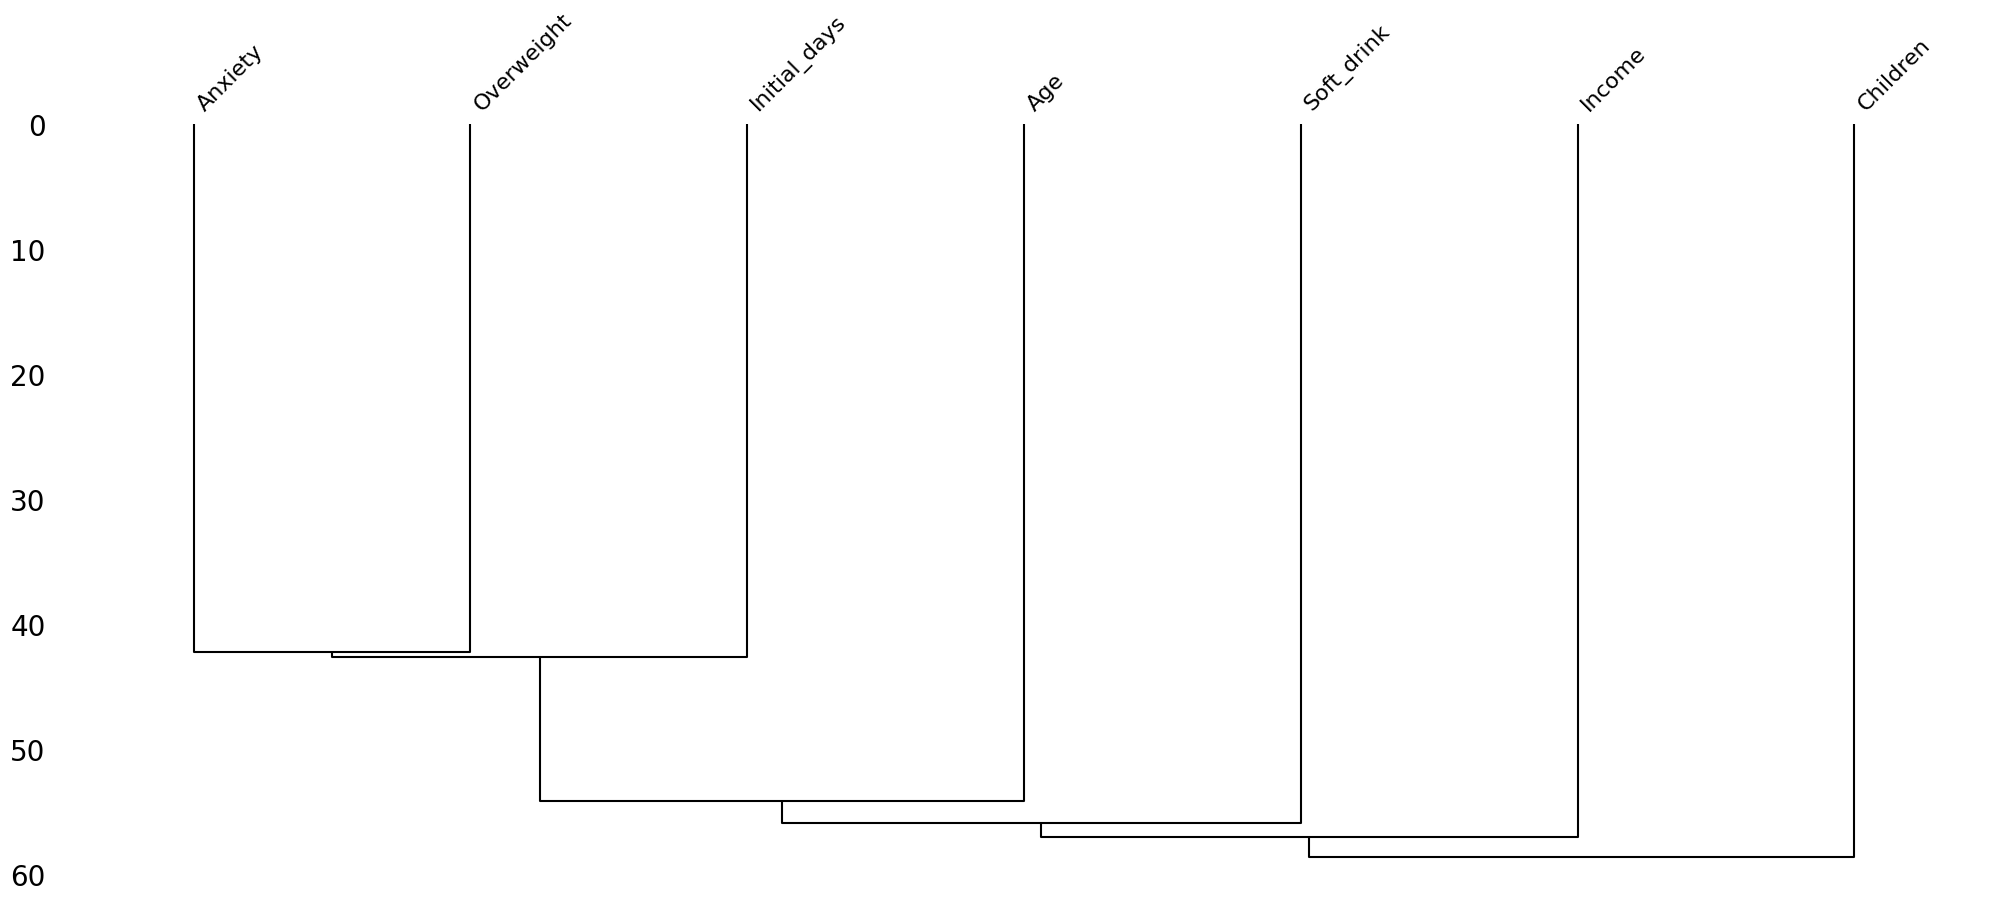

In [59]:
msno.dendrogram(medical[incomplete_cols])

<Axes: >

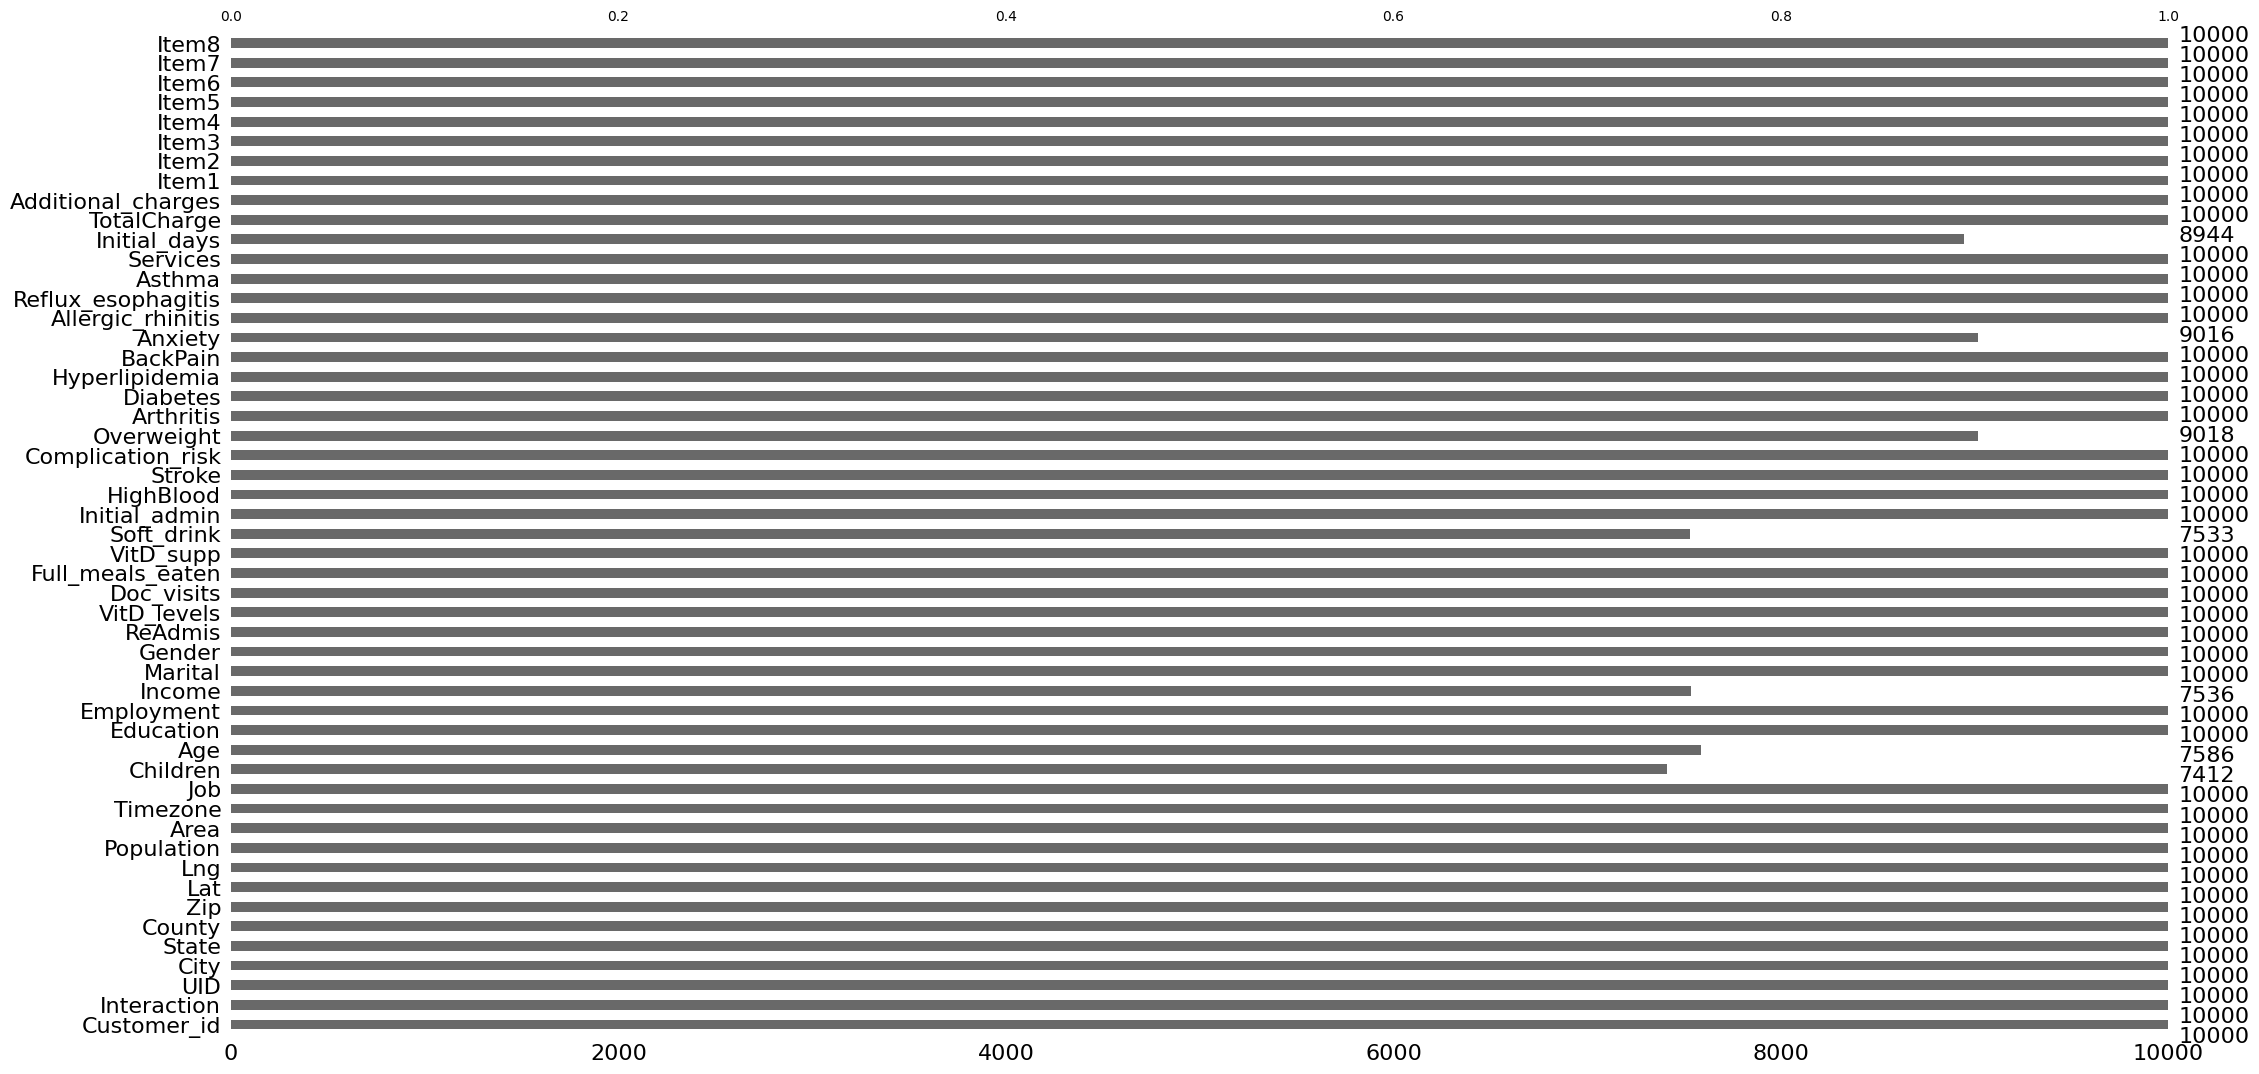

In [60]:
msno.bar(medical)

In [61]:
medical[incomplete_cols].describe()

,Children,Age,Income,Initial_days
count,7412.000000,7586.000000,7536.000000,8944.000000
mean,2.098219,53.295676,40484.438268,34.432082
std,2.155427,20.659182,28664.861050,26.287050
min,0.000000,18.000000,154.080000,1.001981
25%,0.000000,35.000000,19450.792500,7.911709
50%,1.000000,53.000000,33942.280000,34.446941
75%,3.000000,71.000000,54075.235000,61.124654
max,10.000000,89.000000,207249.130000,71.981486


In [62]:
for feature in medical.columns:
    print(feature, "\n\t", medical[feature].sample(5).values)

Customer_id 
	 ['C939267' 'X350972' 'Y987570' 'J539930' 'W470961']
Interaction 
	 ['0f4d0d14-3b6f-4cd6-b9a5-2c9c52f8e3e7'
 '2c70850d-daa6-46f0-8163-0d544b5ca1a1'
 '33808679-8fd5-4527-ad72-bd71413f064d'
 'e4ce592e-1f2c-4c29-b787-a3f2c74098e0'
 '3c6f18f0-af56-4a0b-82ad-fac3504c370d']
UID 
	 ['725a19a1f3efbe220c31cfbcbcbed199' 'cfe1b6319d10f4adc1299b05c1877cb2'
 '29845c3e1a8a3e23f47f707e56897742' '1deb78c9ad4ac4c5ffbbe08931235fa6'
 '5bd73a29950ae993538f6fb4800a21d9']
City 
	 ['New York', 'Downing', 'Kingsport', 'Sterling', 'West Lafayette']
Categories (6072, object): ['Aaronsburg', 'Abbeville', 'Aberdeen', 'Abilene', ..., 'Zelienople', 'Zenda', 'Zenia', 'Zumbro Falls']
State 
	 ['CA', 'CA', 'RI', 'NJ', 'MI']
Categories (52, object): ['AK', 'AL', 'AR', 'AZ', ..., 'WA', 'WI', 'WV', 'WY']
County 
	 ['Schuylkill', 'Kittitas', 'Morton', 'St. Louis', 'Suwannee']
Categories (1607, object): ['Abbeville', 'Acadia', 'Accomack', 'Ada', ..., 'Yuma', 'Zapata', 'Zavala', 'Ziebach']
Zip 
	 ['16354', '56

In [63]:
# medical.VitD_supp.value_counts()
# medical.Doc_visits.value_counts()
# medical.Full_meals_eaten.value_counts()
# medical.Full_meals_eaten.value_counts()
# medical.Initial_admin.value_counts().index
# medical.Services.value_counts().index
# len(medical.Timezone.value_counts().index.categories)
medical.Age.value_counts(dropna=False)

Age
NaN     2414
30.0     126
47.0     124
74.0     123
38.0     123
        ... 
82.0      90
75.0      90
63.0      90
51.0      89
36.0      85
Name: count, Length: 73, dtype: int64

In [64]:
# print(
#     medical.VitD_levels.min(),
#     medical.VitD_levels.max())

# print(
#     medical.Initial_days.min(),
#     medical.Initial_days.max())

print(
    medical.Age.min(),
    medical.Age.max())

18.0 89.0


In [65]:
medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Customer_id         10000 non-null  object  
 1   Interaction         10000 non-null  object  
 2   UID                 10000 non-null  object  
 3   City                10000 non-null  category
 4   State               10000 non-null  category
 5   County              10000 non-null  category
 6   Zip                 10000 non-null  category
 7   Lat                 10000 non-null  float64 
 8   Lng                 10000 non-null  float64 
 9   Population          10000 non-null  int64   
 10  Area                10000 non-null  category
 11  Timezone            10000 non-null  category
 12  Job                 10000 non-null  object  
 13  Children            7412 non-null   float64 
 14  Age                 7586 non-null   float64 
 15  Education           10000 non-null  c

In [66]:
for i in range(1, 9):
    print(medical[f"Item{i}"].value_counts().sort_index())

Item1
8       1
7      10
6     225
5    1377
4    3455
3    3404
2    1315
1     213
Name: count, dtype: int64
Item2
8       0
7      12
6     204
5    1421
4    3351
3    3439
2    1360
1     213
Name: count, dtype: int64
Item3
8       1
7      11
6     220
5    1358
4    3464
3    3379
2    1356
1     211
Name: count, dtype: int64
Item4
8       0
7      12
6     231
5    1388
4    3394
3    3422
2    1346
1     207
Name: count, dtype: int64
Item5
8       0
7      13
6     219
5    1308
4    3446
3    3423
2    1380
1     211
Name: count, dtype: int64
Item6
8       0
7      10
6     220
5    1403
4    3464
3    3371
2    1319
1     213
Name: count, dtype: int64
Item7
8       0
7      11
6     212
5    1274
4    3487
3    3456
2    1345
1     215
Name: count, dtype: int64
Item8
8       0
7      12
6     221
5    1429
4    3337
3    3401
2    1391
1     209
Name: count, dtype: int64


In [67]:
item_cols = [f"Item{i}" for i in range(1, 9)]

survey_reverse = medical[item_cols].copy(deep=True)

In [68]:
entry_inverse_map = {
    1: 8,
    2: 7,
    3: 6,
    4: 5,
    5: 4,
    6: 3,
    7: 2,
    8: 1
}

for i in range(1, 9):

    survey_reverse[f"Item{i}"] = (
        survey_reverse[f"Item{i}"].astype(int).map(entry_inverse_map))

In [69]:
display(
    survey_reverse.head(),
    medical[item_cols].head())

,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,6,6,7,7,5,6,6,5
1,6,5,6,5,5,5,6,6
2,7,5,5,5,6,5,6,6
3,6,4,4,6,5,4,4,4
4,7,8,6,6,4,6,5,6


,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,3,3,2,2,4,3,3,4
1,3,4,3,4,4,4,3,3
2,2,4,4,4,3,4,3,3
3,3,5,5,3,4,5,5,5
4,2,1,3,3,5,3,4,3
